**FIXED CODE - PHYSNET**

In [1]:
from __future__ import print_function, division
import os
import gc
import torch
import pandas as pd
from torch import nn
from torch.optim import Adam
import cv2
import matplotlib.pyplot as plt
import argparse,os
import numpy as np
import random
import math
from torchvision import transforms
import torch.nn as nn
from torch.nn.modules.utils import _triple
import pdb
from torch.utils.data import Dataset, DataLoader
import random
from sklearn.model_selection import train_test_split

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

num_epochs = 15
learning_rate = 1e-4

class Neg_Pearson(nn.Module):    # Pearson range [-1, 1] so if < 0, abs|loss| ; if >0, 1- loss
    def __init__(self):
        super(Neg_Pearson,self).__init__()
        return
    def forward(self, preds, labels):       # tensor [Batch, Temporal]
        loss = 0
        for i in range(preds.shape[0]):
            sum_x = torch.sum(preds[i])                # x
            sum_y = torch.sum(labels[i])               # y
            sum_xy = torch.sum(preds[i]*labels[i])        # xy
            sum_x2 = torch.sum(torch.pow(preds[i],2))  # x^2
            sum_y2 = torch.sum(torch.pow(labels[i],2)) # y^2
            N = preds.shape[1]
            pearson = (N*sum_xy - sum_x*sum_y)/(torch.sqrt((N*sum_x2 - torch.pow(sum_x,2))*(N*sum_y2 - torch.pow(sum_y,2))))

            if (pearson>=0).data.cpu().numpy():    # torch.cuda.ByteTensor -->  numpy
               loss += 1 - pearson
            else:
               loss += 1 - torch.abs(pearson)
            
        loss = loss/preds.shape[0]
        return loss

class PhysNet_padding_Encoder_Decoder_MAX(nn.Module):
    def __init__(self, frames = 960):  
        super(PhysNet_padding_Encoder_Decoder_MAX, self).__init__()
        
        self.ConvBlock1 = nn.Sequential(
            nn.Conv3d(3, 16, [1,5,5],stride=1, padding=[0,2,2]),
            nn.BatchNorm3d(16),
            nn.ReLU(inplace=True),
        )

        self.ConvBlock2 = nn.Sequential(
            nn.Conv3d(16, 32, [3, 3, 3], stride=1, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(inplace=True),
        )
        self.ConvBlock3 = nn.Sequential(
            nn.Conv3d(32, 64, [3, 3, 3], stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
        )
        
        self.ConvBlock4 = nn.Sequential(
            nn.Conv3d(64, 64, [3, 3, 3], stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
        )
        self.ConvBlock5 = nn.Sequential(
            nn.Conv3d(64, 64, [3, 3, 3], stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
        )
        self.ConvBlock6 = nn.Sequential(
            nn.Conv3d(64, 64, [3, 3, 3], stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
        )
        self.ConvBlock7 = nn.Sequential(
            nn.Conv3d(64, 64, [3, 3, 3], stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
        )
        self.ConvBlock8 = nn.Sequential(
            nn.Conv3d(64, 64, [3, 3, 3], stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
        )
        self.ConvBlock9 = nn.Sequential(
            nn.Conv3d(64, 64, [3, 3, 3], stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
        )
        
        self.upsample = nn.Sequential(
            nn.ConvTranspose3d(in_channels=64, out_channels=64, kernel_size=[4,1,1], stride=[2,1,1], padding=[1,0,0]),   #[1, 128, 32]
            nn.BatchNorm3d(64),
            nn.ELU(),
        )
        self.upsample2 = nn.Sequential(
            nn.ConvTranspose3d(in_channels=64, out_channels=64, kernel_size=[4,1,1], stride=[2,1,1], padding=[1,0,0]),   #[1, 128, 32]
            nn.BatchNorm3d(64),
            nn.ELU(),
        )
 
        self.ConvBlock10 = nn.Conv3d(64, 1, [1,1,1],stride=1, padding=0)
        
        self.MaxpoolSpa = nn.MaxPool3d((1, 2, 2), stride=(1, 2, 2))
        self.MaxpoolSpaTem = nn.MaxPool3d((2, 2, 2), stride=2)
        
        
        #self.poolspa = nn.AdaptiveMaxPool3d((frames,1,1))    # pool only spatial space 
        self.poolspa = nn.AdaptiveAvgPool3d((frames,1,1))

        
    def forward(self, x):	    	# x [3, T, 128,128]
        x_visual = x
        [batch,channel,length,width,height] = x.shape
          
        x = self.ConvBlock1(x)		     # x [3, T, 128,128]
        x = self.MaxpoolSpa(x)       # x [16, T, 64,64]
        
        x = self.ConvBlock2(x)		    # x [32, T, 64,64]
        x_visual6464 = self.ConvBlock3(x)	    	# x [32, T, 64,64]
        x = self.MaxpoolSpaTem(x_visual6464)      # x [32, T/2, 32,32]    Temporal halve
        
        x = self.ConvBlock4(x)		    # x [64, T/2, 32,32]
        x_visual3232 = self.ConvBlock5(x)	    	# x [64, T/2, 32,32]
        x = self.MaxpoolSpaTem(x_visual3232)      # x [64, T/4, 16,16]
        

        x = self.ConvBlock6(x)		    # x [64, T/4, 16,16]
        x_visual1616 = self.ConvBlock7(x)	    	# x [64, T/4, 16,16]
        x = self.MaxpoolSpa(x_visual1616)      # x [64, T/4, 8,8]

        x = self.ConvBlock8(x)		    # x [64, T/4, 8, 8]
        x = self.ConvBlock9(x)		    # x [64, T/4, 8, 8]
        x = self.upsample(x)		    # x [64, T/2, 8, 8]
        x = self.upsample2(x)		    # x [64, T, 8, 8]
        
        
        x = self.poolspa(x)     # x [64, T, 1,1]    -->  groundtruth left and right - 7 
        x = self.ConvBlock10(x) # x [1, T, 1,1]

        rPPG = x.view(-1, length) 
        
        return rPPG, x_visual, x_visual3232, x_visual1616

def load_video_frames_2(video_path, num_frames = 90, resize_shape=(128, 128)):
    frames = []
    detected_frame_count = 0
    
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        raise IOError(f"Error opening video file: {video_path}")
    
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    
    ret, frame = cap.read()
    if not ret:
        raise ValueError("Failed to read the first frame.")
    
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    faces = face_cascade.detectMultiScale(gray_frame, scaleFactor = 1.1, minNeighbors = 5, minSize = (30, 30))
    
    if len(faces) > 0:
        (x, y, w, h) = faces[0]
        face_region = frame[y:y+h, x:x+w]
        face_resized = cv2.resize(face_region, resize_shape)
        
        face_tensor = torch.from_numpy(face_resized).permute(2, 0, 1).unsqueeze(0).float() / 255.0
        frames.append(face_tensor)
        detected_frame_count += 1
    else:
        raise ValueError("No face detected in the first frame.")
    
    while detected_frame_count < num_frames:
        ret, frame = cap.read()
        if not ret:
            break
        
        face_region = frame[y:y+h, x:x+w]
        face_resized = cv2.resize(face_region, resize_shape)
        
        face_tensor = torch.from_numpy(face_resized).permute(2, 0, 1).unsqueeze(0).float() / 255.0
        frames.append(face_tensor)
        detected_frame_count += 1
    
    cap.release()
    
    if frames:
        frames_tensor = torch.cat(frames, dim=0)
        return frames_tensor, detected_frame_count
    else:
        raise ValueError("No faces detected in the video frames.")

class VideoDataset(Dataset):
    def __init__(self, video_paths, bvp_paths, resize_shape=(128, 128)):
        self.video_paths = video_paths
        self.bvp_paths = bvp_paths
        self.resize_shape = resize_shape
        
    def __len__(self):
        return len(self.video_paths)
    
    def __getitem__(self, idx):
        video_path = self.video_paths[idx]
        bvp_path = self.bvp_paths[idx]
        
        frames_tensor, detected_count = load_video_frames_2(video_path, resize_shape=self.resize_shape, num_frames=960)
        frames_tensor = frames_tensor.view(1, 3, detected_count, *self.resize_shape)
        
        bvp_df = pd.read_csv(bvp_path)
        BVP_label = torch.tensor(bvp_df["BVP"].values[:960], dtype=torch.float32).view(1, -1)
        BVP_label = (BVP_label - torch.mean(BVP_label)) / torch.std(BVP_label)
        
        return frames_tensor, BVP_label

video_paths = [rf"D:\UBFC\P-{l}\vid.avi" for l in range(1, 29)]
bvp_paths = [rf"D:\UBFC\P-{l}\BVP.csv" for l in range(1, 29)]

train_video_paths, val_video_paths, train_bvp_paths, val_bvp_paths = train_test_split(
    video_paths, bvp_paths, test_size = 0.25, random_state=42
)

train_dataset = VideoDataset(train_video_paths, train_bvp_paths)
val_dataset = VideoDataset(val_video_paths, val_bvp_paths)

batch_size = 1
num_workers = 0

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle = True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle = False, num_workers=num_workers)

model = PhysNet_padding_Encoder_Decoder_MAX(frames = 960)
optimizer = Adam(model.parameters(), lr=learning_rate)

neg_pearson_loss = Neg_Pearson()

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    epoch_loss = 0 

    model.train()

    for inputs, BVP_label in train_loader:
        inputs = inputs.to(torch.float32).squeeze(0)
        BVP_label = BVP_label.to(torch.float32).squeeze(0)
        
        rPPG, _, _, _ = model(inputs)
        rPPG = rPPG[:, :BVP_label.shape[1]]

        rPPG = (rPPG - torch.mean(rPPG)) / torch.std(rPPG)
        
        loss = neg_pearson_loss(rPPG, BVP_label)
        epoch_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(f"Loss for batch: {loss.item()}")

    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch + 1} average training loss: {epoch_loss / len(train_loader)}")

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, BVP_label in val_loader:
            inputs = inputs.to(torch.float32).squeeze(0)
            BVP_label = BVP_label.to(torch.float32).squeeze(0)

            rPPG, _, _, _ = model(inputs)
            rPPG = rPPG[:, :BVP_label.shape[1]]

            rPPG = (rPPG - torch.mean(rPPG)) / torch.std(rPPG)

            loss = neg_pearson_loss(rPPG, BVP_label)
            val_loss += loss.item()

            print(f"Loss for batch: {loss.item()}")

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch + 1} average validation loss: {val_loss / len(val_loader)}")

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', marker='o')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

C:\Users\Vinod\AppData\Roaming\Python\Python39\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
C:\Users\Vinod\AppData\Local\Temp\ipykernel_23720\1819324739.py:253: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globa

Epoch 1/50
Loss for batch: 0.007775843143463135
Loss for batch: 0.027220964431762695
Loss for batch: 0.015398621559143066
Loss for batch: 0.029458999633789062
Loss for batch: 0.029980957508087158
Loss for batch: 0.02986609935760498
Loss for batch: 0.031137585639953613
Loss for batch: 0.030883610248565674
Loss for batch: 0.04288327693939209
Loss for batch: 0.03234982490539551
Loss for batch: 0.04680901765823364
Loss for batch: 0.038197219371795654
Loss for batch: 0.031998395919799805
Loss for batch: 0.03694814443588257
Loss for batch: 0.04290491342544556
Loss for batch: 0.05440640449523926
Loss for batch: 0.04483574628829956
Loss for batch: 0.055741190910339355
Loss for batch: 0.05502980947494507
Loss for batch: 0.0597996711730957
Loss for batch: 0.044635236263275146
Epoch 1 average training loss: 0.03753626346588135
Loss for batch: 0.9551529288291931
Loss for batch: 0.9792845249176025
Loss for batch: 0.9338456988334656
Loss for batch: 0.9208293557167053
Loss for batch: 0.96674668788909

KeyboardInterrupt: 

In [10]:
model_save_path = r"D:\UBFC\Trained Models\PhysNet_TrainValid.pth"
torch.save(model, model_save_path)
model = torch.load(model_save_path)
model.eval()

C:\Users\Vinod\AppData\Local\Temp\ipykernel_20972\3255097956.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_save_path)


PhysNet_padding_Encoder_Decoder_MAX(
  (ConvBlock1): Sequential(
    (0): Conv3d(3, 16, kernel_size=(1, 5, 5), stride=(1, 1, 1), padding=(0, 2, 2))
    (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (ConvBlock2): Sequential(
    (0): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (ConvBlock3): Sequential(
    (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (ConvBlock4): Sequential(
    (0): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (ConvBlock5): Sequential(
    

In [3]:
from __future__ import print_function, division
import os
import gc
import torch
import pandas as pd
from torch import nn
from torch.optim import Adam
import cv2
import matplotlib.pyplot as plt
import argparse,os
import numpy as np
import random
import math
from torchvision import transforms
import torch.nn as nn
from torch.nn.modules.utils import _triple
import pdb
from torch.utils.data import Dataset, DataLoader
import random
from sklearn.model_selection import train_test_split
import gc

class PhysNet_padding_Encoder_Decoder_MAX_DropOut(nn.Module):
    def __init__(self, frames=128, dropout=0.3):  
        super(PhysNet_padding_Encoder_Decoder_MAX_DropOut, self).__init__()

        self.ConvBlock1 = nn.Sequential(
            nn.Conv3d(3, 16, [1,5,5], stride=1, padding=[0,2,2]),
            nn.BatchNorm3d(16),
            nn.ReLU(inplace=True),
            nn.Dropout3d(dropout)
        )

        self.ConvBlock2 = nn.Sequential(
            nn.Conv3d(16, 32, [3, 3, 3], stride=1, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(inplace=True),
            nn.Dropout3d(dropout)
        )
        
        self.ConvBlock3 = nn.Sequential(
            nn.Conv3d(32, 64, [3, 3, 3], stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
            nn.Dropout3d(dropout)
        )
        
        self.ConvBlock4 = nn.Sequential(
            nn.Conv3d(64, 64, [3, 3, 3], stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
            nn.Dropout3d(dropout)
        )
        
        self.ConvBlock5 = nn.Sequential(
            nn.Conv3d(64, 64, [3, 3, 3], stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
            nn.Dropout3d(dropout)
        )
        
        self.ConvBlock6 = nn.Sequential(
            nn.Conv3d(64, 64, [3, 3, 3], stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
            nn.Dropout3d(dropout)
        )
        
        self.ConvBlock7 = nn.Sequential(
            nn.Conv3d(64, 64, [3, 3, 3], stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
            nn.Dropout3d(dropout)
        )
        
        self.ConvBlock8 = nn.Sequential(
            nn.Conv3d(64, 64, [3, 3, 3], stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
            nn.Dropout3d(dropout)
        )
        
        self.ConvBlock9 = nn.Sequential(
            nn.Conv3d(64, 64, [3, 3, 3], stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
            nn.Dropout3d(dropout)
        )
        
        self.upsample = nn.Sequential(
            nn.ConvTranspose3d(64, 64, kernel_size=[4,1,1], stride=[2,1,1], padding=[1,0,0]),
            nn.BatchNorm3d(64),
            nn.ELU(),
            nn.Dropout3d(dropout)
        )
        
        self.upsample2 = nn.Sequential(
            nn.ConvTranspose3d(64, 64, kernel_size=[4,1,1], stride=[2,1,1], padding=[1,0,0]),
            nn.BatchNorm3d(64),
            nn.ELU(),
            nn.Dropout3d(dropout)
        )
        
        self.ConvBlock10 = nn.Conv3d(64, 1, [1,1,1], stride=1, padding=0)
        
        self.MaxpoolSpa = nn.MaxPool3d((1, 2, 2), stride=(1, 2, 2))
        self.MaxpoolSpaTem = nn.MaxPool3d((2, 2, 2), stride=2)
        self.poolspa = nn.AdaptiveAvgPool3d((frames, 1, 1))

    def forward(self, x):
        x_visual = x
        [batch, channel, length, width, height] = x.shape

        x = self.ConvBlock1(x)
        x = self.MaxpoolSpa(x)

        x = self.ConvBlock2(x)
        x_visual6464 = self.ConvBlock3(x)
        x = self.MaxpoolSpaTem(x_visual6464)

        x = self.ConvBlock4(x)
        x_visual3232 = self.ConvBlock5(x)
        x = self.MaxpoolSpaTem(x_visual3232)

        x = self.ConvBlock6(x)
        x_visual1616 = self.ConvBlock7(x)
        x = self.MaxpoolSpa(x_visual1616)

        x = self.ConvBlock8(x)
        x = self.ConvBlock9(x)
        x = self.upsample(x)
        x = self.upsample2(x)

        x = self.poolspa(x)
        x = self.ConvBlock10(x)
        
        rPPG = x.view(-1, length)
        
        return rPPG


class VideoDataset(Dataset):
    def __init__(self, video_paths, bvp_paths, resize_shape=(128, 128)):
        self.video_paths = video_paths
        self.bvp_paths = bvp_paths
        self.resize_shape = resize_shape
        
    def __len__(self):
        return len(self.video_paths)
    
    def __getitem__(self, idx):
        video_path = self.video_paths[idx]
        bvp_path = self.bvp_paths[idx]
        
        frames_tensor, detected_count = load_video_frames_2(video_path, resize_shape=self.resize_shape, num_frames=960)
        frames_tensor = frames_tensor.view(3, detected_count, *self.resize_shape)  # Ensure consistent shape
        
        bvp_df = pd.read_csv(bvp_path)
        BVP_label = torch.tensor(bvp_df["BVP"].values[:960], dtype=torch.float32).view(-1)
        BVP_label = (BVP_label - torch.mean(BVP_label)) / torch.std(BVP_label)
        
        return frames_tensor, BVP_label

train_video_paths, val_video_paths, train_bvp_paths, val_bvp_paths = train_test_split(
    video_paths, bvp_paths, test_size=0.2, random_state=42
)

train_dataset = VideoDataset(train_video_paths, train_bvp_paths)
val_dataset = VideoDataset(val_video_paths, val_bvp_paths)

batch_size = 2
num_workers = 0

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

num_epochs = 50
learning_rate = 1e-4
weight_decay = 1e-5

model = PhysNet_padding_Encoder_Decoder_MAX_DropOut(frames=960, dropout = 0.25)
optimizer = Adam(model.parameters(), lr=learning_rate * 0.5, weight_decay=weight_decay)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor = 0.5, patience = 3, verbose=True)

train_losses = []
val_losses = []

neg_pearson_loss = Neg_Pearson()

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    epoch_loss = 0 

    model.train()

    for inputs, BVP_label in train_loader:
        inputs = inputs.to(torch.float32)
        BVP_label = BVP_label.to(torch.float32)
        
        rPPG = model(inputs)
        rPPG = rPPG[:, :BVP_label.shape[1]]
        rPPG = (rPPG - torch.mean(rPPG)) / torch.std(rPPG)
        
        loss = neg_pearson_loss(rPPG, BVP_label)
        epoch_loss += loss.item()

        print(f"Loss for batch: {loss.item()}")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch + 1} average training loss: {avg_train_loss}")

    model.eval()
    val_loss = 0
    
    with torch.no_grad():
        for inputs2, BVP_label in val_loader:
            inputs2 = inputs.to(torch.float32)
            BVP_label = BVP_label.to(torch.float32)

            rPPG2 = model(inputs2)
            rPPG2 = rPPG2[:, :BVP_label.shape[1]]
            rPPG2 = (rPPG2 - torch.mean(rPPG2)) / torch.std(rPPG2)

            loss = neg_pearson_loss(rPPG2, BVP_label)
            val_loss += loss.item()

            print(f"Loss for batch: {loss.item()}")

    avg_val_loss = val_loss / len(val_loader)
    scheduler.step(avg_val_loss)
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch + 1} average validation loss: {avg_val_loss}")

     del inputs, inputs2, rPPG, rPPG2
     gc.collect()
     torch.cuda.empty_cache()

C:\Users\Vinod\AppData\Roaming\Python\Python39\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50
Loss for batch: 0.9950281381607056
Loss for batch: 0.9965627193450928
Loss for batch: 0.9897457361221313
Loss for batch: 0.9966247081756592
Loss for batch: 0.9962393045425415
Loss for batch: 0.996962308883667
Loss for batch: 0.987359881401062
Loss for batch: 0.9890778660774231
Loss for batch: 0.9949142932891846
Loss for batch: 0.9933674335479736
Loss for batch: 0.9918398261070251
Epoch 1 average training loss: 0.9934292923320424
Loss for batch: 0.9968585968017578
Loss for batch: 0.998566210269928
Loss for batch: 0.9966589212417603
Epoch 1 average validation loss: 0.9973612427711487
Epoch 2/50
Loss for batch: 0.9917235374450684
Loss for batch: 0.9938291311264038
Loss for batch: 0.9889843463897705
Loss for batch: 0.9917125701904297
Loss for batch: 0.9968838691711426
Loss for batch: 0.9939801692962646
Loss for batch: 0.9877833127975464
Loss for batch: 0.9838666319847107
Loss for batch: 0.9886894226074219
Loss for batch: 0.9915759563446045
Loss for batch: 0.985581636428833
Epoch

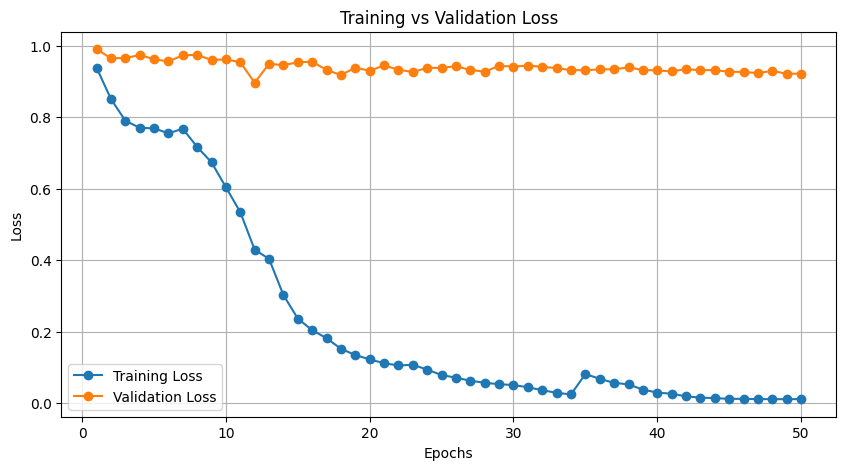

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', marker='o')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [4]:
model_save_path = r"D:\UBFC\Trained Models\PhysNet_TrainValid_DropOut_Scheduler.pth"
torch.save(model, model_save_path)
model = torch.load(model_save_path)
model.eval()

C:\Users\Vinod\AppData\Local\Temp\ipykernel_20972\2262548016.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_save_path)


PhysNet_padding_Encoder_Decoder_MAX_DropOut(
  (ConvBlock1): Sequential(
    (0): Conv3d(3, 16, kernel_size=(1, 5, 5), stride=(1, 1, 1), padding=(0, 2, 2))
    (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout3d(p=0.25, inplace=False)
  )
  (ConvBlock2): Sequential(
    (0): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout3d(p=0.25, inplace=False)
  )
  (ConvBlock3): Sequential(
    (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout3d(p=0.25, inplace=False)
  )
  (ConvBlock4): Sequential(
    (0): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3

In [2]:
from __future__ import print_function, division
import os
import gc
import torch
import pandas as pd
from torch import nn
from torch.optim import Adam
import cv2
import matplotlib.pyplot as plt
import argparse,os
import numpy as np
import random
import math
from torchvision import transforms
import torch.nn as nn
from torch.nn.modules.utils import _triple
import pdb
from torch.utils.data import Dataset, DataLoader
import random
from sklearn.model_selection import train_test_split

class PhysNet_padding_Encoder_Decoder_MAX(nn.Module):
    def __init__(self, frames = 960):  
        super(PhysNet_padding_Encoder_Decoder_MAX, self).__init__()
        
        self.ConvBlock1 = nn.Sequential(
            nn.Conv3d(3, 16, [1,5,5],stride=1, padding=[0,2,2]),
            nn.BatchNorm3d(16),
            nn.ReLU(inplace=True),
        )

        self.ConvBlock2 = nn.Sequential(
            nn.Conv3d(16, 32, [3, 3, 3], stride=1, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(inplace=True),
        )
        self.ConvBlock3 = nn.Sequential(
            nn.Conv3d(32, 64, [3, 3, 3], stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
        )
        
        self.ConvBlock4 = nn.Sequential(
            nn.Conv3d(64, 64, [3, 3, 3], stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
        )
        self.ConvBlock5 = nn.Sequential(
            nn.Conv3d(64, 64, [3, 3, 3], stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
        )
        self.ConvBlock6 = nn.Sequential(
            nn.Conv3d(64, 64, [3, 3, 3], stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
        )
        self.ConvBlock7 = nn.Sequential(
            nn.Conv3d(64, 64, [3, 3, 3], stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
        )
        self.ConvBlock8 = nn.Sequential(
            nn.Conv3d(64, 64, [3, 3, 3], stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
        )
        self.ConvBlock9 = nn.Sequential(
            nn.Conv3d(64, 64, [3, 3, 3], stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
        )
        
        self.upsample = nn.Sequential(
            nn.ConvTranspose3d(in_channels=64, out_channels=64, kernel_size=[4,1,1], stride=[2,1,1], padding=[1,0,0]),   #[1, 128, 32]
            nn.BatchNorm3d(64),
            nn.ELU(),
        )
        self.upsample2 = nn.Sequential(
            nn.ConvTranspose3d(in_channels=64, out_channels=64, kernel_size=[4,1,1], stride=[2,1,1], padding=[1,0,0]),   #[1, 128, 32]
            nn.BatchNorm3d(64),
            nn.ELU(),
        )
 
        self.ConvBlock10 = nn.Conv3d(64, 1, [1,1,1],stride=1, padding=0)
        
        self.MaxpoolSpa = nn.MaxPool3d((1, 2, 2), stride=(1, 2, 2))
        self.MaxpoolSpaTem = nn.MaxPool3d((2, 2, 2), stride=2)
        
        
        #self.poolspa = nn.AdaptiveMaxPool3d((frames,1,1))    # pool only spatial space 
        self.poolspa = nn.AdaptiveAvgPool3d((frames,1,1))

        
    def forward(self, x):	    	# x [3, T, 128,128]
        x_visual = x
        [batch,channel,length,width,height] = x.shape
          
        x = self.ConvBlock1(x)		     # x [3, T, 128,128]
        x = self.MaxpoolSpa(x)       # x [16, T, 64,64]
        
        x = self.ConvBlock2(x)		    # x [32, T, 64,64]
        x_visual6464 = self.ConvBlock3(x)	    	# x [32, T, 64,64]
        x = self.MaxpoolSpaTem(x_visual6464)      # x [32, T/2, 32,32]    Temporal halve
        
        x = self.ConvBlock4(x)		    # x [64, T/2, 32,32]
        x_visual3232 = self.ConvBlock5(x)	    	# x [64, T/2, 32,32]
        x = self.MaxpoolSpaTem(x_visual3232)      # x [64, T/4, 16,16]
        

        x = self.ConvBlock6(x)		    # x [64, T/4, 16,16]
        x_visual1616 = self.ConvBlock7(x)	    	# x [64, T/4, 16,16]
        x = self.MaxpoolSpa(x_visual1616)      # x [64, T/4, 8,8]

        x = self.ConvBlock8(x)		    # x [64, T/4, 8, 8]
        x = self.ConvBlock9(x)		    # x [64, T/4, 8, 8]
        x = self.upsample(x)		    # x [64, T/2, 8, 8]
        x = self.upsample2(x)		    # x [64, T, 8, 8]
        
        
        x = self.poolspa(x)     # x [64, T, 1,1]    -->  groundtruth left and right - 7 
        x = self.ConvBlock10(x) # x [1, T, 1,1]

        rPPG = x.view(-1, length) 
        
        return rPPG, x_visual, x_visual3232, x_visual1616

model_save_path = r"D:\UBFC\Trained Models\PhysNet_Final.pt"
model = torch.load(model_save_path)
model.eval()

for l in range(29, 43):
    print(l)
    for k in range(1, 17):
            try:
                    video_filename = f"clip_{k}.avi"
                    target_directory = rf"D:\UBFC\Testing\Split_Testing_Phys\P-{l}"
                    video_path = os.path.join(target_directory, video_filename)
                    inputs, detected_count = load_video_frames_2(video_path, num_frames = 128)
                    inputs = inputs.view(1, 3, detected_count, 128, 128)
      
                    with torch.no_grad():
                        rPPG = model(inputs)
                        
                    rPPG = (rPPG[0] - torch.mean(rPPG[0])) / torch.std(rPPG[0])
                    rPPG_2 = rPPG.detach().numpy()
                    df = pd.DataFrame({'Pulse': rPPG_2[0]})
                    df.to_csv(rf"D:\UBFC\P-{l}\PhysNet\BVP_AVI\BVP_Frame1_LowestTrainLoss.csv", index = False)
    
                    del inputs, rPPG, rPPG_2
                    gc.collect()
                    torch.cuda.empty_cache()
            except (ValueError, OSError) as e:
                print(e)
                pass

C:\Users\Vinod\AppData\Roaming\Python\Python39\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
C:\Users\Vinod\AppData\Local\Temp\ipykernel_2668\1560561559.py:129: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_global

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [9]:
import torch 
import os
import pandas as pd
import cv2
import gc
from mtcnn import MTCNN

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_save_path = r"D:\UBFC\Trained Models\LSTC-rPPG_1.pth"
model = torch.load(model_save_path, map_location = torch.device('cpu'))
model.eval()

def load_video_frames_2(video_path, num_frames = 160, resize_shape=(128, 128)):
    frames = []
    detected_frame_count = 0

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise IOError(f"Error opening video file: {video_path}")
    
    mtcnn = MTCNN()
    face_box = None 
    
    while detected_frame_count < num_frames:
        ret, frame = cap.read()
        if not ret:
            break

        if detected_frame_count == 0:
            detections = mtcnn.detect_faces(frame)
            if detections:
                x, y, w, h = detections[0]['box']
                
                center_x, center_y = x + w // 2, y + h // 2
                w, h = int(w * 1.6), int(h * 1.6)
                x, y = max(0, center_x - w // 2), max(0, center_y - h // 2)
                
                face_box = (x, y, w, h)
            else:
                raise ValueError("No face detected in the first frame.")
        
        if face_box:
            x, y, w, h = face_box
            face_region = frame[y:y+h, x:x+w]
            face_resized = cv2.resize(face_region, resize_shape)
            
            face_tensor = torch.from_numpy(face_resized).permute(2, 0, 1).unsqueeze(0).float() / 255.0
            frames.append(face_tensor)
            detected_frame_count += 1

    cap.release()

    if frames:
        frames_tensor = torch.cat(frames, dim=0)
        return frames_tensor, detected_frame_count
    else:
        raise ValueError("No faces detected in the video frames.")

for l in range(29, 43):
    print(l)
    for k in range(1, 13):
            try:
                    video_filename = f"clip_{k}.avi"
                    target_directory = rf"D:\UBFC\Testing\Split_Testing\P-{l}"
                    video_path = os.path.join(target_directory, video_filename)
                    inputs, detected_count = load_video_frames_2(video_path, num_frames = 960)
                    inputs = inputs.view(1, 3, detected_count, 128, 128).to(device)
      
                    with torch.no_grad():
                        rPPG = model(inputs)
                        
                    rPPG = (rPPG - torch.mean(rPPG) / torch.std(rPPG))
                    rPPG_2 = rPPG.detach().numpy()
                    df = pd.DataFrame({'Pulse': rPPG_2})
                    df.to_csv(rf"D:\UBFC\Testing\P-{l}\LSTC-rPPG\BVP_AVI\BVP_Trained_Clip_{k}.csv", index = False)
    
                    del inputs, rPPG, rPPG_2
                    gc.collect()
                    torch.cuda.empty_cache()
            except (ValueError, OSError) as e:
                print(e)
                pass

C:\Users\Vinod\AppData\Local\Temp\ipykernel_131612\1716499858.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_save_path, map_location = torch.d

29
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
29
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
29
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1

In [2]:
class LSTCrPPG(torch.nn.Module):
    def __init__(self, frames = 160):
        super(LSTCrPPG, self).__init__()
        self.encoder_block = EncoderBlock()
        self.decoder_block = DecoderBlock()

    def forward(self, x):
        e = self.encoder_block(x)
        out = self.decoder_block(e)
        return out.squeeze()


class EncoderBlock(torch.nn.Module):
    def __init__(self):
        super(EncoderBlock, self).__init__()
        self.encoder_block1 = torch.nn.Sequential(
            ConvBlock3D(3, 16, [3,3,3], [1,1,1], [1,1,1]),
            ConvBlock3D(16, 16, [3,3,3], [1,1,1], [1,1,1]),
            torch.nn.BatchNorm3d(16)
        )
        self.encoder_block2 = torch.nn.Sequential(
            torch.nn.AvgPool3d(2),
            ConvBlock3D(16, 16, [3, 3, 3], [1, 1, 1], [1,1,1]),
            ConvBlock3D(16, 16, [3, 3, 3], [1, 1, 1], [1,1,1]),
            torch.nn.BatchNorm3d(16)
        )
        self.encoder_block3 = torch.nn.Sequential(
            torch.nn.AvgPool3d(2),
            ConvBlock3D(16, 32, [3, 3, 3], [1, 1, 1], [1,1,1]),
            ConvBlock3D(32, 32, [3, 3, 3], [1, 1, 1], [1,1,1]),
            torch.nn.BatchNorm3d(32)
        )
        self.encoder_block4 = torch.nn.Sequential(
            torch.nn.AvgPool3d(2),
            ConvBlock3D(32, 32, [3, 3, 3], [1, 1, 1], [1,1,1]),
            ConvBlock3D(32, 32, [3, 3, 3], [1, 1, 1], [1,1,1]),
            torch.nn.BatchNorm3d(32)
        )
        self.encoder_block5 = torch.nn.Sequential(
            torch.nn.AvgPool3d(2),
            ConvBlock3D(32, 64, [3, 3, 3], [1, 1, 1], [1,1,1]),
            ConvBlock3D(64, 64, [3, 3, 3], [1, 1, 1], [1,1,1]),
            torch.nn.BatchNorm3d(64)
        )
        self.encoder_block6 = torch.nn.Sequential(
            torch.nn.AvgPool3d(2),
            ConvBlock3D(64, 64, [3, 3, 3], [1, 1, 1], [1,1,1]),
            torch.nn.BatchNorm3d(64)
        )
        self.encoder_block7 = torch.nn.Sequential(
            ConvBlock3D(64, 64, [5, 3, 3], [1, 1, 1], [0,1,1]),
            torch.nn.BatchNorm3d(64)
        )

    def forward(self, x):
        e1 = self.encoder_block1(x)
        e2 = self.encoder_block2(e1)
        e3 = self.encoder_block3(e2)
        e4 = self.encoder_block4(e3)
        e5 = self.encoder_block5(e4)
        e6 = self.encoder_block6(e5)
        e7 = self.encoder_block7(e6)

        return [e7,e6,e5,e4,e3,e2,e1]

class DecoderBlock(torch.nn.Module):
    def __init__(self):
        super(DecoderBlock, self).__init__()
        self.decoder_block6_transpose = torch.nn.ConvTranspose3d(64,64,[5,1,1],[1,1,1])
        self.decoder_block6 = torch.nn.Sequential(
            ConvBlock3D(64, 64, [3, 3, 3], [1, 1, 1], [1,1,1]),
            torch.nn.BatchNorm3d(64)
        )
        self.decoder_block5_transpose =torch.nn.ConvTranspose3d(64, 64, [4, 1, 1],[2,1,1])
        self.decoder_block5 = torch.nn.Sequential(
            ConvBlock3D(64, 32, [3, 3, 3], [1, 1, 1],[1,1,1]),
            ConvBlock3D(32, 32, [3, 3, 3], [1, 1, 1],[0,1,1]),
            torch.nn.BatchNorm3d(32)
        )
        self.decoder_block4_transpose = torch.nn.ConvTranspose3d(32, 32, [4, 1, 1],[2,1,1])
        self.decoder_block4 = torch.nn.Sequential(
            ConvBlock3D(32, 32, [3, 3, 3], [1, 1, 1], [1,1,1]),
            ConvBlock3D(32, 32, [3, 3, 3], [1, 1, 1], [0,1,1]),
            torch.nn.BatchNorm3d(32)
        )
        self.decoder_block3_transpose = torch.nn.ConvTranspose3d(32, 32, [4, 1, 1],[2,1,1])
        self.decoder_block3 = torch.nn.Sequential(
            ConvBlock3D(32, 16, [3, 3, 3], [1, 1, 1], [1,1,1]),
            ConvBlock3D(16, 16, [3, 3, 3], [1, 1, 1], [0,1,1]),
            torch.nn.BatchNorm3d(16)
        )
        self.decoder_block2_transpose = torch.nn.ConvTranspose3d(16, 16, [4, 1, 1],[2,1,1])
        self.decoder_block2 = torch.nn.Sequential(
            ConvBlock3D(16, 16, [3, 3, 3], [1, 1, 1], [1,1,1]),
            ConvBlock3D(16, 16, [3, 3, 3], [1, 1, 1], [0,1,1]),
            torch.nn.BatchNorm3d(16)
        )
        self.decoder_block1_transpose = torch.nn.ConvTranspose3d(16, 16, [4, 1, 1],[2,1,1])
        self.decoder_block1 = torch.nn.Sequential(
            ConvBlock3D(16, 3, [3, 3, 3], [1, 1, 1], [1,1,1]),
            ConvBlock3D(3, 3, [3, 3, 3], [1, 1, 1], [0,1,1]),
            torch.nn.BatchNorm3d(3)
        )
        self.predictor = torch.nn.Conv3d(3, 1 ,[1,4,4])

    def forward(self, encoded_feature):
        d6 = self.decoder_block6(self.TARM(encoded_feature[1], self.decoder_block6_transpose(encoded_feature[0])))
        d5 = self.decoder_block5(self.TARM(encoded_feature[2],self.decoder_block5_transpose(d6)))
        d4 = self.decoder_block4(self.TARM(encoded_feature[3],self.decoder_block4_transpose(d5)))
        d3 = self.decoder_block3(self.TARM(encoded_feature[4],self.decoder_block3_transpose(d4)))
        d2 = self.decoder_block2(self.TARM(encoded_feature[5],self.decoder_block2_transpose(d3)))
        d1 = self.decoder_block1(self.TARM(encoded_feature[6],self.decoder_block1_transpose(d2)))
        predictor = self.predictor(d1)
        return predictor

    def TARM(self, e,d):
        target = d
        shape = d.shape
        e = torch.nn.functional.adaptive_avg_pool3d(e,d.shape[2:])
        e = e.view(e.shape[0],e.shape[1], shape[2],-1)
        d = d.view(d.shape[0], shape[1], shape[2], -1)
        temporal_attention_map = e @ torch.transpose(d,3,2)
        temporal_attention_map = torch.nn.functional.softmax(temporal_attention_map,dim=-1)
        refined_map = temporal_attention_map@e
        out = ( 1 + torch.reshape(refined_map,shape)) * target
        return out

class ConvBlock3D(torch.nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size, stride, padding):
        super(ConvBlock3D, self).__init__()
        self.conv_block_3d = torch.nn.Sequential(
            torch.nn.Conv3d(in_channel, out_channel, kernel_size, stride, padding),
            torch.nn.ELU()
        )

    def forward(self, x):
        return self.conv_block_3d(x)

**RTrPPG - Full code**

In [ ]:
import os
import pandas as pd
import numpy as np

# Directory containing the CSV files
directory = r'D:\HRV_New\Data\Dynamic\Ergobike\Ground Truth'

# Iterate over each file in the directory
for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        # Read the CSV file
        file_path = os.path.join(directory, filename)
        df = pd.read_csv(file_path, skiprows = 4)
        
        # Ensure the column names are correct
        if 'Time(s)' in df.columns and 'HR(BPM)' in df.columns:
            # Initialize lists to store the results
            avg_values = []
            min_values = []
            max_values = []
            intervals = []
            ranges = []

            # Process the data in 5-second intervals
            max_time = df['Time(s)'].max()
            for start in range(1, int(max_time) + 1, 15):
                end = start + 14
                interval_df = df[(df['Time(s)'] >= start) & (df['Time(s)'] <= end)]
                if not interval_df.empty:
                    avg_hr = np.round(interval_df['HR(BPM)'].mean())
                    min_hr = interval_df['HR(BPM)'].min()
                    max_hr = interval_df['HR(BPM)'].max()
                    range_hr = f"{min_hr} - {max_hr}"
                    
                    avg_values.append(avg_hr)
                    min_values.append(min_hr)
                    max_values.append(max_hr)
                    intervals.append(f'{start}-{end}')
                    ranges.append(range_hr)

            # Create a new DataFrame with the results
            stats_df = pd.DataFrame({
                'Interval': intervals,
                'Average HR(BPM)': avg_values,
                'Min HR(BPM)': min_values,
                'Max HR(BPM)': max_values,
                'Range': ranges
            })

            # Save the results to a new CSV file
            new_filename = f'Stats_{filename}'
            new_file_path = os.path.join(directory, new_filename)
            stats_df.to_csv(new_file_path, index=False)

In [ ]:
import math
import torch.nn as nn
import torch
import pdb
import cv2
import pandas as pd
import numpy as np
import argparse, os
import random
import gc

class N3DED128(nn.Module):
    def __init__(self, frames = 128):  
        super(N3DED128, self).__init__()

        self.Conv1 = nn.Sequential(
            nn.Conv3d(3, 16, [1,5,5],stride=1, padding=[0,2,2]),
            nn.BatchNorm3d(16),
            nn.ReLU(inplace=True),
        )

        self.Conv2 = nn.Sequential(
            nn.Conv3d(16, 32, [1,5,5],stride=1, padding=[0,2,2]),
            nn.BatchNorm3d(32),
            nn.ReLU(inplace=True),
        )

        self.Conv3 = nn.Sequential(
            nn.Conv3d(32, 64, [3, 3, 3], stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
        )

        self.Conv4 = nn.Sequential(
            nn.Conv3d(64, 64, [3, 3, 3], stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
        )
       
        self.TrConv1 = nn.Sequential(
            nn.ConvTranspose3d(in_channels=64, out_channels=64, kernel_size=[4,1,1], stride=[2,1,1], padding=[1,0,0]),   #[1, 128, 32]
            nn.BatchNorm3d(64),
            nn.ELU(),
        )
        self.TrConv2 = nn.Sequential(
            nn.ConvTranspose3d(in_channels=64, out_channels=64, kernel_size=[4,1,1], stride=[2,1,1], padding=[1,0,0]),   #[1, 128, 32]
            nn.BatchNorm3d(64),
            nn.ELU(),
        )
 
        self.ConvBlock5 = nn.Conv3d(64, 1, [1,1,1],stride=1, padding=0)
        self.MaxpoolSpaTem_244_244 = nn.MaxPool3d((2, 4, 4), stride=(2,4,4))
        self.poolspa = nn.AdaptiveAvgPool3d((frames,1,1))

        
    def forward(self, x): # [batch, Features=3, Temp=900, Width=128, Height=128]
        # ENCODER
        x = self.Conv1(x)		           
        x = self.MaxpoolSpaTem_244_244(x)   

        x = self.Conv2(x)		            
        x = self.MaxpoolSpaTem_244_244(x)   
        
        x = self.Conv3(x)		            
        
        x = self.Conv4(x)		            
        
        # DECODER
        x = self.TrConv1(x)		           
        x = self.TrConv2(x)		                 
        x = self.poolspa(x)                 
        x = self.ConvBlock5(x)             
        
        rPPG = x.view(-1,x.shape[2])        
        return rPPG


def frame_counter(video_path):
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    return frame_count

def load_video_frames(video_path, num_frames = 90, resize_shape=(128, 128)):

    frames = []
    
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        raise IOError(f"Error opening video file: {video_path}")
    
    while len(frames) < num_frames:
        ret, frame = cap.read()
        if not ret:
            break
        
        frame_resized = cv2.resize(frame, resize_shape)
        
        frame_tensor = torch.from_numpy(frame_resized).permute(2, 0, 1).unsqueeze(0).float() / 255.0
        
        frames.append(frame_tensor)
    
    cap.release()
    
    frames_tensor = torch.cat(frames, dim=0)
    
    return frames_tensor
    
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

names = ['Pre', 'Post']                                                    
pnames = ["Haidar", "Vijay", "Swetank"]
distances = ["100", "200"]

for pname in pnames:
    for name in names:
        for distance in distances:
            for u in range(1,3):
                
                video_filename = f"{u}.mp4"
                target_directory = rf"D:\HRV_New\Video Database\Static\{pname}\{name}\{distance}" 
                video_path = os.path.join(target_directory, video_filename)
                
                if os.path.exists(video_path):
                    print('1')
                    fc = frame_counter(video_path)
                    inputs = load_video_frames(video_path, num_frames = fc)
                    inputs = inputs.view(1, 3, fc, 128, 128)

                    model = N3DED128(frames = fc)

                    with torch.no_grad():
                        rPPG = model(inputs)

                    rPPG = (rPPG - torch.mean(rPPG)) / torch.std(rPPG)  # normalize
                    rPPG_2 = rPPG.detach().numpy()
                    df = pd.DataFrame({'Pulse': rPPG_2[0]})
                    df.to_csv(rf"D:\HRV_New\Data\Static\Algorithms\RTrPPG\{pname}\{name}\{distance}\BVP_{u}.csv", index=False)

                    del inputs, rPPG, rPPG_2, fc
                    gc.collect()
                    torch.cuda.empty_cache()
                else:
                    print('0')
                    pass

**PhysNet - Full code**

In [ ]:
# !pip install torch
# !pip install torchvision
# !pip install opencv-python
import cv2
from __future__ import print_function, division
import torch
import matplotlib.pyplot as plt
import argparse, os
import pandas as pd
import numpy as np
import random
import math
from torchvision import transforms
import torch.nn as nn
from torch.nn.modules.utils import _triple
import pdb

np.random.seed(42)

class PhysNet_padding_Encoder_Decoder_MAX(nn.Module):
    def __init__(self, frames = 128):  
        super(PhysNet_padding_Encoder_Decoder_MAX, self).__init__()
        
        self.ConvBlock1 = nn.Sequential(
            nn.Conv3d(3, 16, [1,5,5],stride=1, padding=[0,2,2]),
            nn.BatchNorm3d(16),
            nn.ReLU(inplace=True),
        )

        self.ConvBlock2 = nn.Sequential(
            nn.Conv3d(16, 32, [3, 3, 3], stride=1, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(inplace=True),
        )
        self.ConvBlock3 = nn.Sequential(
            nn.Conv3d(32, 64, [3, 3, 3], stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
        )
        
        self.ConvBlock4 = nn.Sequential(
            nn.Conv3d(64, 64, [3, 3, 3], stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
        )
        self.ConvBlock5 = nn.Sequential(
            nn.Conv3d(64, 64, [3, 3, 3], stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
        )
        self.ConvBlock6 = nn.Sequential(
            nn.Conv3d(64, 64, [3, 3, 3], stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
        )
        self.ConvBlock7 = nn.Sequential(
            nn.Conv3d(64, 64, [3, 3, 3], stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
        )
        self.ConvBlock8 = nn.Sequential(
            nn.Conv3d(64, 64, [3, 3, 3], stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
        )
        self.ConvBlock9 = nn.Sequential(
            nn.Conv3d(64, 64, [3, 3, 3], stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
        )
        
        self.upsample = nn.Sequential(
            nn.ConvTranspose3d(in_channels=64, out_channels=64, kernel_size=[4,1,1], stride=[2,1,1], padding=[1,0,0]),   #[1, 128, 32]
            nn.BatchNorm3d(64),
            nn.ELU(),
        )
        self.upsample2 = nn.Sequential(
            nn.ConvTranspose3d(in_channels=64, out_channels=64, kernel_size=[4,1,1], stride=[2,1,1], padding=[1,0,0]),   #[1, 128, 32]
            nn.BatchNorm3d(64),
            nn.ELU(),
        )
 
        self.ConvBlock10 = nn.Conv3d(64, 1, [1,1,1],stride=1, padding=0)
        
        self.MaxpoolSpa = nn.MaxPool3d((1, 2, 2), stride=(1, 2, 2))
        self.MaxpoolSpaTem = nn.MaxPool3d((2, 2, 2), stride=2)
        
        self.poolspa = nn.AdaptiveAvgPool3d((frames,1,1))

        
    def forward(self, x):	    	# x [3, T, 128,128]
        x_visual = x
        [batch, channel, length, width, height] = x.shape
          
        x = self.ConvBlock1(x)		     # x [3, T, 128,128]
        x = self.MaxpoolSpa(x)       # x [16, T, 64,64]
        
        x = self.ConvBlock2(x)		    # x [32, T, 64,64]
        x_visual6464 = self.ConvBlock3(x)	    	# x [32, T, 64,64]
        x = self.MaxpoolSpaTem(x_visual6464)      # x [32, T/2, 32,32]    Temporal halve
        
        x = self.ConvBlock4(x)		    # x [64, T/2, 32,32]
        x_visual3232 = self.ConvBlock5(x)	    	# x [64, T/2, 32,32]
        x = self.MaxpoolSpaTem(x_visual3232)      # x [64, T/4, 16,16]
        

        x = self.ConvBlock6(x)		    # x [64, T/4, 16,16]
        x_visual1616 = self.ConvBlock7(x)	    	# x [64, T/4, 16,16]
        x = self.MaxpoolSpa(x_visual1616)      # x [64, T/4, 8,8]

        x = self.ConvBlock8(x)		    # x [64, T/4, 8, 8]
        x = self.ConvBlock9(x)		    # x [64, T/4, 8, 8]
        x = self.upsample(x)		    # x [64, T/2, 8, 8]
        x = self.upsample2(x)		    # x [64, T, 8, 8]
        
        
        x = self.poolspa(x)     # x [64, T, 1,1]    -->  groundtruth left and right - 7 
        x = self.ConvBlock10(x)    # x [1, T, 1,1]
        
        rPPG = x.view(-1,length)            
        
        return rPPG

def frame_counter(video_path):
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    return frame_count

def load_video_frames(video_path, num_frames = 90, resize_shape=(128, 128)):
    
    frames = []
    
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        raise IOError(f"Error opening video file: {video_path}")
    
    while len(frames) < num_frames:
        ret, frame = cap.read()
        if not ret:
            break
        
        frame_resized = cv2.resize(frame, resize_shape)
        
        frame_tensor = torch.from_numpy(frame_resized).permute(2, 0, 1).unsqueeze(0).float() / 255.0
        
        frames.append(frame_tensor)
    
    cap.release()
    
    frames_tensor = torch.cat(frames, dim = 0)
    
    return frames_tensor

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

names = ['Pre', 'Post']                                                    
pnames = ["Haidar", "Vijay", "Swetank"]
distances = ["100", "200"]

for pname in pnames:
    for name in names:
        for distance in distances:
            for u in range(1,3):
                
                video_filename = f"{u}.mp4"
                target_directory = rf"D:\HRV_New\Video Database\Static\{pname}\{name}\{distance}" 
                video_path = os.path.join(target_directory, video_filename)
                
                if os.path.exists(video_path):
                    print('1')
                    fc = frame_counter(video_path)
                    inputs = load_video_frames(video_path, num_frames = fc)
                    inputs = inputs.view(1, 3, fc, 128, 128)

                    model = PhysNet_padding_Encoder_Decoder_MAX(frames = fc)

                    with torch.no_grad():
                        rPPG = model(inputs)

                    rPPG = (rPPG - torch.mean(rPPG)) / torch.std(rPPG)  # normalize
                    rPPG_2 = rPPG.detach().numpy()
                    df = pd.DataFrame({'Pulse': rPPG_2[0]})
                    df.to_csv(rf"D:\HRV_New\Data\Static\Algorithms\PhysNet\{pname}\{name}\{distance}\BVP_{u}.csv", index=False)

                    del inputs, rPPG, rPPG_2, fc
                    gc.collect()
                    torch.cuda.empty_cache()
                else:
                    print('0')
                    pass

**LSTC-rPPG Full Code**

In [ ]:
import cv2
import torch
import torch.nn.functional as F
from torchvision import transforms
import torch.nn as nn
from torch.nn.modules.utils import _triple
import argparse, os
import pandas as pd
import numpy as np
import random
import math
import pdb
from __future__ import print_function, division
import gc

np.random.seed(42)

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

class LSTCrPPG(torch.nn.Module):
    def __init__(self, frames=32):
        super(LSTCrPPG, self).__init__()
        self.encoder_block = EncoderBlock()
        self.decoder_block = DecoderBlock()

    def forward(self, x):
        e = self.encoder_block(x)
        out = self.decoder_block(e)
        return out.squeeze()

class EncoderBlock(torch.nn.Module):
    def __init__(self):
        super(EncoderBlock, self).__init__()
        self.encoder_block1 = torch.nn.Sequential(
            ConvBlock3D(3, 16, [3, 3, 3], [1, 1, 1], [1, 1, 1]),
            ConvBlock3D(16, 16, [3, 3, 3], [1, 1, 1], [1, 1, 1]),
            torch.nn.BatchNorm3d(16)
        )
        self.encoder_block2 = torch.nn.Sequential(
            torch.nn.AvgPool3d(2),
            ConvBlock3D(16, 16, [3, 3, 3], [1, 1, 1], [1, 1, 1]),
            ConvBlock3D(16, 16, [3, 3, 3], [1, 1, 1], [1, 1, 1]),
            torch.nn.BatchNorm3d(16)
        )
        self.encoder_block3 = torch.nn.Sequential(
            torch.nn.AvgPool3d(2),
            ConvBlock3D(16, 32, [3, 3, 3], [1, 1, 1], [1, 1, 1]),
            ConvBlock3D(32, 32, [3, 3, 3], [1, 1, 1], [1, 1, 1]),
            torch.nn.BatchNorm3d(32)
        )
        self.encoder_block4 = torch.nn.Sequential(
            torch.nn.AvgPool3d(2),
            ConvBlock3D(32, 32, [3, 3, 3], [1, 1, 1], [1, 1, 1]),
            ConvBlock3D(32, 32, [3, 3, 3], [1, 1, 1], [1, 1, 1]),
            torch.nn.BatchNorm3d(32)
        )
        self.encoder_block5 = torch.nn.Sequential(
            torch.nn.AvgPool3d(2),
            ConvBlock3D(32, 64, [3, 3, 3], [1, 1, 1], [1, 1, 1]),
            ConvBlock3D(64, 64, [3, 3, 3], [1, 1, 1], [1, 1, 1]),
            torch.nn.BatchNorm3d(64)
        )
        self.encoder_block6 = torch.nn.Sequential(
            torch.nn.AvgPool3d(2),
            ConvBlock3D(64, 64, [3, 3, 3], [1, 1, 1], [1, 1, 1]),
            torch.nn.BatchNorm3d(64)
        )
        self.encoder_block7 = torch.nn.Sequential(
            ConvBlock3D(64, 64, kernel_size = [5, 3, 3], stride = [1, 1, 1], padding = [0, 1, 1]),
            torch.nn.BatchNorm3d(64)
        )

    def forward(self, x):
        e1 = self.encoder_block1(x)
        e2 = self.encoder_block2(e1)
        e3 = self.encoder_block3(e2)
        e4 = self.encoder_block4(e3)
        e5 = self.encoder_block5(e4)
        e6 = self.encoder_block6(e5)
        e7 = self.encoder_block7(e6)

        return [e7, e6, e5, e4, e3, e2, e1]

class DecoderBlock(torch.nn.Module):
    def __init__(self):
        super(DecoderBlock, self).__init__()
        self.decoder_block6_transpose = torch.nn.ConvTranspose3d(64, 64, [5, 1, 1], [1, 1, 1])
        self.decoder_block6 = torch.nn.Sequential(
            ConvBlock3D(64, 64, [3, 3, 3], [1, 1, 1], [1, 1, 1]),
            torch.nn.BatchNorm3d(64)
        )
        self.decoder_block5_transpose = torch.nn.ConvTranspose3d(64, 64, [4, 1, 1], [2, 1, 1])
        self.decoder_block5 = torch.nn.Sequential(
            ConvBlock3D(64, 32, [3, 3, 3], [1, 1, 1], [1, 1, 1]),
            ConvBlock3D(32, 32, [3, 3, 3], [1, 1, 1], [1, 1, 1]),
            torch.nn.BatchNorm3d(32)
        )
        self.decoder_block4_transpose = torch.nn.ConvTranspose3d(32, 32, [4, 1, 1], [2, 1, 1])
        self.decoder_block4 = torch.nn.Sequential(
            ConvBlock3D(32, 32, [3, 3, 3], [1, 1, 1], [1, 1, 1]),
            ConvBlock3D(32, 32, [3, 3, 3], [1, 1, 1], [1, 1, 1]),
            torch.nn.BatchNorm3d(32)
        )
        self.decoder_block3_transpose = torch.nn.ConvTranspose3d(32, 32, [4, 1, 1], [2, 1, 1])
        self.decoder_block3 = torch.nn.Sequential(
            ConvBlock3D(32, 16, [3, 3, 3], [1, 1, 1], [1, 1, 1]),
            ConvBlock3D(16, 16, [3, 3, 3], [1, 1, 1], [1, 1, 1]),
            torch.nn.BatchNorm3d(16)
        )
        self.decoder_block2_transpose = torch.nn.ConvTranspose3d(16, 16, [4, 1, 1], [2, 1, 1])
        self.decoder_block2 = torch.nn.Sequential(
            ConvBlock3D(16, 16, [3, 3, 3], [1, 1, 1], [1, 1, 1]),
            ConvBlock3D(16, 16, [3, 3, 3], [1, 1, 1], [1, 1, 1]),
            torch.nn.BatchNorm3d(16)
        )
        self.decoder_block1_transpose = torch.nn.ConvTranspose3d(16, 16, [4, 1, 1], [2, 1, 1])
        self.decoder_block1 = torch.nn.Sequential(
            ConvBlock3D(16, 3, [3, 3, 3], [1, 1, 1], [1, 1, 1]),
            ConvBlock3D(3, 3, [3, 3, 3], [1, 1, 1], [1, 1, 1]),
            torch.nn.BatchNorm3d(3)
        )
        self.predictor = torch.nn.Conv3d(3, 1, [1, 4, 4])

    def forward(self, encoded_feature):
        d6 = self.decoder_block6(self.TARM(encoded_feature[1], self.decoder_block6_transpose(encoded_feature[0])))
        d5 = self.decoder_block5(self.TARM(encoded_feature[2], self.decoder_block5_transpose(d6)))
        d4 = self.decoder_block4(self.TARM(encoded_feature[3], self.decoder_block4_transpose(d5)))
        d3 = self.decoder_block3(self.TARM(encoded_feature[4], self.decoder_block3_transpose(d4)))
        d2 = self.decoder_block2(self.TARM(encoded_feature[5], self.decoder_block2_transpose(d3)))
        d1 = self.decoder_block1(self.TARM(encoded_feature[6], self.decoder_block1_transpose(d2)))
        out = self.predictor(d1)
        
        return out

    def TARM(self, encoded_feature, decoded_feature):    
        # Resize the encoded_feature to match the decoded_feature dimensions
        if encoded_feature.shape[2:] != decoded_feature.shape[2:]:
            encoded_feature = F.interpolate(encoded_feature, size = decoded_feature.shape[2:], mode='trilinear', align_corners=False)
        
        difference = decoded_feature - encoded_feature
        difference = torch.cat([torch.abs(difference), torch.mul(encoded_feature, decoded_feature)], dim=1)
        atten = nn.Conv3d(difference.size(1), 1, 1, 1)(difference)
        atten = torch.sigmoid(atten)
    
        return torch.mul(atten, encoded_feature) + torch.mul(1 - atten, decoded_feature)

class ConvBlock3D(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size, stride, padding):
        super(ConvBlock3D, self).__init__()
        self.conv = nn.Conv3d(in_channel, out_channel, kernel_size, stride, padding)
        self.elu = nn.ELU()

    def forward(self, x):
        return self.elu(self.conv(x))

def frame_counter(video_path):
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    return frame_count

def load_video_frames(video_path, num_frames = 600, resize=(224, 224)):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while len(frames) < num_frames:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, resize)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)
    cap.release()
    frames = np.stack(frames)
    frames = frames.transpose((0, 3, 1, 2))  # reshape to (num_frames, 3, height, width)
    return torch.tensor(frames, dtype=torch.float32) / 255.0

for u in range(1, 19):           
                device = torch.device("cpu")
                model = LSTCrPPG().to(device)     
                video_filename = f"Window_{u}.mp4"
                target_directory = rf"D:\HRV_New\Video Database\Dynamic\Ergobike\Face Video\P-2_Split" 
                video_path = os.path.join(target_directory, video_filename)
                fc = frame_counter(video_path)
                video_frames = load_video_frames(video_path, num_frames = fc)
                video_frames = video_frames.permute(1, 0, 2, 3)  # Change (batch_size, depth, channels, height, width) to (depth, batch_size, channels, height, width)
                video_frames = video_frames.unsqueeze(0).to(device)
                
                with torch.no_grad():
                    rPPG = model(video_frames)

                rPPG = (rPPG - torch.mean(rPPG)) / torch.std(rPPG)  # normalize
                rPPG_2 = rPPG.detach().numpy()
                df = pd.DataFrame({'Pulse': rPPG_2})
                df.to_csv(rf"D:\HRV_New\Data\Dynamic\Ergobike\Algorithms\LSTC-rPPG\P-2\BVP_Window_{u}.csv", index=False)

                del video_frames, rPPG, rPPG_2, fc
                gc.collect()
                torch.cuda.empty_cache()

**RhythmNet - Full Code**

In [ ]:
import cv2
import torch
import torch.nn.functional as F
from torchvision import transforms
import torch.nn as nn
from torch.nn.modules.utils import _triple
import argparse, os
import pandas as pd
import numpy as np
import random
import math
import pdb
from __future__ import print_function, division
import gc
import ssl

ssl._create_default_https_context = ssl._create_stdlib_context

np.random.seed(42)

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

'''
Backbone CNN for RhythmNet model is a RestNet-18
'''


class RhythmNet(nn.Module):
    def __init__(self):
        super(RhythmNet, self).__init__()

        # resnet o/p -> bs x 1000
        # self.resnet18 = resnet18(pretrained=False)
        resnet = models.resnet18(pretrained=False) #
        modules = list(resnet.children())[:-1]

        self.resnet18 = nn.Sequential(*modules)
        # The resnet average pool layer before fc
        # self.avgpool = nn.AvgPool2d((10, 1))
        self.resnet_linear = nn.Linear(512, 1000)
        self.fc_regression = nn.Linear(1000, 1)
        self.gru_fc_out = nn.Linear(1000, 1)
        self.rnn = nn.GRU(input_size=1000, hidden_size=1000, num_layers=1)
        # self.fc = nn.Linear(config.GRU_TEMPORAL_WINDOW, config.GRU_TEMPORAL_WINDOW)

    def forward(self, st_maps):
        batched_output_per_clip = []
        gru_input_per_clip = []
        hr_per_clip = []

        # Need to have so as to reflect a batch_size = 1 // if batched then comment out
        st_maps = st_maps.unsqueeze(0)
        for t in range(st_maps.size(1)):
            # with torch.no_grad():
            x = self.resnet18(st_maps[:, t, :, :, :])
            # collapse dimensions to BSx512 (resnet o/p)
            x = x.view(x.size(0), -1)
            # output dim: BSx1 and Squeeze sequence length after completing GRU step
            x = self.resnet_linear(x)
            # Save CNN features per clip for the GRU
            gru_input_per_clip.append(x.squeeze(0))

            # Final regression layer for CNN features -> HR (per clip)
            x = self.fc_regression(x)
            # normalize HR by frame-rate: 25.0 for VIPL
            x = x * 30.0
            batched_output_per_clip.append(x.squeeze(0))
            # input should be (seq_len, batch, input_size)

        # the features extracted from the backbone CNN are fed to a one-layer GRU structure.
        regression_output = torch.stack(batched_output_per_clip, dim=0).permute(1, 0)

        # Trying out GRU in addition to the regression now.
        gru_input = torch.stack(gru_input_per_clip, dim=0)
        gru_output, h_n = self.rnn(gru_input.unsqueeze(1))
        # gru_output = gru_output.squeeze(1)
        for i in range(gru_output.size(0)):
            hr = self.gru_fc_out(gru_output[i, :, :])
            hr_per_clip.append(hr.flatten())

        gru_output_seq = torch.stack(hr_per_clip, dim = 0).permute(1, 0)
        # return output_seq, gru_output.squeeze(0), fc_out
        return regression_output, gru_output_seq.squeeze(0) 
# # Assuming st_maps is your preprocessed tensor of shape (1, 600, 3, 224, 224)
# st_maps = torch.randn(600, 3, 224, 224)  # Example random initialization

# # Initialize your model
# model = RhythmNet()

# # Pass st_maps through your model
# regression_output, gru_output = model(st_maps)

def frame_counter(video_path):
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    return frame_count

def load_video_frames(video_path, num_frames = 600, resize=(224, 224)):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while len(frames) < num_frames:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, resize)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)
    cap.release()
    frames = np.stack(frames)
    frames = frames.transpose((0, 3, 1, 2))  # reshape to (num_frames, 3, height, width)
    return torch.tensor(frames, dtype=torch.float32) / 255.0

for u in range(1, 19): 
                device = torch.device("cpu")
                model = RhythmNet()   
                model.to(device)
                video_filename = f"Window_{u}.mp4"
                target_directory = rf"D:\HRV_New\Video Database\Dynamic\Ergobike\Face Video\P-3_Split" 
                video_path = os.path.join(target_directory, video_filename)
                fc = frame_counter(video_path)
                video_frames = load_video_frames(video_path, num_frames = fc)
    
                with torch.no_grad():
                    rPPG, GRU_rPPG = model(video_frames)

                rPPG = (rPPG - torch.mean(rPPG)) / torch.std(rPPG)  # normalize
                rPPG_2 = rPPG.detach().numpy()
                print(rPPG_2.shape)
                df = pd.DataFrame({'Pulse': rPPG_2[0]})
                df.to_csv(rf"D:\HRV_New\Data\Dynamic\Ergobike\Algorithms\RhythmNet\P-3\BVP_Window_{u}.csv", index=False)

                del video_frames, rPPG, rPPG_2, fc
                gc.collect()
                torch.cuda.empty_cache()

**SPLIT CODES - USELESS**

In [ ]:
import math
import torch.nn as nn
from torch.nn.modules.utils import _triple
import torch
import pdb

class PhysNet_padding_Encoder_Decoder_MAX(nn.Module):
    def __init__(self, frames=128):  
        super(PhysNet_padding_Encoder_Decoder_MAX, self).__init__()
        
        self.ConvBlock1 = nn.Sequential(
            nn.Conv3d(3, 16, [1,5,5],stride=1, padding=[0,2,2]),
            nn.BatchNorm3d(16),
            nn.ReLU(inplace=True),
        )

        self.ConvBlock2 = nn.Sequential(
            nn.Conv3d(16, 32, [3, 3, 3], stride=1, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(inplace=True),
        )
        self.ConvBlock3 = nn.Sequential(
            nn.Conv3d(32, 64, [3, 3, 3], stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
        )
        
        self.ConvBlock4 = nn.Sequential(
            nn.Conv3d(64, 64, [3, 3, 3], stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
        )
        self.ConvBlock5 = nn.Sequential(
            nn.Conv3d(64, 64, [3, 3, 3], stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
        )
        self.ConvBlock6 = nn.Sequential(
            nn.Conv3d(64, 64, [3, 3, 3], stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
        )
        self.ConvBlock7 = nn.Sequential(
            nn.Conv3d(64, 64, [3, 3, 3], stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
        )
        self.ConvBlock8 = nn.Sequential(
            nn.Conv3d(64, 64, [3, 3, 3], stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
        )
        self.ConvBlock9 = nn.Sequential(
            nn.Conv3d(64, 64, [3, 3, 3], stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
        )
        
        self.upsample = nn.Sequential(
            nn.ConvTranspose3d(in_channels=64, out_channels=64, kernel_size=[4,1,1], stride=[2,1,1], padding=[1,0,0]),   #[1, 128, 32]
            nn.BatchNorm3d(64),
            nn.ELU(),
        )
        self.upsample2 = nn.Sequential(
            nn.ConvTranspose3d(in_channels=64, out_channels=64, kernel_size=[4,1,1], stride=[2,1,1], padding=[1,0,0]),   #[1, 128, 32]
            nn.BatchNorm3d(64),
            nn.ELU(),
        )
 
        self.ConvBlock10 = nn.Conv3d(64, 1, [1,1,1],stride=1, padding=0)
        
        self.MaxpoolSpa = nn.MaxPool3d((1, 2, 2), stride=(1, 2, 2))
        self.MaxpoolSpaTem = nn.MaxPool3d((2, 2, 2), stride=2)
        
        self.poolspa = nn.AdaptiveAvgPool3d((frames,1,1))

        
    def forward(self, x):	    	# x [3, T, 128,128]
        x_visual = x
        [batch, channel, length, width, height] = x.shape
          
        x = self.ConvBlock1(x)		     # x [3, T, 128,128]
        x = self.MaxpoolSpa(x)       # x [16, T, 64,64]
        
        x = self.ConvBlock2(x)		    # x [32, T, 64,64]
        x_visual6464 = self.ConvBlock3(x)	    	# x [32, T, 64,64]
        x = self.MaxpoolSpaTem(x_visual6464)      # x [32, T/2, 32,32]    Temporal halve
        
        x = self.ConvBlock4(x)		    # x [64, T/2, 32,32]
        x_visual3232 = self.ConvBlock5(x)	    	# x [64, T/2, 32,32]
        x = self.MaxpoolSpaTem(x_visual3232)      # x [64, T/4, 16,16]
        

        x = self.ConvBlock6(x)		    # x [64, T/4, 16,16]
        x_visual1616 = self.ConvBlock7(x)	    	# x [64, T/4, 16,16]
        x = self.MaxpoolSpa(x_visual1616)      # x [64, T/4, 8,8]

        x = self.ConvBlock8(x)		    # x [64, T/4, 8, 8]
        x = self.ConvBlock9(x)		    # x [64, T/4, 8, 8]
        x = self.upsample(x)		    # x [64, T/2, 8, 8]
        x = self.upsample2(x)		    # x [64, T, 8, 8]
        
        
        x = self.poolspa(x)     # x [64, T, 1,1]    -->  groundtruth left and right - 7 
        x = self.ConvBlock10(x)    # x [1, T, 1,1]
        
        rPPG = x.view(-1,length)            
        

        return rPPG

In [ ]:
import math
import torch.nn as nn
from torch.nn.modules.utils import _triple
import torch
import pdb

class N3DED8(nn.Module):
    def __init__(self, frames = 128):  
        super(N3DED8, self).__init__()

        self.ConvBlock1 = nn.Sequential(
            nn.Conv3d(3, 16, [1,5,5],stride=1, padding=[0,2,2]),
            nn.BatchNorm3d(16),
            nn.ReLU(inplace=True),
        )

        self.ConvBlock2 = nn.Sequential(
            nn.Conv3d(16, 32, [1,5,5],stride=1, padding=[0,2,2]),
            nn.BatchNorm3d(32),
            nn.ReLU(inplace=True),
        )

        self.ConvBlock3 = nn.Sequential(
            nn.Conv3d(32, 64, [3, 3, 3], stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
        )

        self.ConvBlock4 = nn.Sequential(
            nn.Conv3d(64, 64, [3, 3, 3], stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
        )
       
        self.upsample = nn.Sequential(
            nn.ConvTranspose3d(in_channels=64, out_channels=64, kernel_size=[4,1,1], stride=[2,1,1], padding=[1,0,0]),   #[1, 128, 32]
            nn.BatchNorm3d(64),
            nn.ELU(),
        )
        self.upsample2 = nn.Sequential(
            nn.ConvTranspose3d(in_channels=64, out_channels=64, kernel_size=[4,1,1], stride=[2,1,1], padding=[1,0,0]),   #[1, 128, 32]
            nn.BatchNorm3d(64),
            nn.ELU(),
        )
 
        self.ConvBlock10 = nn.Conv3d(64, 1, [1,1,1],stride=1, padding=0)
        
        self.MaxpoolTem = nn.MaxPool3d((2, 1, 1), stride=(2, 1, 1))
        self.MaxpoolSpa = nn.MaxPool3d((1, 2, 2), stride=(1, 2, 2))
        self.MaxpoolSpaTem = nn.MaxPool3d((2, 2, 2), stride=2)
        self.MaxpoolSpaTem1 = nn.MaxPool3d((2, 4, 4), stride=(2,4,4))
        
        
        #self.poolspa = nn.AdaptiveMaxPool3d((frames,1,1))    # pool only spatial space 
        self.poolspa = nn.AdaptiveAvgPool3d((90,1,1))

        
    def forward(self, x):	    	# x [6, T=128, 8, 8]
        [batch, channel, length, width, height] = x.shape
          
        x = self.ConvBlock1(x)		     # x [6, T=128, 8, 8]->[16, T=128,  8, 8]
        x = self.MaxpoolTem(x)       # x [16, T=128, 8, 8]->[16, T=64, 8, 8]

        x = self.ConvBlock2(x)		     # x [16, T=64, 8, 8]->[32, T=64, 8, 8]
        x = self.MaxpoolTem(x)       # x [32, T=64, 8, 8]->[32, T=32, 8, 8]
        
        x = self.ConvBlock3(x)		    # x [32, T=32, 8, 8]->[64, T=32, 8, 8]
        x = self.ConvBlock4(x)		    # x [64, T=32, 8, 8]->[64, T=32, 8, 8]
        x = self.upsample(x)		    # x [64, T=32, 8, 8]->[64, T=64, 8, 8]
        x = self.upsample2(x)		    # x [64, T=64, 8, 8]->[64, T=128, 8, 8]
        
        x = self.poolspa(x)     # x [64, T=128, 8, 8]->[64, T=128, 1, 1]
        x = self.ConvBlock10(x)    # x [64, T=128, 1, 1]->[1, T=128, 1, 1]
        
        rPPG = x.view(-1,length) # [128]        rPPG = x.view(-1,length)   
        
        return rPPG

In [ ]:
# !pip install opencv-python
import cv2

def load_video_frames(video_path, num_frames = 90, resize_shape=(128, 128)):
    # Initialize an empty list to store frames
    frames = []
    
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    
    # Check if the video opened successfully
    if not cap.isOpened():
        raise IOError(f"Error opening video file: {video_path}")
    
    # Read frames until the end or required number of frames
    while len(frames) < num_frames:
        ret, frame = cap.read()
        if not ret:
            break
        
        # Resize frame to desired shape (height, width)
        frame_resized = cv2.resize(frame, resize_shape)
        
        # Convert frame to tensor and normalize (optional)
        frame_tensor = torch.from_numpy(frame_resized).permute(2, 0, 1).unsqueeze(0).float() / 255.0
        
        # Append frame to list
        frames.append(frame_tensor)
    
    # Close the video file
    cap.release()
    
    # Convert list of tensors to a single tensor
    frames_tensor = torch.cat(frames, dim=0)
    
    return frames_tensor

In [ ]:
import pandas as pd 

model = N3DED8(frames = 90)
with torch.no_grad():
    rPPG = model(inputs)

#2. Normalized the Predicted rPPG signal and GroundTruth BVP signal
rPPG = (rPPG-torch.mean(rPPG)) /torch.std(rPPG)	 	# normalize
rPPG_2 = rPPG.detach().numpy()
df = pd.DataFrame({'Pulse': rPPG_2[0]})
df.to_csv(r"D:\PhysNet\PhysNet-master\Hope_RTrPPG.csv", index = False)

**RTrPPG_Ergobike videos**

In [36]:
%%time
import math
import torch.nn as nn
import torch
import pdb
import cv2
import pandas as pd
import numpy as np
import argparse, os
import random
import gc

class N3DED128(nn.Module):
    def __init__(self, frames = 128):  
        super(N3DED128, self).__init__()

        self.Conv1 = nn.Sequential(
            nn.Conv3d(3, 16, [1,5,5],stride=1, padding=[0,2,2]),
            nn.BatchNorm3d(16),
            nn.ReLU(inplace=True),
        )

        self.Conv2 = nn.Sequential(
            nn.Conv3d(16, 32, [1,5,5],stride=1, padding=[0,2,2]),
            nn.BatchNorm3d(32),
            nn.ReLU(inplace=True),
        )

        self.Conv3 = nn.Sequential(
            nn.Conv3d(32, 64, [3, 3, 3], stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
        )

        self.Conv4 = nn.Sequential(
            nn.Conv3d(64, 64, [3, 3, 3], stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
        )
       
        self.TrConv1 = nn.Sequential(
            nn.ConvTranspose3d(in_channels=64, out_channels=64, kernel_size=[4,1,1], stride=[2,1,1], padding=[1,0,0]),   #[1, 128, 32]
            nn.BatchNorm3d(64),
            nn.ELU(),
        )
        self.TrConv2 = nn.Sequential(
            nn.ConvTranspose3d(in_channels=64, out_channels=64, kernel_size=[4,1,1], stride=[2,1,1], padding=[1,0,0]),   #[1, 128, 32]
            nn.BatchNorm3d(64),
            nn.ELU(),
        )
 
        self.ConvBlock5 = nn.Conv3d(64, 1, [1,1,1],stride=1, padding=0)
        self.MaxpoolSpaTem_244_244 = nn.MaxPool3d((2, 4, 4), stride=(2,4,4))
        self.poolspa = nn.AdaptiveAvgPool3d((frames,1,1))

        
    def forward(self, x):
        x = self.Conv1(x)		           
        x = self.MaxpoolSpaTem_244_244(x)   

        x = self.Conv2(x)		            
        x = self.MaxpoolSpaTem_244_244(x)   
        
        x = self.Conv3(x)		            
        
        x = self.Conv4(x)		            
        
        x = self.TrConv1(x)		           
        x = self.TrConv2(x)		                 
        x = self.poolspa(x)                 
        x = self.ConvBlock5(x)             
        
        rPPG = x.view(-1,x.shape[2])        
        return rPPG


def frame_counter(video_path):
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    return frame_count

def load_video_frames(video_path, num_frames = 90, resize_shape=(128, 128)):

    frames = []
    
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        raise IOError(f"Error opening video file: {video_path}")
    
    while len(frames) < num_frames:
        ret, frame = cap.read()
        if not ret:
            break
        
        frame_resized = cv2.resize(frame, resize_shape)
        
        frame_tensor = torch.from_numpy(frame_resized).permute(2, 0, 1).unsqueeze(0).float() / 255.0
        
        frames.append(frame_tensor)
    
    cap.release()
    
    frames_tensor = torch.cat(frames, dim=0)
    
    return frames_tensor
    
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

for l in range(1, 31):
        if(l != 3 and l != 4 and l != 5 and l != 6):
            try:
                video_filename = "vid.avi"
                target_directory = rf"D:\UBFC\P-{l}" 
                video_path = os.path.join(target_directory, video_filename)
                            
                fc = frame_counter(video_path)
                inputs = load_video_frames(video_path, num_frames = fc)
                inputs = inputs.view(1, 3, fc, 128, 128)
            
                model = N3DED128(frames = fc)
            
                with torch.no_grad():
                    rPPG = model(inputs)
            
                rPPG = (rPPG - torch.mean(rPPG)) / torch.std(rPPG)
                rPPG_2 = rPPG.detach().numpy()
                df = pd.DataFrame({'Pulse': rPPG_2[0]})
                df.to_csv(rf"D:\UBFC\P-{l}\RTrPPG\BVP_AVI\BVP.csv", index=False)
            
                del inputs, rPPG, rPPG_2, fc
                gc.collect()
                torch.cuda.empty_cache()
            except (ValueError, OSError) as e:
                print(e)
                pass

CPU times: total: 7min 55s
Wall time: 1min 24s


**PhysNet_Ergobike videos**

In [4]:
# %%time
# !pip install torch
# !pip install torchvision
# !pip install opencv-python
from __future__ import print_function, division
import cv2
import torch
import matplotlib.pyplot as plt
import argparse,os
import pandas as pd
import numpy as np
import random
import math
from torchvision import transforms
import torch.nn as nn
from torch.nn.modules.utils import _triple
import pdb
import gc

np.random.seed(42)

class Neg_Pearson(nn.Module):    # Pearson range [-1, 1] so if < 0, abs|loss| ; if >0, 1- loss
    def __init__(self):
        super(Neg_Pearson,self).__init__()
        return
    def forward(self, preds, labels):       # tensor [Batch, Temporal]
        loss = 0
        for i in range(preds.shape[0]):
            sum_x = torch.sum(preds[i])                # x
            sum_y = torch.sum(labels[i])               # y
            sum_xy = torch.sum(preds[i]*labels[i])        # xy
            sum_x2 = torch.sum(torch.pow(preds[i],2))  # x^2
            sum_y2 = torch.sum(torch.pow(labels[i],2)) # y^2
            N = preds.shape[1]
            pearson = (N*sum_xy - sum_x*sum_y)/(torch.sqrt((N*sum_x2 - torch.pow(sum_x,2))*(N*sum_y2 - torch.pow(sum_y,2))))

            # if (pearson>=0).data.cpu().numpy():    # torch.cuda.ByteTensor -->  numpy
            #    loss += 1 - pearson
            # else:
            #    loss += 1 - torch.abs(pearson)
            
            loss += 1 - pearson
            
        loss = loss/preds.shape[0]
        return loss

class PhysNet_padding_Encoder_Decoder_MAX(nn.Module):
    def __init__(self, frames = 2052):  
        super(PhysNet_padding_Encoder_Decoder_MAX, self).__init__()
        
        self.ConvBlock1 = nn.Sequential(
            nn.Conv3d(3, 16, [1,5,5],stride=1, padding=[0,2,2]),
            nn.BatchNorm3d(16),
            nn.ReLU(inplace=True),
        )

        self.ConvBlock2 = nn.Sequential(
            nn.Conv3d(16, 32, [3, 3, 3], stride=1, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(inplace=True),
        )
        self.ConvBlock3 = nn.Sequential(
            nn.Conv3d(32, 64, [3, 3, 3], stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
        )
        
        self.ConvBlock4 = nn.Sequential(
            nn.Conv3d(64, 64, [3, 3, 3], stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
        )
        self.ConvBlock5 = nn.Sequential(
            nn.Conv3d(64, 64, [3, 3, 3], stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
        )
        self.ConvBlock6 = nn.Sequential(
            nn.Conv3d(64, 64, [3, 3, 3], stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
        )
        self.ConvBlock7 = nn.Sequential(
            nn.Conv3d(64, 64, [3, 3, 3], stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
        )
        self.ConvBlock8 = nn.Sequential(
            nn.Conv3d(64, 64, [3, 3, 3], stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
        )
        self.ConvBlock9 = nn.Sequential(
            nn.Conv3d(64, 64, [3, 3, 3], stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
        )
        
        self.upsample = nn.Sequential(
            nn.ConvTranspose3d(in_channels=64, out_channels=64, kernel_size=[4,1,1], stride=[2,1,1], padding=[1,0,0]),   #[1, 128, 32]
            nn.BatchNorm3d(64),
            nn.ELU(),
        )
        self.upsample2 = nn.Sequential(
            nn.ConvTranspose3d(in_channels=64, out_channels=64, kernel_size=[4,1,1], stride=[2,1,1], padding=[1,0,0]),   #[1, 128, 32]
            nn.BatchNorm3d(64),
            nn.ELU(),
        )
 
        self.ConvBlock10 = nn.Conv3d(64, 1, [1,1,1],stride=1, padding=0)
        
        self.MaxpoolSpa = nn.MaxPool3d((1, 2, 2), stride=(1, 2, 2))
        self.MaxpoolSpaTem = nn.MaxPool3d((2, 2, 2), stride=2)
        
        
        #self.poolspa = nn.AdaptiveMaxPool3d((frames,1,1))    # pool only spatial space 
        self.poolspa = nn.AdaptiveAvgPool3d((frames,1,1))

        
    def forward(self, x):	    	# x [3, T, 128,128]
        x_visual = x
        [batch,channel,length,width,height] = x.shape
          
        x = self.ConvBlock1(x)		     # x [3, T, 128,128]
        x = self.MaxpoolSpa(x)       # x [16, T, 64,64]
        
        x = self.ConvBlock2(x)		    # x [32, T, 64,64]
        x_visual6464 = self.ConvBlock3(x)	    	# x [32, T, 64,64]
        x = self.MaxpoolSpaTem(x_visual6464)      # x [32, T/2, 32,32]    Temporal halve
        
        x = self.ConvBlock4(x)		    # x [64, T/2, 32,32]
        x_visual3232 = self.ConvBlock5(x)	    	# x [64, T/2, 32,32]
        x = self.MaxpoolSpaTem(x_visual3232)      # x [64, T/4, 16,16]
        

        x = self.ConvBlock6(x)		    # x [64, T/4, 16,16]
        x_visual1616 = self.ConvBlock7(x)	    	# x [64, T/4, 16,16]
        x = self.MaxpoolSpa(x_visual1616)      # x [64, T/4, 8,8]

        x = self.ConvBlock8(x)		    # x [64, T/4, 8, 8]
        x = self.ConvBlock9(x)		    # x [64, T/4, 8, 8]
        x = self.upsample(x)		    # x [64, T/2, 8, 8]
        x = self.upsample2(x)		    # x [64, T, 8, 8]
        
        
        x = self.poolspa(x)     # x [64, T, 1,1]    -->  groundtruth left and right - 7 
        x = self.ConvBlock10(x)    # x [1, T, 1,1]
        
        rPPG = x.view(-1, x.shape[2])            
        

        return rPPG, x_visual, x_visual3232, x_visual1616

def frame_counter(video_path):
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    return frame_count

def load_video_frames(video_path, num_frames=90, resize_shape=(128, 128)):
    frames = []
    detected_frame_count = 0
    
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        raise IOError(f"Error opening video file: {video_path}")
    
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    
    while detected_frame_count < num_frames:
        ret, frame = cap.read()
        if not ret:
            break
        
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray_frame, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
        
        if len(faces) > 0:
            (x, y, w, h) = faces[0]
            face_region = frame[y:y+h, x:x+w]
            face_resized = cv2.resize(face_region, resize_shape)
            face_tensor = torch.from_numpy(face_resized).permute(2, 0, 1).unsqueeze(0).float() / 255.0
            frames.append(face_tensor)
            detected_frame_count += 1
    
    cap.release()
    
    if frames:
        frames_tensor = torch.cat(frames, dim=0)
        return frames_tensor, detected_frame_count
    else:
        raise ValueError("No faces detected in the video frames.")

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

model = PhysNet_padding_Encoder_Decoder_MAX()

for l in range(1, 31):
    if(l!=3 and l!=4 and l!=5 and l!=6):
            print(l)
            try:
                    video_filename = "vid.avi"
                    target_directory = rf"D:\UBFC\P-{l}"
                    video_path = os.path.join(target_directory, video_filename)
                    fc = frame_counter(video_path)
                    inputs, detected_count = load_video_frames(video_path, num_frames = fc)
                    inputs = inputs.view(1, 3, detected_count, 128, 128)
      
                    with torch.no_grad():
                        rPPG, _, _, _ = model(inputs)
    
                    rPPG = (rPPG - torch.mean(rPPG)) / torch.std(rPPG)
                    rPPG_2 = rPPG.detach().numpy()
                    df = pd.DataFrame({'Pulse': rPPG_2[0]})
                    df.to_csv(rf"D:\UBFC\P-{l}\PhysNet\BVP_AVI\BVP_Attempt2.csv", index = False)
    
                    del inputs, rPPG, rPPG_2, fc
                    gc.collect()
                    torch.cuda.empty_cache()
            except (ValueError, OSError) as e:
                print(e)
                pass

1
2
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


In [3]:
from __future__ import print_function, division
import os
import gc
import torch
import pandas as pd
from torch import nn
from torch.optim import Adam
import cv2
import matplotlib.pyplot as plt
import argparse,os
import numpy as np
import random
import math
from torchvision import transforms
import torch.nn as nn
from torch.nn.modules.utils import _triple
import pdb


learning_rate = 1e-4
num_epochs = 25

def frame_counter(video_path):
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    return frame_count

def load_video_frames(video_path, num_frames=90, resize_shape=(128, 128)):
    frames = []
    detected_frame_count = 0
    
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        raise IOError(f"Error opening video file: {video_path}")
    
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    
    while detected_frame_count < num_frames:
        ret, frame = cap.read()
        if not ret:
            break
        
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray_frame, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
        
        if len(faces) > 0:
            (x, y, w, h) = faces[0]
            face_region = frame[y:y+h, x:x+w]
            face_resized = cv2.resize(face_region, resize_shape)
            face_tensor = torch.from_numpy(face_resized).permute(2, 0, 1).unsqueeze(0).float() / 255.0
            frames.append(face_tensor)
            detected_frame_count += 1
    
    cap.release()
    
    if frames:
        frames_tensor = torch.cat(frames, dim=0)
        return frames_tensor, detected_frame_count
    else:
        raise ValueError("No faces detected in the video frames.")

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

class Neg_Pearson(nn.Module):    # Pearson range [-1, 1] so if < 0, abs|loss| ; if >0, 1- loss
    def __init__(self):
        super(Neg_Pearson,self).__init__()
        return
    def forward(self, preds, labels):       # tensor [Batch, Temporal]
        loss = 0
        for i in range(preds.shape[0]):
            sum_x = torch.sum(preds[i])                # x
            sum_y = torch.sum(labels[i])               # y
            sum_xy = torch.sum(preds[i]*labels[i])        # xy
            sum_x2 = torch.sum(torch.pow(preds[i],2))  # x^2
            sum_y2 = torch.sum(torch.pow(labels[i],2)) # y^2
            N = preds.shape[1]
            pearson = (N*sum_xy - sum_x*sum_y)/(torch.sqrt((N*sum_x2 - torch.pow(sum_x,2))*(N*sum_y2 - torch.pow(sum_y,2))))

            if (pearson>=0).data.cpu().numpy():    # torch.cuda.ByteTensor -->  numpy
               loss += 1 - pearson
            else:
               loss += 1 - torch.abs(pearson)
                        
        loss = loss/preds.shape[0]
        return loss

class PhysNet_padding_Encoder_Decoder_MAX(nn.Module):
    def __init__(self, frames = 960):  
        super(PhysNet_padding_Encoder_Decoder_MAX, self).__init__()
        
        self.ConvBlock1 = nn.Sequential(
            nn.Conv3d(3, 16, [1,5,5],stride=1, padding=[0,2,2]),
            nn.BatchNorm3d(16),
            nn.ReLU(inplace=True),
        )

        self.ConvBlock2 = nn.Sequential(
            nn.Conv3d(16, 32, [3, 3, 3], stride=1, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(inplace=True),
        )
        self.ConvBlock3 = nn.Sequential(
            nn.Conv3d(32, 64, [3, 3, 3], stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
        )
        
        self.ConvBlock4 = nn.Sequential(
            nn.Conv3d(64, 64, [3, 3, 3], stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
        )
        self.ConvBlock5 = nn.Sequential(
            nn.Conv3d(64, 64, [3, 3, 3], stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
        )
        self.ConvBlock6 = nn.Sequential(
            nn.Conv3d(64, 64, [3, 3, 3], stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
        )
        self.ConvBlock7 = nn.Sequential(
            nn.Conv3d(64, 64, [3, 3, 3], stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
        )
        self.ConvBlock8 = nn.Sequential(
            nn.Conv3d(64, 64, [3, 3, 3], stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
        )
        self.ConvBlock9 = nn.Sequential(
            nn.Conv3d(64, 64, [3, 3, 3], stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
        )
        
        self.upsample = nn.Sequential(
            nn.ConvTranspose3d(in_channels=64, out_channels=64, kernel_size=[4,1,1], stride=[2,1,1], padding=[1,0,0]),   #[1, 128, 32]
            nn.BatchNorm3d(64),
            nn.ELU(),
        )
        self.upsample2 = nn.Sequential(
            nn.ConvTranspose3d(in_channels=64, out_channels=64, kernel_size=[4,1,1], stride=[2,1,1], padding=[1,0,0]),   #[1, 128, 32]
            nn.BatchNorm3d(64),
            nn.ELU(),
        )
 
        self.ConvBlock10 = nn.Conv3d(64, 1, [1,1,1],stride=1, padding=0)
        
        self.MaxpoolSpa = nn.MaxPool3d((1, 2, 2), stride=(1, 2, 2))
        self.MaxpoolSpaTem = nn.MaxPool3d((2, 2, 2), stride=2)
        
        
        #self.poolspa = nn.AdaptiveMaxPool3d((frames,1,1))    # pool only spatial space 
        self.poolspa = nn.AdaptiveAvgPool3d((frames,1,1))

        
    def forward(self, x):	    	# x [3, T, 128,128]
        x_visual = x
        [batch,channel,length,width,height] = x.shape
          
        x = self.ConvBlock1(x)		     # x [3, T, 128,128]
        x = self.MaxpoolSpa(x)       # x [16, T, 64,64]
        
        x = self.ConvBlock2(x)		    # x [32, T, 64,64]
        x_visual6464 = self.ConvBlock3(x)	    	# x [32, T, 64,64]
        x = self.MaxpoolSpaTem(x_visual6464)      # x [32, T/2, 32,32]    Temporal halve
        
        x = self.ConvBlock4(x)		    # x [64, T/2, 32,32]
        x_visual3232 = self.ConvBlock5(x)	    	# x [64, T/2, 32,32]
        x = self.MaxpoolSpaTem(x_visual3232)      # x [64, T/4, 16,16]
        

        x = self.ConvBlock6(x)		    # x [64, T/4, 16,16]
        x_visual1616 = self.ConvBlock7(x)	    	# x [64, T/4, 16,16]
        x = self.MaxpoolSpa(x_visual1616)      # x [64, T/4, 8,8]

        x = self.ConvBlock8(x)		    # x [64, T/4, 8, 8]
        x = self.ConvBlock9(x)		    # x [64, T/4, 8, 8]
        x = self.upsample(x)		    # x [64, T/2, 8, 8]
        x = self.upsample2(x)		    # x [64, T, 8, 8]
        
        
        x = self.poolspa(x)     # x [64, T, 1,1]    -->  groundtruth left and right - 7 
        x = self.ConvBlock10(x)    # x [1, T, 1,1]

        rPPG = x.view(-1,x.shape[2]) 
        
        return rPPG, x_visual, x_visual3232, x_visual1616

def load_video_frames_2(video_path, num_frames=90, resize_shape=(128, 128)):
    frames = []
    detected_frame_count = 0
    
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        raise IOError(f"Error opening video file: {video_path}")
    
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    
    ret, frame = cap.read()
    if not ret:
        raise ValueError("Failed to read the first frame.")
    
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    faces = face_cascade.detectMultiScale(gray_frame, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    
    if len(faces) > 0:
        # Get the face region from the first frame
        (x, y, w, h) = faces[0]
        face_region = frame[y:y+h, x:x+w]
        face_resized = cv2.resize(face_region, resize_shape)
        
        face_tensor = torch.from_numpy(face_resized).permute(2, 0, 1).unsqueeze(0).float() / 255.0
        frames.append(face_tensor)
        detected_frame_count += 1
    else:
        raise ValueError("No face detected in the first frame.")
    
    while detected_frame_count < num_frames:
        ret, frame = cap.read()
        if not ret:
            break
        
        face_region = frame[y:y+h, x:x+w]
        face_resized = cv2.resize(face_region, resize_shape)
        
        face_tensor = torch.from_numpy(face_resized).permute(2, 0, 1).unsqueeze(0).float() / 255.0
        frames.append(face_tensor)
        detected_frame_count += 1
    
    cap.release()
    
    if frames:
        frames_tensor = torch.cat(frames, dim=0)
        return frames_tensor, detected_frame_count
    else:
        raise ValueError("No faces detected in the video frames.")


model = PhysNet_padding_Encoder_Decoder_MAX()
model.train() 
optimizer = Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    epoch_loss = 0 

    for l in [3, 4, 5, 6] + list(range(31, 43)):
        print(f"Training on video P-{l}")
        try:
            video_filename = "vid.avi"
            target_directory = rf"D:\UBFC\P-{l}"
            video_path = os.path.join(target_directory, video_filename)
            fc = frame_counter(video_path)
            inputs, detected_count = load_video_frames_2(video_path, num_frames=fc)
            inputs = inputs.view(1, 3, detected_count, 128, 128) 

            bvp_csv_path = os.path.join(rf"D:\UBFC\P-{l}\BVP.csv")
            bvp_df = pd.read_csv(bvp_csv_path)
            BVP_label = torch.tensor(bvp_df["BVP"].values, dtype=torch.float32).view(1, -1)
            BVP_label.requires_grad = False

            rPPG, _, _, _ = model(inputs)
            rPPG = rPPG[:, :BVP_label.shape[1]]

            BVP_label = (BVP_label - torch.mean(BVP_label)) / torch.std(BVP_label)
            rPPG = (rPPG - torch.mean(rPPG)) / torch.std(rPPG)

            neg_pearson_loss = Neg_Pearson()
            loss = neg_pearson_loss(rPPG, BVP_label)
            epoch_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            print(f"Loss for video P-{l}: {loss.item()}")

            del inputs, rPPG, fc
            gc.collect()
            torch.cuda.empty_cache()

        except (ValueError, OSError) as e:
            print(e)
            pass

    print(f"Epoch {epoch + 1} average loss: {epoch_loss / 16}")

Epoch 1/25
Training on video P-3


KeyboardInterrupt: 

In [37]:
from __future__ import print_function, division
import os
import gc
import torch
import pandas as pd
from torch import nn
from torch.optim import Adam
import cv2
import matplotlib.pyplot as plt
import argparse,os
import numpy as np
import random
import math
from torchvision import transforms
import torch.nn as nn
from torch.nn.modules.utils import _triple
import pdb
from torch.utils.data import Dataset, DataLoader
import random

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

num_epochs = 15
learning_rate = 1e-4

class Neg_Pearson(nn.Module):    # Pearson range [-1, 1] so if < 0, abs|loss| ; if >0, 1- loss
    def __init__(self):
        super(Neg_Pearson,self).__init__()
        return
    def forward(self, preds, labels):       # tensor [Batch, Temporal]
        loss = 0
        for i in range(preds.shape[0]):
            sum_x = torch.sum(preds[i])                # x
            sum_y = torch.sum(labels[i])               # y
            sum_xy = torch.sum(preds[i]*labels[i])        # xy
            sum_x2 = torch.sum(torch.pow(preds[i],2))  # x^2
            sum_y2 = torch.sum(torch.pow(labels[i],2)) # y^2
            N = preds.shape[1]
            pearson = (N*sum_xy - sum_x*sum_y)/(torch.sqrt((N*sum_x2 - torch.pow(sum_x,2))*(N*sum_y2 - torch.pow(sum_y,2))))

            if (pearson>=0).data.cpu().numpy():    # torch.cuda.ByteTensor -->  numpy
               loss += 1 - pearson
            else:
               loss += 1 - torch.abs(pearson)
            
        loss = loss/preds.shape[0]
        return loss

class PhysNet_padding_Encoder_Decoder_MAX(nn.Module):
    def __init__(self, frames = 960):  
        super(PhysNet_padding_Encoder_Decoder_MAX, self).__init__()
        
        self.ConvBlock1 = nn.Sequential(
            nn.Conv3d(3, 16, [1,5,5],stride=1, padding=[0,2,2]),
            nn.BatchNorm3d(16),
            nn.ReLU(inplace=True),
        )

        self.ConvBlock2 = nn.Sequential(
            nn.Conv3d(16, 32, [3, 3, 3], stride=1, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(inplace=True),
        )
        self.ConvBlock3 = nn.Sequential(
            nn.Conv3d(32, 64, [3, 3, 3], stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
        )
        
        self.ConvBlock4 = nn.Sequential(
            nn.Conv3d(64, 64, [3, 3, 3], stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
        )
        self.ConvBlock5 = nn.Sequential(
            nn.Conv3d(64, 64, [3, 3, 3], stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
        )
        self.ConvBlock6 = nn.Sequential(
            nn.Conv3d(64, 64, [3, 3, 3], stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
        )
        self.ConvBlock7 = nn.Sequential(
            nn.Conv3d(64, 64, [3, 3, 3], stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
        )
        self.ConvBlock8 = nn.Sequential(
            nn.Conv3d(64, 64, [3, 3, 3], stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
        )
        self.ConvBlock9 = nn.Sequential(
            nn.Conv3d(64, 64, [3, 3, 3], stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
        )
        
        self.upsample = nn.Sequential(
            nn.ConvTranspose3d(in_channels=64, out_channels=64, kernel_size=[4,1,1], stride=[2,1,1], padding=[1,0,0]),   #[1, 128, 32]
            nn.BatchNorm3d(64),
            nn.ELU(),
        )
        self.upsample2 = nn.Sequential(
            nn.ConvTranspose3d(in_channels=64, out_channels=64, kernel_size=[4,1,1], stride=[2,1,1], padding=[1,0,0]),   #[1, 128, 32]
            nn.BatchNorm3d(64),
            nn.ELU(),
        )
 
        self.ConvBlock10 = nn.Conv3d(64, 1, [1,1,1],stride=1, padding=0)
        
        self.MaxpoolSpa = nn.MaxPool3d((1, 2, 2), stride=(1, 2, 2))
        self.MaxpoolSpaTem = nn.MaxPool3d((2, 2, 2), stride=2)
        
        
        #self.poolspa = nn.AdaptiveMaxPool3d((frames,1,1))    # pool only spatial space 
        self.poolspa = nn.AdaptiveAvgPool3d((frames,1,1))

        
    def forward(self, x):	    	# x [3, T, 128,128]
        x_visual = x
        [batch,channel,length,width,height] = x.shape
          
        x = self.ConvBlock1(x)		     # x [3, T, 128,128]
        x = self.MaxpoolSpa(x)       # x [16, T, 64,64]
        
        x = self.ConvBlock2(x)		    # x [32, T, 64,64]
        x_visual6464 = self.ConvBlock3(x)	    	# x [32, T, 64,64]
        x = self.MaxpoolSpaTem(x_visual6464)      # x [32, T/2, 32,32]    Temporal halve
        
        x = self.ConvBlock4(x)		    # x [64, T/2, 32,32]
        x_visual3232 = self.ConvBlock5(x)	    	# x [64, T/2, 32,32]
        x = self.MaxpoolSpaTem(x_visual3232)      # x [64, T/4, 16,16]
        

        x = self.ConvBlock6(x)		    # x [64, T/4, 16,16]
        x_visual1616 = self.ConvBlock7(x)	    	# x [64, T/4, 16,16]
        x = self.MaxpoolSpa(x_visual1616)      # x [64, T/4, 8,8]

        x = self.ConvBlock8(x)		    # x [64, T/4, 8, 8]
        x = self.ConvBlock9(x)		    # x [64, T/4, 8, 8]
        x = self.upsample(x)		    # x [64, T/2, 8, 8]
        x = self.upsample2(x)		    # x [64, T, 8, 8]
        
        
        x = self.poolspa(x)     # x [64, T, 1,1]    -->  groundtruth left and right - 7 
        x = self.ConvBlock10(x) 
          # x [1, T, 1,1]

        rPPG = x.view(-1, length) 
        
        return rPPG, x_visual, x_visual3232, x_visual1616

def load_video_frames_2(video_path, num_frames = 90, resize_shape=(128, 128)):
    frames = []
    detected_frame_count = 0
    
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        raise IOError(f"Error opening video file: {video_path}")
    
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    
    ret, frame = cap.read()
    if not ret:
        raise ValueError("Failed to read the first frame.")
    
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    faces = face_cascade.detectMultiScale(gray_frame, scaleFactor = 1.1, minNeighbors = 5, minSize = (30, 30))
    
    if len(faces) > 0:
        (x, y, w, h) = faces[0]
        face_region = frame[y:y+h, x:x+w]
        face_resized = cv2.resize(face_region, resize_shape)
        
        face_tensor = torch.from_numpy(face_resized).permute(2, 0, 1).unsqueeze(0).float() / 255.0
        frames.append(face_tensor)
        detected_frame_count += 1
    else:
        raise ValueError("No face detected in the first frame.")
    
    while detected_frame_count < num_frames:
        ret, frame = cap.read()
        if not ret:
            break
        
        face_region = frame[y:y+h, x:x+w]
        face_resized = cv2.resize(face_region, resize_shape)
        
        face_tensor = torch.from_numpy(face_resized).permute(2, 0, 1).unsqueeze(0).float() / 255.0
        frames.append(face_tensor)
        detected_frame_count += 1
    
    cap.release()
    
    if frames:
        frames_tensor = torch.cat(frames, dim=0)
        return frames_tensor, detected_frame_count
    else:
        raise ValueError("No faces detected in the video frames.")

class VideoDataset(Dataset):
    def __init__(self, video_paths, bvp_paths, resize_shape=(128, 128)):
        self.video_paths = video_paths
        self.bvp_paths = bvp_paths
        self.resize_shape = resize_shape
        
    def __len__(self):
        return len(self.video_paths)
    
    def __getitem__(self, idx):
        video_path = self.video_paths[idx]
        bvp_path = self.bvp_paths[idx]
        
        frames_tensor, detected_count = load_video_frames_2(video_path, resize_shape=self.resize_shape, num_frames=960)
        frames_tensor = frames_tensor.view(1, 3, detected_count, *self.resize_shape)
        
        bvp_df = pd.read_csv(bvp_path)
        BVP_label = torch.tensor(bvp_df["BVP"].values[:960], dtype=torch.float32).view(1, -1)
        BVP_label = (BVP_label - torch.mean(BVP_label)) / torch.std(BVP_label)
        
        return frames_tensor, BVP_label

video_paths = [rf"D:\UBFC\P-{l}\vid.avi" for l in range(1, 29)]
bvp_paths = [rf"D:\UBFC\P-{l}\BVP.csv" for l in range(1, 29)]
dataset = VideoDataset(video_paths, bvp_paths)

batch_size = 1
num_workers = 0

data_loader = DataLoader(dataset, batch_size = batch_size, shuffle = True, num_workers=num_workers)

model = PhysNet_padding_Encoder_Decoder_MAX(frames = 960)
model.train()
optimizer = Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    epoch_loss = 0 

    for inputs, BVP_label in data_loader:
        inputs = inputs.to(torch.float32)
        inputs = inputs.squeeze(0) 
        BVP_label = BVP_label.to(torch.float32).squeeze(0)
        
        rPPG, _, _, _ = model1(inputs)
        rPPG = rPPG[:, :BVP_label.shape[1]]

        rPPG = (rPPG - torch.mean(rPPG)) / torch.std(rPPG)
        
        neg_pearson_loss = Neg_Pearson()
        loss = neg_pearson_loss(rPPG, BVP_label)
        epoch_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(f"Loss for batch: {loss.item()}")

    print(f"Epoch {epoch + 1} average loss: {epoch_loss / len(data_loader)}")

Epoch 1/15
Loss for batch: 0.3264288306236267
Loss for batch: 0.3957669734954834
Loss for batch: 0.29126280546188354
Loss for batch: 0.3512779474258423
Loss for batch: 0.3275078535079956
Loss for batch: 0.3862491846084595
Loss for batch: 0.32229989767074585
Loss for batch: 0.2802428603172302
Loss for batch: 0.2624179720878601
Loss for batch: 0.31347745656967163
Loss for batch: 0.18985670804977417
Loss for batch: 0.3222842812538147
Loss for batch: 0.2284873127937317
Loss for batch: 0.2515222430229187
Loss for batch: 0.3856503367424011
Loss for batch: 0.3066849112510681
Loss for batch: 0.28386300802230835
Loss for batch: 0.16049057245254517
Loss for batch: 0.3044601082801819
Loss for batch: 0.3806920647621155
Loss for batch: 0.1957828402519226
Loss for batch: 0.2968907356262207
Loss for batch: 0.1830105185508728
Loss for batch: 0.3208925127983093
Loss for batch: 0.2528632879257202
Loss for batch: 0.44683223962783813
Loss for batch: 0.38858985900878906
Loss for batch: 0.23282456398010254


Epoch 1/15
Loss for batch: 0.9724441766738892
Loss for batch: 0.9296014308929443
Loss for batch: 0.9735419750213623
Loss for batch: 0.9840990900993347
Loss for batch: 0.9577590227127075
Loss for batch: 0.9884101152420044
Loss for batch: 0.9948722720146179
Loss for batch: 0.877015233039856
Loss for batch: 0.9973706603050232
Loss for batch: 0.9654902815818787
Loss for batch: 0.9847681522369385
Loss for batch: 0.9015754461288452
Loss for batch: 0.8662028312683105
Loss for batch: 0.9217418432235718
Loss for batch: 0.8764488697052002
Loss for batch: 0.9808644652366638
Loss for batch: 0.9208964109420776
Loss for batch: 0.8839963674545288
Loss for batch: 0.90514075756073
Loss for batch: 0.963473916053772
Loss for batch: 0.8192539215087891
Loss for batch: 0.9081857204437256
Epoch 1 average training loss: 0.9351433163339441
Loss for batch: 0.9766649007797241
Loss for batch: 0.9972898960113525
Loss for batch: 0.9791740775108337
Loss for batch: 0.9963638782501221
Loss for batch: 0.98583984375
Los

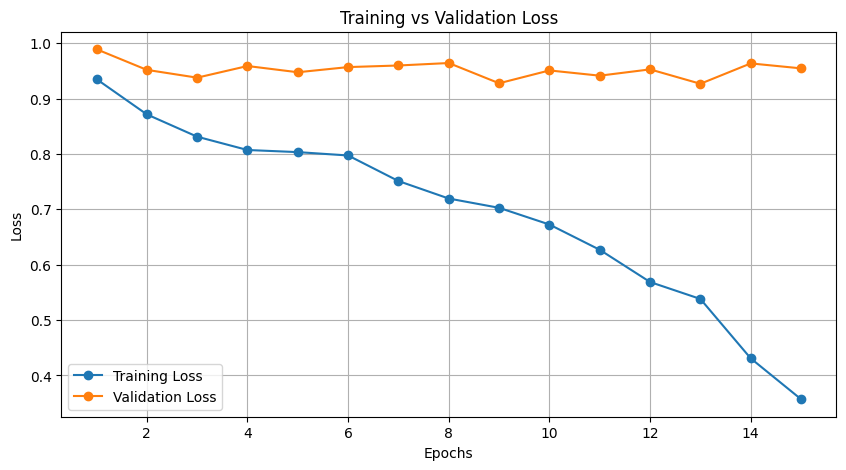

In [6]:
from __future__ import print_function, division
import os
import gc
import torch
import pandas as pd
from torch import nn
from torch.optim import Adam
import cv2
import matplotlib.pyplot as plt
import argparse,os
import numpy as np
import random
import math
from torchvision import transforms
import torch.nn as nn
from torch.nn.modules.utils import _triple
import pdb
from torch.utils.data import Dataset, DataLoader
import random
from sklearn.model_selection import train_test_split

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

num_epochs = 15
learning_rate = 1e-4

class Neg_Pearson(nn.Module):    # Pearson range [-1, 1] so if < 0, abs|loss| ; if >0, 1- loss
    def __init__(self):
        super(Neg_Pearson,self).__init__()
        return
    def forward(self, preds, labels):       # tensor [Batch, Temporal]
        loss = 0
        for i in range(preds.shape[0]):
            sum_x = torch.sum(preds[i])                # x
            sum_y = torch.sum(labels[i])               # y
            sum_xy = torch.sum(preds[i]*labels[i])        # xy
            sum_x2 = torch.sum(torch.pow(preds[i],2))  # x^2
            sum_y2 = torch.sum(torch.pow(labels[i],2)) # y^2
            N = preds.shape[1]
            pearson = (N*sum_xy - sum_x*sum_y)/(torch.sqrt((N*sum_x2 - torch.pow(sum_x,2))*(N*sum_y2 - torch.pow(sum_y,2))))

            if (pearson>=0).data.cpu().numpy():    # torch.cuda.ByteTensor -->  numpy
               loss += 1 - pearson
            else:
               loss += 1 - torch.abs(pearson)
            
        loss = loss/preds.shape[0]
        return loss

class PhysNet_padding_Encoder_Decoder_MAX(nn.Module):
    def __init__(self, frames = 960):  
        super(PhysNet_padding_Encoder_Decoder_MAX, self).__init__()
        
        self.ConvBlock1 = nn.Sequential(
            nn.Conv3d(3, 16, [1,5,5],stride=1, padding=[0,2,2]),
            nn.BatchNorm3d(16),
            nn.ReLU(inplace=True),
        )

        self.ConvBlock2 = nn.Sequential(
            nn.Conv3d(16, 32, [3, 3, 3], stride=1, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(inplace=True),
        )
        self.ConvBlock3 = nn.Sequential(
            nn.Conv3d(32, 64, [3, 3, 3], stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
        )
        
        self.ConvBlock4 = nn.Sequential(
            nn.Conv3d(64, 64, [3, 3, 3], stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
        )
        self.ConvBlock5 = nn.Sequential(
            nn.Conv3d(64, 64, [3, 3, 3], stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
        )
        self.ConvBlock6 = nn.Sequential(
            nn.Conv3d(64, 64, [3, 3, 3], stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
        )
        self.ConvBlock7 = nn.Sequential(
            nn.Conv3d(64, 64, [3, 3, 3], stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
        )
        self.ConvBlock8 = nn.Sequential(
            nn.Conv3d(64, 64, [3, 3, 3], stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
        )
        self.ConvBlock9 = nn.Sequential(
            nn.Conv3d(64, 64, [3, 3, 3], stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
        )
        
        self.upsample = nn.Sequential(
            nn.ConvTranspose3d(in_channels=64, out_channels=64, kernel_size=[4,1,1], stride=[2,1,1], padding=[1,0,0]),   #[1, 128, 32]
            nn.BatchNorm3d(64),
            nn.ELU(),
        )
        self.upsample2 = nn.Sequential(
            nn.ConvTranspose3d(in_channels=64, out_channels=64, kernel_size=[4,1,1], stride=[2,1,1], padding=[1,0,0]),   #[1, 128, 32]
            nn.BatchNorm3d(64),
            nn.ELU(),
        )
 
        self.ConvBlock10 = nn.Conv3d(64, 1, [1,1,1],stride=1, padding=0)
        
        self.MaxpoolSpa = nn.MaxPool3d((1, 2, 2), stride=(1, 2, 2))
        self.MaxpoolSpaTem = nn.MaxPool3d((2, 2, 2), stride=2)
        
        
        #self.poolspa = nn.AdaptiveMaxPool3d((frames,1,1))    # pool only spatial space 
        self.poolspa = nn.AdaptiveAvgPool3d((frames,1,1))

        
    def forward(self, x):	    	# x [3, T, 128,128]
        x_visual = x
        [batch,channel,length,width,height] = x.shape
          
        x = self.ConvBlock1(x)		     # x [3, T, 128,128]
        x = self.MaxpoolSpa(x)       # x [16, T, 64,64]
        
        x = self.ConvBlock2(x)		    # x [32, T, 64,64]
        x_visual6464 = self.ConvBlock3(x)	    	# x [32, T, 64,64]
        x = self.MaxpoolSpaTem(x_visual6464)      # x [32, T/2, 32,32]    Temporal halve
        
        x = self.ConvBlock4(x)		    # x [64, T/2, 32,32]
        x_visual3232 = self.ConvBlock5(x)	    	# x [64, T/2, 32,32]
        x = self.MaxpoolSpaTem(x_visual3232)      # x [64, T/4, 16,16]
        

        x = self.ConvBlock6(x)		    # x [64, T/4, 16,16]
        x_visual1616 = self.ConvBlock7(x)	    	# x [64, T/4, 16,16]
        x = self.MaxpoolSpa(x_visual1616)      # x [64, T/4, 8,8]

        x = self.ConvBlock8(x)		    # x [64, T/4, 8, 8]
        x = self.ConvBlock9(x)		    # x [64, T/4, 8, 8]
        x = self.upsample(x)		    # x [64, T/2, 8, 8]
        x = self.upsample2(x)		    # x [64, T, 8, 8]
        
        
        x = self.poolspa(x)     # x [64, T, 1,1]    -->  groundtruth left and right - 7 
        x = self.ConvBlock10(x) # x [1, T, 1,1]

        rPPG = x.view(-1, length) 
        
        return rPPG, x_visual, x_visual3232, x_visual1616

def load_video_frames_2(video_path, num_frames = 90, resize_shape=(128, 128)):
    frames = []
    detected_frame_count = 0
    
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        raise IOError(f"Error opening video file: {video_path}")
    
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    
    ret, frame = cap.read()
    if not ret:
        raise ValueError("Failed to read the first frame.")
    
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    faces = face_cascade.detectMultiScale(gray_frame, scaleFactor = 1.1, minNeighbors = 5, minSize = (30, 30))
    
    if len(faces) > 0:
        (x, y, w, h) = faces[0]
        face_region = frame[y:y+h, x:x+w]
        face_resized = cv2.resize(face_region, resize_shape)
        
        face_tensor = torch.from_numpy(face_resized).permute(2, 0, 1).unsqueeze(0).float() / 255.0
        frames.append(face_tensor)
        detected_frame_count += 1
    else:
        raise ValueError("No face detected in the first frame.")
    
    while detected_frame_count < num_frames:
        ret, frame = cap.read()
        if not ret:
            break
        
        face_region = frame[y:y+h, x:x+w]
        face_resized = cv2.resize(face_region, resize_shape)
        
        face_tensor = torch.from_numpy(face_resized).permute(2, 0, 1).unsqueeze(0).float() / 255.0
        frames.append(face_tensor)
        detected_frame_count += 1
    
    cap.release()
    
    if frames:
        frames_tensor = torch.cat(frames, dim=0)
        return frames_tensor, detected_frame_count
    else:
        raise ValueError("No faces detected in the video frames.")

class VideoDataset(Dataset):
    def __init__(self, video_paths, bvp_paths, resize_shape=(128, 128)):
        self.video_paths = video_paths
        self.bvp_paths = bvp_paths
        self.resize_shape = resize_shape
        
    def __len__(self):
        return len(self.video_paths)
    
    def __getitem__(self, idx):
        video_path = self.video_paths[idx]
        bvp_path = self.bvp_paths[idx]
        
        frames_tensor, detected_count = load_video_frames_2(video_path, resize_shape=self.resize_shape, num_frames=960)
        frames_tensor = frames_tensor.view(1, 3, detected_count, *self.resize_shape)
        
        bvp_df = pd.read_csv(bvp_path)
        BVP_label = torch.tensor(bvp_df["BVP"].values[:960], dtype=torch.float32).view(1, -1)
        BVP_label = (BVP_label - torch.mean(BVP_label)) / torch.std(BVP_label)
        
        return frames_tensor, BVP_label

video_paths = [rf"D:\UBFC\P-{l}\vid.avi" for l in range(1, 29)]
bvp_paths = [rf"D:\UBFC\P-{l}\BVP.csv" for l in range(1, 29)]

train_video_paths, val_video_paths, train_bvp_paths, val_bvp_paths = train_test_split(
    video_paths, bvp_paths, test_size = 0.2, random_state=42
)

train_dataset = VideoDataset(train_video_paths, train_bvp_paths)
val_dataset = VideoDataset(val_video_paths, val_bvp_paths)

batch_size = 1
num_workers = 0

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle = True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle = False, num_workers=num_workers)

model = PhysNet_padding_Encoder_Decoder_MAX(frames = 960)
model.train()
optimizer = Adam(model.parameters(), lr=learning_rate)

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    epoch_loss = 0 

    for inputs, BVP_label in train_loader:
        inputs = inputs.to(torch.float32).squeeze(0)
        BVP_label = BVP_label.to(torch.float32).squeeze(0)
        
        rPPG, _, _, _ = model(inputs)
        rPPG = rPPG[:, :BVP_label.shape[1]]

        rPPG = (rPPG - torch.mean(rPPG)) / torch.std(rPPG)
        
        neg_pearson_loss = Neg_Pearson()
        loss = neg_pearson_loss(rPPG, BVP_label)
        epoch_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(f"Loss for batch: {loss.item()}")

    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch + 1} average training loss: {epoch_loss / len(train_loader)}")

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, BVP_label in val_loader:
            inputs = inputs.to(torch.float32).squeeze(0)
            BVP_label = BVP_label.to(torch.float32).squeeze(0)

            rPPG, _, _, _ = model(inputs)
            rPPG = rPPG[:, :BVP_label.shape[1]]

            rPPG = (rPPG - torch.mean(rPPG)) / torch.std(rPPG)

            loss = neg_pearson_loss(rPPG, BVP_label)
            val_loss += loss.item()

            print(f"Loss for batch: {loss.item()}")

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch + 1} average validation loss: {val_loss / len(val_loader)}")

    model.train()

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', marker='o')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [ ]:
model_save_path = r"D:\UBFC\Trained Models\PhysNet_TrainValid.pth"
torch.save(model, model_save_path)
model = torch.load(model_save_path)
model.eval()

In [32]:
model = torch.load(model_save_path)
model.eval()

C:\Users\Vinod\AppData\Local\Temp\ipykernel_89308\1914305689.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model1 = torch.load(model_save_path)


PhysNet_padding_Encoder_Decoder_MAX(
  (ConvBlock1): Sequential(
    (0): Conv3d(3, 16, kernel_size=(1, 5, 5), stride=(1, 1, 1), padding=(0, 2, 2))
    (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (ConvBlock2): Sequential(
    (0): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (ConvBlock3): Sequential(
    (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (ConvBlock4): Sequential(
    (0): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (ConvBlock5): Sequential(
    

Processing video for subject 29
Test loss for video 29: 0.9929712414741516


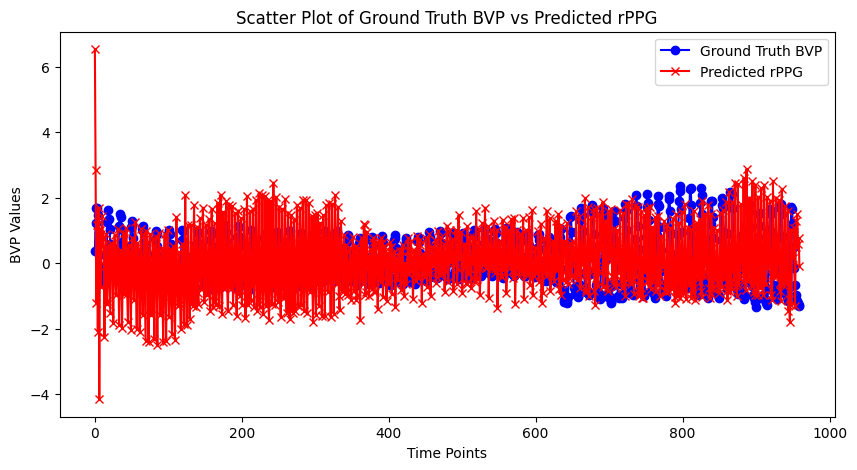

Processing video for subject 30
Test loss for video 30: 0.9874777793884277


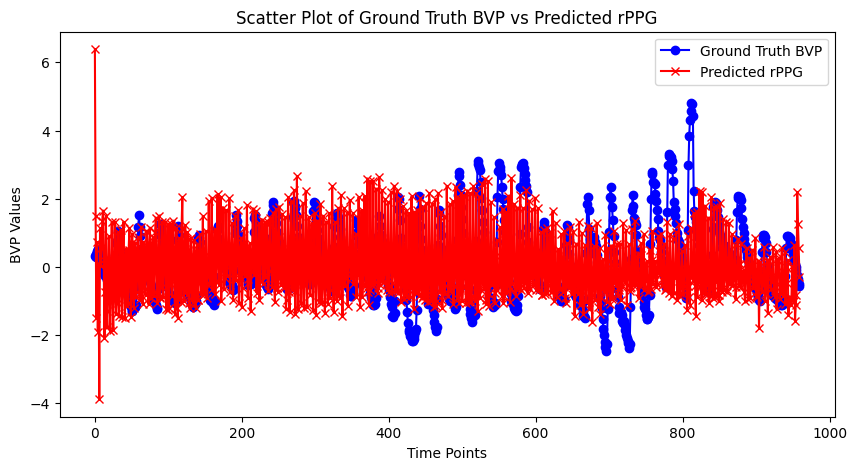

Processing video for subject 31
Test loss for video 31: 0.9682425856590271


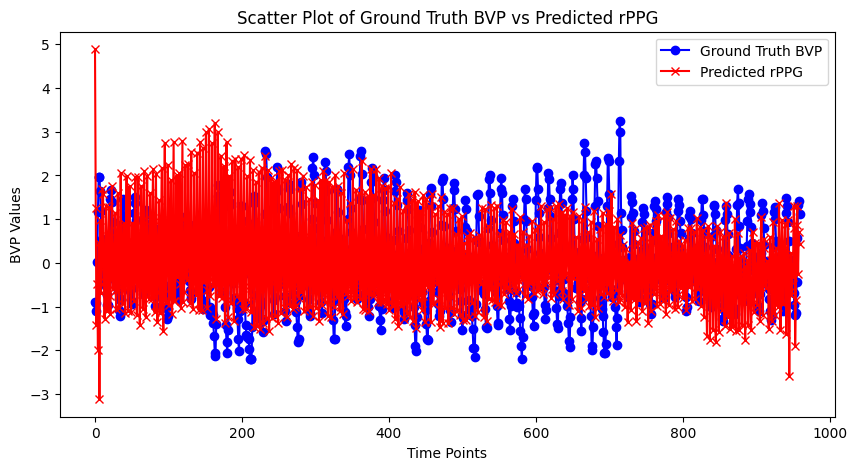

Processing video for subject 32
Test loss for video 32: 0.9983135461807251


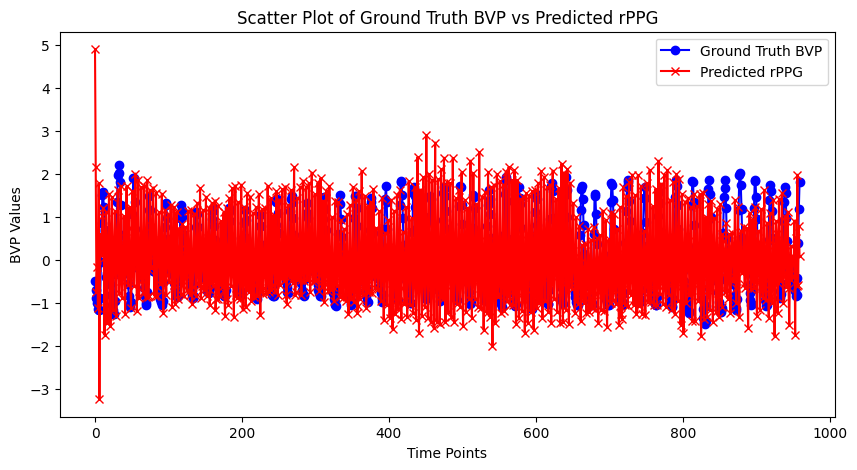

Processing video for subject 33
Test loss for video 33: 0.9858197569847107


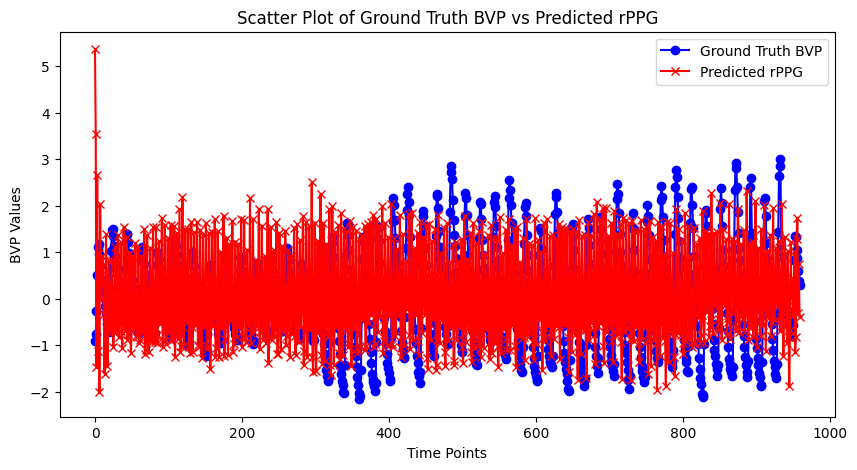

Processing video for subject 34
Test loss for video 34: 0.9859838485717773


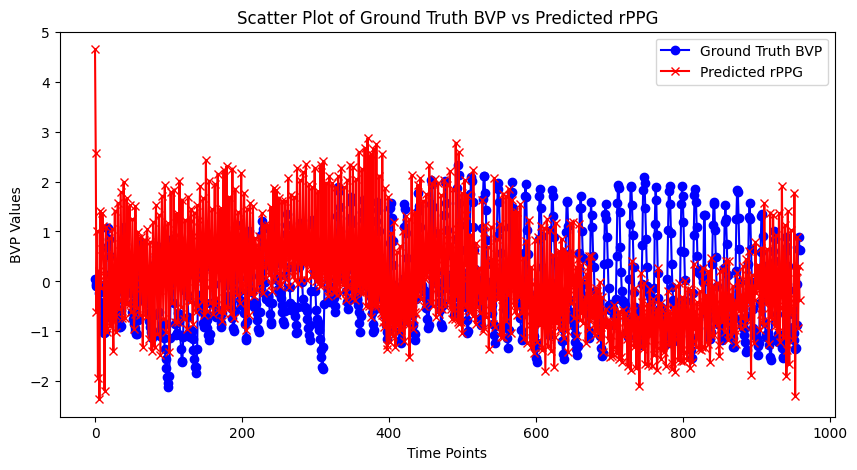

Processing video for subject 35
Test loss for video 35: 0.9981110692024231


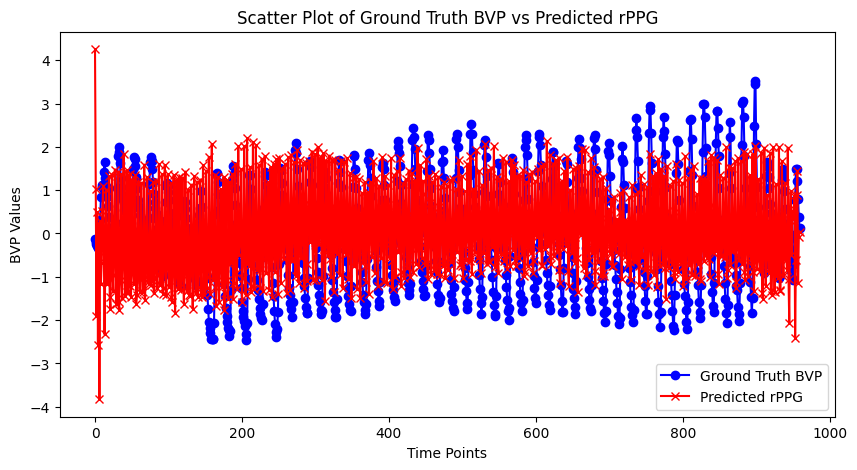

Processing video for subject 36
Test loss for video 36: 0.9986475706100464


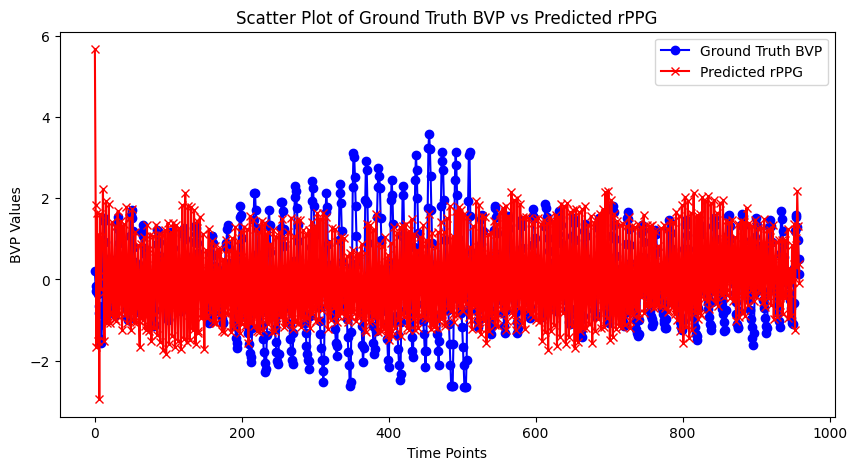

Processing video for subject 37
Test loss for video 37: 0.9876750111579895


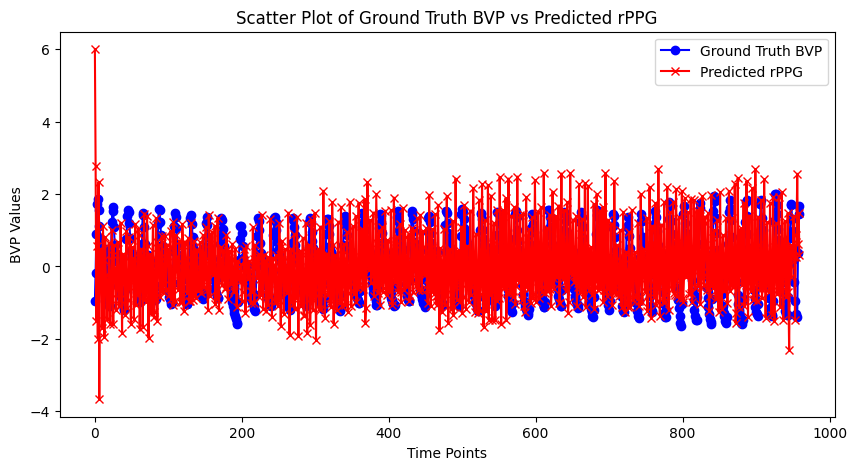

Processing video for subject 38
Test loss for video 38: 0.9744181036949158


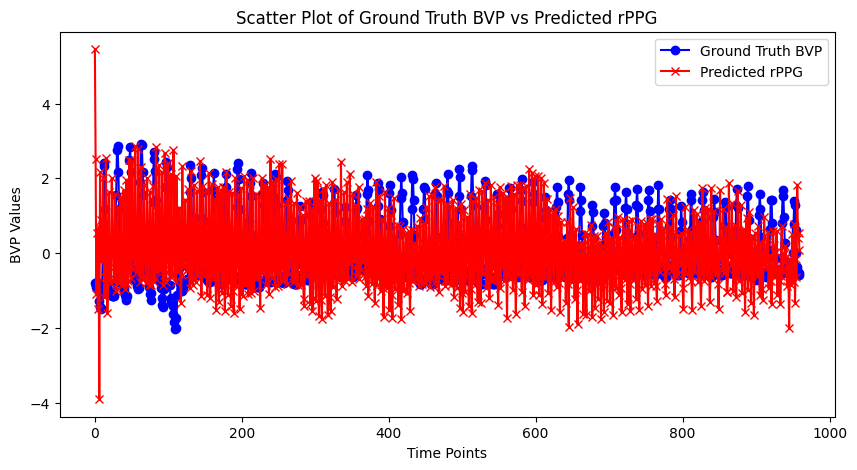

Processing video for subject 39
Test loss for video 39: 0.987614095211029


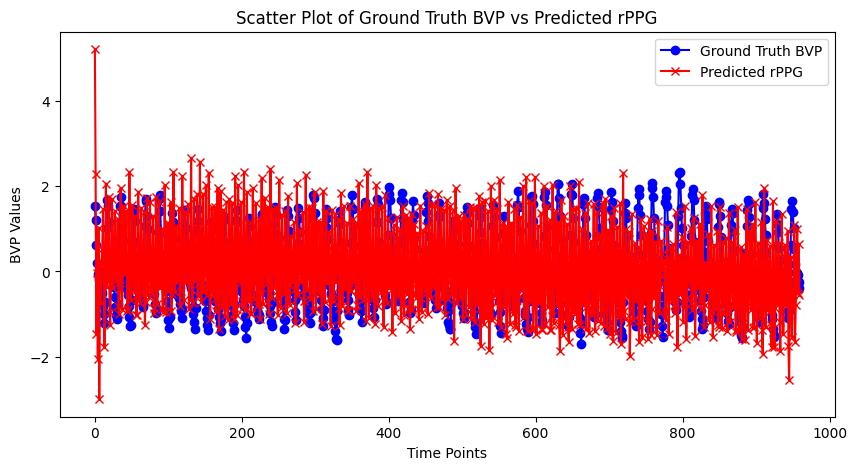

Processing video for subject 40


KeyboardInterrupt: 

In [34]:
import torch
import gc
import pandas as pd
import os
import torch.nn.functional as F

class Neg_Pearson(nn.Module):
    def __init__(self):
        super(Neg_Pearson, self).__init__()

    def forward(self, preds, labels):
        loss = 0
        for i in range(preds.shape[0]):
            sum_x = torch.sum(preds[i])
            sum_y = torch.sum(labels[i])
            sum_xy = torch.sum(preds[i] * labels[i])
            sum_x2 = torch.sum(torch.pow(preds[i], 2))
            sum_y2 = torch.sum(torch.pow(labels[i], 2))
            N = preds.shape[1]
            pearson = (N * sum_xy - sum_x * sum_y) / (torch.sqrt((N * sum_x2 - torch.pow(sum_x, 2)) * (N * sum_y2 - torch.pow(sum_y, 2))))

            if pearson >= 0:
                loss += 1 - pearson
            else:
                loss += 1 - torch.abs(pearson)
        
        loss = loss / preds.shape[0]
        return loss


criterion = Neg_Pearson()

total_loss = 0
num_videos = 0

for l in range(29, 43):
    if l not in [3, 4, 5, 6]:
        print(f"Processing video for subject {l}")
        try:
            video_filename = "vid.avi"
            target_directory = rf"D:\UBFC\P-{l}"
            video_path = os.path.join(target_directory, video_filename)
            inputs, detected_count = load_video_frames_2(video_path, num_frames=960)
            inputs = inputs.view(1, 3, detected_count, 128, 128)

            with torch.no_grad():
                rPPG, _, _, _ = model(inputs)

            rPPG = (rPPG - torch.mean(rPPG)) / torch.std(rPPG)
            rPPG_2 = rPPG.detach().numpy()

            df = pd.DataFrame({'Pulse': rPPG_2[0]})
            output_path = rf"D:\UBFC\P-{l}\PhysNet\BVP_AVI\BVP_Attempt_1Frame.csv"
            df.to_csv(output_path, index=False)

            ground_truth_path = rf"D:\UBFC\P-{l}\BVP.csv"
            
            try:
                ground_truth_df = pd.read_csv(ground_truth_path)
                ground_truth = torch.tensor(ground_truth_df['BVP'].values[:960], dtype=torch.float32).unsqueeze(0)
                loss = criterion(rPPG, ground_truth) 
                total_loss += loss.item()
                num_videos += 1
                print(f"Test loss for video {l}: {loss.item()}")
                
            except FileNotFoundError:
                print(f"No ground truth found for subject {l}, skipping loss calculation.")

            plt.figure(figsize=(10, 5))
            plt.plot(np.arange(len(ground_truth[0])), ground_truth.detach().numpy()[0], 
                        color='blue', label="Ground Truth BVP", marker='o')
            plt.plot(np.arange(len(rPPG[0])), rPPG_2[0], 
                        color='red', label="Predicted rPPG", marker='x')
            plt.title("Scatter Plot of Ground Truth BVP vs Predicted rPPG")
            plt.xlabel("Time Points")
            plt.ylabel("BVP Values")
            plt.legend()
            plt.show()
            
            del inputs, rPPG, rPPG_2
            gc.collect()
            torch.cuda.empty_cache()

        except (ValueError, OSError) as e:
            print(f"Error processing video for subject {l}: {e}")
            pass

if num_videos > 0:
    print(f"Average test loss across all processed videos: {total_loss / num_videos}")
else:
    print("No videos processed for loss calculation.")

In [36]:
for l in range(1, 43):
    # if(l!=3 and l!=4 and l!=5 and l!=6):
            print(l)
            try:
                    video_filename = "vid.avi"
                    target_directory = rf"D:\UBFC\P-{l}"
                    video_path = os.path.join(target_directory, video_filename)
                    inputs, detected_count = load_video_frames_2(video_path, num_frames = 960)
                    inputs = inputs.view(1, 3, detected_count, 128, 128)
      
                    with torch.no_grad():
                        rPPG, _, _, _ = model1(inputs)
    
                    rPPG = (rPPG - torch.mean(rPPG)) / torch.std(rPPG)
                    rPPG_2 = rPPG.detach().numpy()
                    df = pd.DataFrame({'Pulse': rPPG_2[0]})
                    df.to_csv(rf"D:\UBFC\P-{l}\PhysNet\BVP_AVI\BVP_Frame1_LowLoss.csv", index = False)
    
                    del inputs, rPPG, rPPG_2
                    gc.collect()
                    torch.cuda.empty_cache()
            except (ValueError, OSError) as e:
                print(e)
                pass

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42


In [14]:
from __future__ import print_function, division
import os
import gc
import torch
import pandas as pd
from torch import nn
from torch.optim import Adam
import cv2
import matplotlib.pyplot as plt
import argparse
import numpy as np
import random
import math
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from facenet_pytorch import MTCNN

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

num_epochs = 30
learning_rate = 5e-5

mtcnn = MTCNN(keep_all = False, device='cuda' if torch.cuda.is_available() else 'cpu')

class Neg_Pearson(nn.Module):    # Pearson range [-1, 1] so if < 0, abs|loss| ; if >0, 1- loss
    def __init__(self):
        super(Neg_Pearson,self).__init__()
        return
    def forward(self, preds, labels):       # tensor [Batch, Temporal]
        loss = 0
        for i in range(preds.shape[0]):
            sum_x = torch.sum(preds[i])                # x
            sum_y = torch.sum(labels[i])               # y
            sum_xy = torch.sum(preds[i]*labels[i])        # xy
            sum_x2 = torch.sum(torch.pow(preds[i],2))  # x^2
            sum_y2 = torch.sum(torch.pow(labels[i],2)) # y^2
            N = preds.shape[1]
            pearson = (N*sum_xy - sum_x*sum_y)/(torch.sqrt((N*sum_x2 - torch.pow(sum_x,2))*(N*sum_y2 - torch.pow(sum_y,2))))

            if (pearson>=0).data.cpu().numpy():    # torch.cuda.ByteTensor -->  numpy
               loss += 1 - pearson
            else:
               loss += 1 - torch.abs(pearson)
            
        loss = loss/preds.shape[0]
        return loss

class PhysNet_padding_Encoder_Decoder_MAX(nn.Module):
    def __init__(self, frames = 960):  
        super(PhysNet_padding_Encoder_Decoder_MAX, self).__init__()
        
        self.ConvBlock1 = nn.Sequential(
            nn.Conv3d(3, 16, [1,5,5],stride=1, padding=[0,2,2]),
            nn.BatchNorm3d(16),
            nn.ReLU(inplace=True),
        )

        self.ConvBlock2 = nn.Sequential(
            nn.Conv3d(16, 32, [3, 3, 3], stride=1, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(inplace=True),
        )
        self.ConvBlock3 = nn.Sequential(
            nn.Conv3d(32, 64, [3, 3, 3], stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
        )
        
        self.ConvBlock4 = nn.Sequential(
            nn.Conv3d(64, 64, [3, 3, 3], stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
        )
        self.ConvBlock5 = nn.Sequential(
            nn.Conv3d(64, 64, [3, 3, 3], stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
        )
        self.ConvBlock6 = nn.Sequential(
            nn.Conv3d(64, 64, [3, 3, 3], stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
        )
        self.ConvBlock7 = nn.Sequential(
            nn.Conv3d(64, 64, [3, 3, 3], stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
        )
        self.ConvBlock8 = nn.Sequential(
            nn.Conv3d(64, 64, [3, 3, 3], stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
        )
        self.ConvBlock9 = nn.Sequential(
            nn.Conv3d(64, 64, [3, 3, 3], stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
        )
        
        self.upsample = nn.Sequential(
            nn.ConvTranspose3d(in_channels=64, out_channels=64, kernel_size=[4,1,1], stride=[2,1,1], padding=[1,0,0]),   #[1, 128, 32]
            nn.BatchNorm3d(64),
            nn.ELU(),
        )
        self.upsample2 = nn.Sequential(
            nn.ConvTranspose3d(in_channels=64, out_channels=64, kernel_size=[4,1,1], stride=[2,1,1], padding=[1,0,0]),   #[1, 128, 32]
            nn.BatchNorm3d(64),
            nn.ELU(),
        )
 
        self.ConvBlock10 = nn.Conv3d(64, 1, [1,1,1],stride=1, padding=0)
        
        self.MaxpoolSpa = nn.MaxPool3d((1, 2, 2), stride=(1, 2, 2))
        self.MaxpoolSpaTem = nn.MaxPool3d((2, 2, 2), stride=2)
        
        
        #self.poolspa = nn.AdaptiveMaxPool3d((frames,1,1))    # pool only spatial space 
        self.poolspa = nn.AdaptiveAvgPool3d((frames,1,1))

        
    def forward(self, x):	    	# x [3, T, 128,128]
        x_visual = x
        [batch,channel,length,width,height] = x.shape
          
        x = self.ConvBlock1(x)		     # x [3, T, 128,128]
        x = self.MaxpoolSpa(x)       # x [16, T, 64,64]
        
        x = self.ConvBlock2(x)		    # x [32, T, 64,64]
        x_visual6464 = self.ConvBlock3(x)	    	# x [32, T, 64,64]
        x = self.MaxpoolSpaTem(x_visual6464)      # x [32, T/2, 32,32]    Temporal halve
        
        x = self.ConvBlock4(x)		    # x [64, T/2, 32,32]
        x_visual3232 = self.ConvBlock5(x)	    	# x [64, T/2, 32,32]
        x = self.MaxpoolSpaTem(x_visual3232)      # x [64, T/4, 16,16]
        

        x = self.ConvBlock6(x)		    # x [64, T/4, 16,16]
        x_visual1616 = self.ConvBlock7(x)	    	# x [64, T/4, 16,16]
        x = self.MaxpoolSpa(x_visual1616)      # x [64, T/4, 8,8]

        x = self.ConvBlock8(x)		    # x [64, T/4, 8, 8]
        x = self.ConvBlock9(x)		    # x [64, T/4, 8, 8]
        x = self.upsample(x)		    # x [64, T/2, 8, 8]
        x = self.upsample2(x)		    # x [64, T, 8, 8]
        
        
        x = self.poolspa(x)     # x [64, T, 1,1]    -->  groundtruth left and right - 7 
        x = self.ConvBlock10(x)    # x [1, T, 1,1]

        rPPG = x.view(-1, length) 
        
        return rPPG, x_visual, x_visual3232, x_visual1616

def load_video_frames_2(video_path, num_frames=160, resize_shape=(128, 128)):
    frames = []
    detected_frame_count = 0

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise IOError(f"Error opening video file: {video_path}")

    ret, frame = cap.read()
    if not ret:
        raise ValueError("Failed to read the first frame.")

    boxes, _ = mtcnn.detect(frame)
    if boxes is None:
        raise ValueError("No face detected in the first frame.")

    x, y, w, h = boxes[0]
    x, y, w, h = int(x), int(y), int(w - x), int(h - y)
    x, y, w, h = int(x - 0.3 * w), int(y - 0.3 * h), int(1.6 * w), int(1.6 * h)

    while detected_frame_count < num_frames:
        ret, frame = cap.read()
        if not ret:
            break
        
        face_region = frame[y:y+h, x:x+w]
        face_resized = cv2.resize(face_region, resize_shape)
        face_tensor = torch.from_numpy(face_resized).permute(2, 0, 1).unsqueeze(0).float() / 255.0
        frames.append(face_tensor)
        detected_frame_count += 1

    cap.release()
    
    if frames:
        frames_tensor = torch.cat(frames, dim=0)
        frames_tensor = frames_tensor.permute(1, 0, 2, 3)
        return frames_tensor, detected_frame_count
    else:
        raise ValueError("No faces detected in the video frames.")

def prepare_training_clips(video_path, bvp_path, resize_shape=(128, 128)):
    frames_tensor_list = []
    bvp_signal_list = []
    start_frame = 0
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    while start_frame + 160 <= total_frames:
        frames_tensor, _ = load_video_frames_2(video_path, num_frames=160, resize_shape=resize_shape)
        frames_tensor_list.append(frames_tensor)
        
        bvp_df = pd.read_csv(bvp_path)
        BVP_label = torch.tensor(bvp_df["BVP"].values[start_frame:start_frame+160], dtype=torch.float32)
        BVP_label = (BVP_label - torch.mean(BVP_label)) / torch.std(BVP_label)
        bvp_signal_list.append(BVP_label)
        
        start_frame += 30

    cap.release()
    return frames_tensor_list, bvp_signal_list

def prepare_testing_clips(video_path, bvp_path, resize_shape=(128, 128)):
    frames_tensor_list = []
    bvp_signal_list = []
    start_frame = 0
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    while start_frame + 160 <= total_frames:
        frames_tensor, _ = load_video_frames_2(video_path, num_frames=160, resize_shape=resize_shape)
        frames_tensor_list.append(frames_tensor)
        
        bvp_df = pd.read_csv(bvp_path)
        BVP_label = torch.tensor(bvp_df["BVP"].values[start_frame:start_frame+160], dtype=torch.float32)
        BVP_label = (BVP_label - torch.mean(BVP_label)) / torch.std(BVP_label)
        bvp_signal_list.append(BVP_label)
        
        start_frame += 160  
    cap.release()
    return frames_tensor_list, bvp_signal_list

class VideoDataset(Dataset):
    def __init__(self, video_paths, bvp_paths, mode='train', resize_shape=(128, 128)):
        self.video_paths = video_paths
        self.bvp_paths = bvp_paths
        self.resize_shape = resize_shape
        self.mode = mode
        
    def __len__(self):
        return len(self.video_paths)
    
    def __getitem__(self, idx):
        video_path = self.video_paths[idx]
        bvp_path = self.bvp_paths[idx]
        
        if self.mode == 'train':
            frames_tensor_list, bvp_signal_list = prepare_training_clips(video_path, bvp_path, resize_shape=self.resize_shape)
        else:
            frames_tensor_list, bvp_signal_list = prepare_testing_clips(video_path, bvp_path, resize_shape=self.resize_shape)

        return frames_tensor_list, bvp_signal_list

train_video_paths = [rf"D:\UBFC\P-{l}\vid.avi" for l in range(1, 29)]
train_bvp_paths = [rf"D:\UBFC\P-{l}\BVP.csv" for l in range(1, 29)]
test_video_paths = [rf"D:\UBFC\P-{l}\vid.avi" for l in range(29, 43)]
test_bvp_paths = [rf"D:\UBFC\P-{l}\BVP.csv" for l in range(29, 43)]

train_dataset = VideoDataset(train_video_paths, train_bvp_paths, mode='train')
test_dataset = VideoDataset(test_video_paths, test_bvp_paths, mode='test')

train_loader = DataLoader(train_dataset, batch_size = 1, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle=False)

model = PhysNet_padding_Encoder_Decoder_MAX(frames = 160)
model.train()
optimizer = Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    epoch_loss = 0 

    for frames_tensor_list, bvp_signal_list in train_loader:
        for inputs, BVP_label in zip(frames_tensor_list[0], bvp_signal_list[0]):
            inputs = inputs.to(torch.float32).unsqueeze(0)
            BVP_label = BVP_label.to(torch.float32)

            rPPG, _, _, _ = model(inputs)
            rPPG = rPPG[:, :BVP_label.shape[0]]
            rPPG = (rPPG - torch.mean(rPPG)) / torch.std(rPPG)
            
            neg_pearson_loss = Neg_Pearson()
            loss = neg_pearson_loss(rPPG, BVP_label)
            epoch_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            print(f"Loss for batch: {loss.item()}")

    print(f"Epoch {epoch + 1} average loss: {epoch_loss / len(train_loader)}")

C:\Users\Vinod\AppData\Roaming\Python\Python39\site-packages\facenet_pytorch\models\mtcnn.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(state_

Epoch 1/30
Loss for batch: 0.9999998211860657
Loss for batch: 0.9999998807907104
Loss for batch: 0.9999996423721313
Loss for batch: 0.9999998807907104
Loss for batch: 0.9999997019767761
Loss for batch: 0.9999999403953552
Loss for batch: 0.9999999403953552
Loss for batch: 0.9999997615814209
Loss for batch: 1.0
Loss for batch: 0.9999996423721313
Loss for batch: 0.9999997615814209
Loss for batch: 0.9999997615814209
Loss for batch: 0.9999998807907104
Loss for batch: 0.9999997615814209
Loss for batch: 0.9999998807907104
Loss for batch: 1.0
Loss for batch: 0.9999998211860657
Loss for batch: 0.9999998211860657
Loss for batch: 1.0
Loss for batch: 0.9999998807907104
Loss for batch: 0.9999994039535522
Loss for batch: 0.9999998807907104
Loss for batch: 0.9999998211860657
Loss for batch: 0.9999997615814209
Loss for batch: 0.9999998807907104
Loss for batch: 0.9999997019767761
Loss for batch: 0.9999997019767761
Loss for batch: 0.9999998807907104
Epoch 1 average loss: 0.9999998147998538
Epoch 2/30
Lo

KeyboardInterrupt: 

**LSTC-rPPG, Ergobike videos**

In [ ]:
%%time
from __future__ import print_function, division
import cv2
import torch
import torch.nn.functional as F
from torchvision import transforms
import torch.nn as nn
from torch.nn.modules.utils import _triple
import argparse, os
import pandas as pd
import numpy as np
import random
import math
import pdb
import gc

np.random.seed(42)

device = "cpu"

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

class LSTCrPPG(torch.nn.Module):
    def __init__(self, frames=32):
        super(LSTCrPPG, self).__init__()
        self.encoder_block = EncoderBlock()
        self.decoder_block = DecoderBlock()

    def forward(self, x):
        e = self.encoder_block(x)
        out = self.decoder_block(e)
        return out.squeeze()

class EncoderBlock(torch.nn.Module):
    def __init__(self):
        super(EncoderBlock, self).__init__()
        self.encoder_block1 = torch.nn.Sequential(
            ConvBlock3D(3, 16, [3, 3, 3], [1, 1, 1], [1, 1, 1]),
            ConvBlock3D(16, 16, [3, 3, 3], [1, 1, 1], [1, 1, 1]),
            torch.nn.BatchNorm3d(16)
        )
        self.encoder_block2 = torch.nn.Sequential(
            torch.nn.AvgPool3d(2),
            ConvBlock3D(16, 16, [3, 3, 3], [1, 1, 1], [1, 1, 1]),
            ConvBlock3D(16, 16, [3, 3, 3], [1, 1, 1], [1, 1, 1]),
            torch.nn.BatchNorm3d(16)
        )
        self.encoder_block3 = torch.nn.Sequential(
            torch.nn.AvgPool3d(2),
            ConvBlock3D(16, 32, [3, 3, 3], [1, 1, 1], [1, 1, 1]),
            ConvBlock3D(32, 32, [3, 3, 3], [1, 1, 1], [1, 1, 1]),
            torch.nn.BatchNorm3d(32)
        )
        self.encoder_block4 = torch.nn.Sequential(
            torch.nn.AvgPool3d(2),
            ConvBlock3D(32, 32, [3, 3, 3], [1, 1, 1], [1, 1, 1]),
            ConvBlock3D(32, 32, [3, 3, 3], [1, 1, 1], [1, 1, 1]),
            torch.nn.BatchNorm3d(32)
        )
        self.encoder_block5 = torch.nn.Sequential(
            torch.nn.AvgPool3d(2),
            ConvBlock3D(32, 64, [3, 3, 3], [1, 1, 1], [1, 1, 1]),
            ConvBlock3D(64, 64, [3, 3, 3], [1, 1, 1], [1, 1, 1]),
            torch.nn.BatchNorm3d(64)
        )
        self.encoder_block6 = torch.nn.Sequential(
            torch.nn.AvgPool3d(2),
            ConvBlock3D(64, 64, [3, 3, 3], [1, 1, 1], [1, 1, 1]),
            torch.nn.BatchNorm3d(64)
        )
        self.encoder_block7 = torch.nn.Sequential(
            ConvBlock3D(64, 64, kernel_size = [5, 3, 3], stride = [1, 1, 1], padding = [2, 1, 1]),
            torch.nn.BatchNorm3d(64)
        )

    def forward(self, x):
        e1 = self.encoder_block1(x)
        e2 = self.encoder_block2(e1)
        e3 = self.encoder_block3(e2)
        e4 = self.encoder_block4(e3)
        e5 = self.encoder_block5(e4)
        e6 = self.encoder_block6(e5)
        e7 = self.encoder_block7(e6)

        return [e7, e6, e5, e4, e3, e2, e1]

class DecoderBlock(torch.nn.Module):
    def __init__(self):
        super(DecoderBlock, self).__init__()
        self.decoder_block6_transpose = torch.nn.ConvTranspose3d(64, 64, [5, 1, 1], [1, 1, 1])
        self.decoder_block6 = torch.nn.Sequential(
            ConvBlock3D(64, 64, [3, 3, 3], [1, 1, 1], [1, 1, 1]),
            torch.nn.BatchNorm3d(64)
        )
        self.decoder_block5_transpose = torch.nn.ConvTranspose3d(64, 64, [4, 1, 1], [2, 1, 1])
        self.decoder_block5 = torch.nn.Sequential(
            ConvBlock3D(64, 32, [3, 3, 3], [1, 1, 1], [1, 1, 1]),
            ConvBlock3D(32, 32, [3, 3, 3], [1, 1, 1], [1, 1, 1]),
            torch.nn.BatchNorm3d(32)
        )
        self.decoder_block4_transpose = torch.nn.ConvTranspose3d(32, 32, [4, 1, 1], [2, 1, 1])
        self.decoder_block4 = torch.nn.Sequential(
            ConvBlock3D(32, 32, [3, 3, 3], [1, 1, 1], [1, 1, 1]),
            ConvBlock3D(32, 32, [3, 3, 3], [1, 1, 1], [1, 1, 1]),
            torch.nn.BatchNorm3d(32)
        )
        self.decoder_block3_transpose = torch.nn.ConvTranspose3d(32, 32, [4, 1, 1], [2, 1, 1])
        self.decoder_block3 = torch.nn.Sequential(
            ConvBlock3D(32, 16, [3, 3, 3], [1, 1, 1], [1, 1, 1]),
            ConvBlock3D(16, 16, [3, 3, 3], [1, 1, 1], [1, 1, 1]),
            torch.nn.BatchNorm3d(16)
        )
        self.decoder_block2_transpose = torch.nn.ConvTranspose3d(16, 16, [4, 1, 1], [2, 1, 1])
        self.decoder_block2 = torch.nn.Sequential(
            ConvBlock3D(16, 16, [3, 3, 3], [1, 1, 1], [1, 1, 1]),
            ConvBlock3D(16, 16, [3, 3, 3], [1, 1, 1], [1, 1, 1]),
            torch.nn.BatchNorm3d(16)
        )
        self.decoder_block1_transpose = torch.nn.ConvTranspose3d(16, 16, [4, 1, 1], [2, 1, 1])
        self.decoder_block1 = torch.nn.Sequential(
            ConvBlock3D(16, 3, [3, 3, 3], [1, 1, 1], [1, 1, 1]),
            ConvBlock3D(3, 3, [3, 3, 3], [1, 1, 1], [1, 1, 1]),
            torch.nn.BatchNorm3d(3)
        )
        self.predictor = torch.nn.Conv3d(3, 1, [1, 4, 4])

    def forward(self, encoded_feature):
        d6 = self.decoder_block6(self.TARM(encoded_feature[1], self.decoder_block6_transpose(encoded_feature[0])))
        d5 = self.decoder_block5(self.TARM(encoded_feature[2], self.decoder_block5_transpose(d6)))
        d4 = self.decoder_block4(self.TARM(encoded_feature[3], self.decoder_block4_transpose(d5)))
        d3 = self.decoder_block3(self.TARM(encoded_feature[4], self.decoder_block3_transpose(d4)))
        d2 = self.decoder_block2(self.TARM(encoded_feature[5], self.decoder_block2_transpose(d3)))
        d1 = self.decoder_block1(self.TARM(encoded_feature[6], self.decoder_block1_transpose(d2)))
        out = self.predictor(d1)
        
        return out

    def TARM(self, encoded_feature, decoded_feature):    
        if encoded_feature.shape[2:] != decoded_feature.shape[2:]:
            encoded_feature = F.interpolate(encoded_feature, size = decoded_feature.shape[2:], mode='trilinear', align_corners=False)
        
        difference = decoded_feature - encoded_feature
        difference = torch.cat([torch.abs(difference), torch.mul(encoded_feature, decoded_feature)], dim=1)
        atten = nn.Conv3d(difference.size(1), 1, 1, 1)(difference)
        atten = torch.sigmoid(atten)
    
        return torch.mul(atten, encoded_feature) + torch.mul(1 - atten, decoded_feature)

class ConvBlock3D(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size, stride, padding):
        super(ConvBlock3D, self).__init__()
        self.conv = nn.Conv3d(in_channel, out_channel, kernel_size, stride, padding)
        self.elu = nn.ELU()

    def forward(self, x):
        return self.elu(self.conv(x))

def frame_counter(video_path):
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    return frame_count

def load_video_frames(video_path, num_frames = 600, resize=(128, 128)):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while len(frames) < num_frames:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, resize)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)
    cap.release()
    frames = np.stack(frames)
    frames = frames.transpose((0, 3, 1, 2))
    return torch.tensor(frames, dtype=torch.float32) / 255.0

for l in range(1, 31):
    if(l != 3 and l != 4 and l != 5 and l != 6):
        # for u in range(1, 22):
            try:
                    video_filename = f"vid.avi"
                    target_directory = rf"D:\UBFC\P-{l}"
                    video_path = os.path.join(target_directory, video_filename)
                    fc = frame_counter(video_path)
                    model = LSTCrPPG(frames = fc)
                    video_frames = load_video_frames(video_path, num_frames = fc)
                    video_frames = video_frames.permute(1, 0, 2, 3)  # Change (batch_size, depth, channels, height, width) to (depth, batch_size, channels, height, width)
                    video_frames = video_frames.unsqueeze(0).to(device)
                    
                    with torch.no_grad():
                        rPPG = model(video_frames)
    
                    rPPG = (rPPG - torch.mean(rPPG)) / torch.std(rPPG)
                    rPPG_2 = rPPG.detach().numpy()
                    df = pd.DataFrame({'Pulse': rPPG_2})
                    df.to_csv(rf"D:\UBFC\P-{l}\LSTC-rPPG\BVP_AVI\BVP.csv", index=False)
    
                    del video_frames, rPPG, rPPG_2, fc
                    gc.collect()
                    torch.cuda.empty_cache()
            except (ValueError, OSError) as e:
                print(e)
                pass

**RhythmNet-Ergobike videos**

In [12]:
%%time
from __future__ import print_function, division
import cv2
import torch
import torch.nn.functional as F
from torchvision import transforms, models
import torch.nn as nn
from torch.nn.modules.utils import _triple
import argparse, os
import pandas as pd
import numpy as np
import random
import math
import pdb
import gc
import ssl

ssl._create_default_https_context = ssl._create_stdlib_context

np.random.seed(42)

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

'''
Backbone CNN for RhythmNet model is a RestNet-18
'''

class RhythmNet(nn.Module):
    def __init__(self):
        super(RhythmNet, self).__init__()

        # resnet o/p -> bs x 1000
        # self.resnet18 = resnet18(pretrained=False)
        resnet = models.resnet18(pretrained = False) 
        modules = list(resnet.children())[:-1]

        self.resnet18 = nn.Sequential(*modules)
        # The resnet average pool layer before fc
        # self.avgpool = nn.AvgPool2d((10, 1))
        self.resnet_linear = nn.Linear(512, 1000)
        self.fc_regression = nn.Linear(1000, 1)
        self.gru_fc_out = nn.Linear(1000, 1)
        self.rnn = nn.GRU(input_size=1000, hidden_size=1000, num_layers=1)
        # self.fc = nn.Linear(config.GRU_TEMPORAL_WINDOW, config.GRU_TEMPORAL_WINDOW)

    def forward(self, st_maps):
        batched_output_per_clip = []
        gru_input_per_clip = []
        hr_per_clip = []

        # Need to have so as to reflect a batch_size = 1 // if batched then comment out
        st_maps = st_maps.unsqueeze(0)
        for t in range(st_maps.size(1)):
            # with torch.no_grad():
            x = self.resnet18(st_maps[:, t, :, :, :])
            # collapse dimensions to BSx512 (resnet o/p)
            x = x.view(x.size(0), -1)
            # output dim: BSx1 and Squeeze sequence length after completing GRU step
            x = self.resnet_linear(x)
            # Save CNN features per clip for the GRU
            gru_input_per_clip.append(x.squeeze(0))

            # Final regression layer for CNN features -> HR (per clip)
            x = self.fc_regression(x)
            # normalize HR by frame-rate: 25.0 for VIPL
            x = x * 30.0
            batched_output_per_clip.append(x.squeeze(0))
            # input should be (seq_len, batch, input_size)

        # the features extracted from the backbone CNN are fed to a one-layer GRU structure.
        regression_output = torch.stack(batched_output_per_clip, dim=0).permute(1, 0)

        # Trying out GRU in addition to the regression now.
        gru_input = torch.stack(gru_input_per_clip, dim=0)
        gru_output, h_n = self.rnn(gru_input.unsqueeze(1))
        # gru_output = gru_output.squeeze(1)
        for i in range(gru_output.size(0)):
            hr = self.gru_fc_out(gru_output[i, :, :])
            hr_per_clip.append(hr.flatten())

        gru_output_seq = torch.stack(hr_per_clip, dim = 0).permute(1, 0)
        # return output_seq, gru_output.squeeze(0), fc_out
        return regression_output, gru_output_seq.squeeze(0) 

def frame_counter(video_path):
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    return frame_count

def load_video_frames(video_path, num_frames = 600, resize=(224, 224)):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while len(frames) < num_frames:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, resize)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)
    cap.release()
    frames = np.stack(frames)
    frames = frames.transpose((0, 3, 1, 2))  # reshape to (num_frames, 3, height, width)
    return torch.tensor(frames, dtype=torch.float32) / 255.0

for l in range(7, 31):
    if(l!=3 and l!=4 and l!=5 and l!=6):
        try:
                video_filename = "vid.avi"
                target_directory = rf"D:\UBFC\P-{l}"
                video_path = os.path.join(target_directory, video_filename)
                device = torch.device("cpu")
                model = RhythmNet()   
                model.to(device)
                fc = frame_counter(video_path)
                video_frames = load_video_frames(video_path, num_frames = fc)
    
                with torch.no_grad():
                    rPPG, GRU_rPPG = model(video_frames)

                rPPG = (rPPG - torch.mean(rPPG)) / torch.std(rPPG)  # normalize
                rPPG_2 = rPPG.detach().numpy()
                df = pd.DataFrame({'Pulse': rPPG_2[0]})
                df.to_csv(rf"D:\UBFC\P-{l}\RhythmNet\BVP_AVI\BVP.csv", index=False)

                del video_frames, rPPG, rPPG_2, fc
                gc.collect()
                torch.cuda.empty_cache
        except (ValueError, OSError) as e:
            print(e)
            pass

CPU times: total: 1h 40min 33s
Wall time: 17min 39s


**JAMSNet - Ergobike**

In [8]:
# %%time
import torch
from torchvision import transforms, models
import torchvision.transforms.functional as TF
import cv2
import argparse, os
import pandas as pd
import numpy as np
import random
import math
import pdb
import gc

device = "cpu"

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

def frame_counter(video_path):
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    return frame_count

def load_video_frames(video_path, num_frames = 600, resize=(192, 128)):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while len(frames) < num_frames:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, resize)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)
    cap.release()
    frames = np.stack(frames)
    frames = frames.transpose((3, 0, 1, 2)) 
    frames = np.expand_dims(frames, axis=0)
    return torch.tensor(frames, dtype=torch.float32) / 255.0

class JAMSNet(torch.nn.Module):
    def __init__(self):
        super(JAMSNet, self).__init__()
        self.cnn = torch.nn.Conv1d(1,1,1)
        self.f_1 = Feature_extraction()
        self.f_2 = Feature_extraction()
        self.f_3 = Feature_extraction()
        self.lwaf = LWAF()
        self.rPPG_extraction_net = rPPG_extraction_network()

    def forward(self,x):

        x = torch.permute(x, (0,2,1,3,4))
        x = self.gaussian_pyramid(x)
        x[0] = self.f_1(x[0])
        x[1] = self.f_2(x[1])
        x[2] = self.f_3(x[2])
        x = self.lwaf(x)
        x = self.rPPG_extraction_net(x)
        return x

    def gaussian_pyramid(self, video, num_levels=3):
        pyramid = []
        batch, length, channel, h, w = video.shape

        pyramid.append(video)

        for _ in range(num_levels -1):
            h = h//2
            w = w//2
            pyramid.append(torch.zeros(batch,length,channel, h, w).to(device))

        for i, frame in enumerate(video):
            for j in range(num_levels - 1):
                frame = TF.gaussian_blur(frame, kernel_size=3)
                frame = torch.nn.functional.interpolate(frame, scale_factor=0.5, mode='bilinear', align_corners=False, recompute_scale_factor = True)
                pyramid[j+1][i] = frame
        for i in range(len(pyramid)):
            pyramid[i] = pyramid[i]/255.
        return pyramid

class rPPG_extraction_network(torch.nn.Module):
    def __init__(self):
        super(rPPG_extraction_network, self).__init__()
        self.conv_1 = torch.nn.Conv3d(32, 64, kernel_size=(1, 5, 5), stride=(1, 1, 1), padding=0)
        self.bn_1 = torch.nn.BatchNorm3d(64)
        self.block_1 = rPPG_extraction_block(pool_kernel=[1,2,2],pool_stride=[1,2,2],pool_padding=[0,0,0])
        self.block_2 = rPPG_extraction_block(pool_kernel=[1,2,2],pool_stride=[1,2,2],pool_padding=[0,0,0])
        self.block_3 = rPPG_extraction_block(pool_kernel=[1,2,2],pool_stride=[1,2,2],pool_padding=[0,0,0])
        self.block_4 = rPPG_extraction_block(pool_kernel=[1,2,2],pool_stride=[1,2,2],pool_padding=[0,0,0])
        self.adapt_avg_pool3d = torch.nn.AdaptiveAvgPool3d(output_size=(150, 1, 1))
        self.conv_2 = torch.nn.Conv3d(64, 1, kernel_size=(1, 1, 1), stride=(1, 1, 1), padding=0)

    def forward(self,x):
        x = x.unsqueeze(0)
        x = x.permute(0, 2, 1, 3, 4)
        x = self.conv_1(x)
        x = self.bn_1(x)
        x = torch.nn.functional.elu(x)
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)
        x = self.adapt_avg_pool3d(x)
        x = self.conv_2(x)
        return x.view(-1,150)

class  rPPG_extraction_block(torch.nn.Module):
    def __init__(self,pool_kernel, pool_stride, pool_padding):
        super(rPPG_extraction_block, self).__init__()
        self.max_pool_1 = torch.nn.MaxPool3d(kernel_size=pool_kernel, stride=pool_stride,padding=pool_padding)
        self.conv_2 = torch.nn.Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=1)
        self.ctja = CTJA()
        self.bn_2 = torch.nn.BatchNorm3d(64)
        self.conv_3 = torch.nn.Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=1)
        self.stja = STJA()
        self.bn_3 = torch.nn.BatchNorm3d(64)
    def forward(self,x):
        x = self.max_pool_1(x)
        x = self.conv_2(x)
        x = self.ctja(x)
        x = self.bn_2(x)
        x = torch.nn.functional.elu(x)
        x = self.conv_3(x)
        x = self.stja(x)
        x = self.bn_3(x)
        x = torch.nn.functional.elu(x)
        return x

class Feature_extraction(torch.nn.Module):
    def __init__(self):
        super(Feature_extraction, self).__init__()
        self.conv_1 = torch.nn.Conv2d(3,32,(5,5),(1,1),0)
        self.bn_1 = torch.nn.BatchNorm2d(32)
        self.adaptive_avg_pool = torch.nn.AdaptiveAvgPool2d((48,32))
        self.conv_2 = torch.nn.Conv2d(32,32,(3,3),(1,1),(1,1))
        self.bn_2 = torch.nn.BatchNorm2d(32)
        self.conv_3 = torch.nn.Conv2d(32, 32, (3, 3), (1, 1), (1, 1))
        self.bn_3 = torch.nn.BatchNorm2d(32)
        self.STJA = STJA2D()

    def forward(self,x):
        _,_,C, H,W = x.shape
        x = torch.reshape(x, (-1,C, H, W))
        x = self.conv_1(x)
        x = self.bn_1(x)
        x = torch.nn.functional.elu(x)
        x = self.adaptive_avg_pool(x)
        x = self.conv_2(x)
        x = self.bn_2(x)
        x = torch.nn.functional.elu(x)
        x = self.conv_3(x)
        x = self.STJA(x)
        x = self.bn_3(x)
        x = torch.nn.functional.elu(x)
        return x

class LWAF(torch.nn.Module): # Layer-wise Attention Fusion
    def __init__(self):
        super(LWAF, self).__init__()
        self.conv = torch.nn.Conv2d(1,1,1,1,0)
        self.adaptive_avg_pool = torch.nn.AdaptiveAvgPool2d((48,32))
    def forward(self,x):
        L = torch.zeros((1, 1, 1, len(x))).to(device)
        L[:, :, :, 0] = torch.mean(x[0])
        L[:, :, :, 1] = torch.mean(x[1])
        L[:, :, :, 2] = torch.mean(x[2])
        L = self.conv(L)
        L = L.squeeze(0)
        L = torch.softmax(L, 1)   
        L = L.expand(x[0].size(0), -1, -1)
        L = L.unsqueeze(-1).unsqueeze(-1)
        x = x[0] * L[:, :, 0, :, :] + x[1] * L[:, :, 1, :, :] + x[2] * L[:, :, 2, :, :]
        x = self.adaptive_avg_pool(x)
        return x

class CTJA(torch.nn.Module):
    def __init__(self):
        super(CTJA, self).__init__()
        self.conv_D13 = torch.nn.Conv3d(1, 1, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1), dilation=(1, 1, 1))
        self.conv_D23 = torch.nn.Conv3d(1, 1, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 2, 2), dilation=(1, 2, 2))
        self.conv_D43 = torch.nn.Conv3d(1, 1, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 4, 4), dilation=(1, 4, 4))
        self.bn_1 = torch.nn.BatchNorm3d(3)
        self.conv_DW = torch.nn.Conv3d(3, 3, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=1, groups=3)
        self.conv_PW = torch.nn.Conv3d(3, 1, kernel_size=(1, 1, 1), stride=(1, 1, 1))
        self.bn_2 = torch.nn.BatchNorm3d(1)
    def forward(self,x):
        batch, channel, length, h,w = x.shape
        x_d = torch.mean(x,(3,4),True)
        x_d = x_d.permute(0,4,3,1,2)
        x_d = torch.stack([self.conv_D13(x_d),self.conv_D23(x_d),self.conv_D43(x_d)],0)
        x_d = x_d.squeeze(2).permute(1,0,2,3,4)
        x_d = self.bn_1(x_d)
        x_d = torch.nn.functional.elu(x_d)
        x_d = self.conv_DW(x_d)
        x_d = self.conv_PW(x_d)
        x_d = self.bn_2(x_d)
        x_d = torch.nn.functional.elu(x_d)
        x_d = torch.sigmoid(x_d)
        x_d = x_d.view(1,1,1,length*channel,1)
        x_d = x_d.permute(0,3,4,1,2)
        x_d = x_d.repeat(1,1,1,1,h * w)
        x = x.view(1, channel, length, 1, h*w)
        x = x.reshape(1, channel*length, 1, 1, h*w)
        x = x_d * x
        x = x.view(1, channel, length, 1, h* w)
        x = x.view(1,channel, length, h, w)
        return x

class STJA(torch.nn.Module):
    def __init__(self):
        super(STJA, self).__init__()
        self.temporal = STJA_Temporal()
        self.spatial = STJA_Spatial()

    def forward(self,x):
        batch, channel, length, h, w = x.shape
        x_t = self.temporal(x)
        x_s = self.spatial(x)
        x_t = x_t.repeat(1,1,1,h,w)
        x_st = x_s * x_t
        x_st = x_st.repeat(1,channel,1,1,1)
        return x * x_st

class STJA_Temporal(torch.nn.Module):
    def __init__(self):
        super(STJA_Temporal, self).__init__()
        self.conv = torch.nn.Conv3d(1,1,(1,1,1),1,0)
        self.bn = torch.nn.BatchNorm3d(1)

    def forward(self,x):
        x = torch.mean(x,(1,3,4),True)
        x = self.conv(x)
        x = self.bn(x)
        x = torch.nn.functional.elu(x)
        return torch.sigmoid(x)

class STJA_Spatial(torch.nn.Module):
    def __init__(self):
        super(STJA_Spatial, self).__init__()
        self.conv = torch.nn.Conv3d(1,1,(3,3,3),1,1)
        self.bn = torch.nn.BatchNorm3d(1)

    def forward(self,x):
        x = torch.mean(x,1,True)
        x = self.conv(x)
        x = self.bn(x)
        x = torch.nn.functional.elu(x)
        return torch.sigmoid(x)

class STJA2D(torch.nn.Module):
    def __init__(self):
        super(STJA2D, self).__init__()
        self.temporal = STJA2D_Temporal()
        self.spatial = STJA2D_Spatial()
    def forward(self,x):
        T, C, H, W = x.shape
        x_t = self.temporal(x)
        x_s = self.spatial(x)
        x_t = x_t.repeat(1,1,H,W)
        x_st = x_s * x_t
        x_st = x_st.repeat(1,C,1,1)
        return x * x_st

class STJA2D_Spatial(torch.nn.Module):
    def __init__(self):
        super(STJA2D_Spatial, self).__init__()
        self.conv = torch.nn.Conv2d(1,1,(3,3),stride=(1,1),padding=1)
        self.bn = torch.nn.BatchNorm2d(1)
    def forward(self,x):
        x = torch.mean(x, 1, True)
        x = self.conv(x)
        x = self.bn(x)
        x = torch.nn.functional.elu(x)
        return torch.sigmoid(x)

class STJA2D_Temporal(torch.nn.Module):
    def __init__(self):
        super(STJA2D_Temporal, self).__init__()
        self.conv = torch.nn.Conv2d(1,1,(1,1),(1,1),0)
        self.bn = torch.nn.BatchNorm2d(1)

    def forward(self,x):

        x = torch.mean(x,dim=(1,2,3),keepdim=True) # Dt 1/c*H*W
        x = self.conv(x)
        x = self.bn(x)
        x = torch.nn.functional.elu(x)
        return torch.sigmoid(x)

for l in range(1, 31):
    if(l!=3 and l!=4 and l!=5 and l!=6):
            try:
                    video_filename = "vid.avi"
                    target_directory = rf"D:\UBFC\P-{l}"
                    video_path = os.path.join(target_directory, video_filename)
                    device = torch.device("cpu")
                    model = JAMSNet()   
                    model.to(device)
                    fc = frame_counter(video_path)
                    video_frames = load_video_frames(video_path, num_frames = fc)
        
                    with torch.no_grad():
                        rPPG = model(video_frames)
    
                    rPPG = (rPPG - torch.mean(rPPG)) / torch.std(rPPG)  # normalize
                    rPPG_2 = rPPG.detach().numpy()
                    df = pd.DataFrame({'Pulse': rPPG_2[0]})
                    df.to_csv(rf"D:\UBFC\P-{l}\JAMSNet\BVP_AVI\BVP.csv", index=False)
    
                    del video_frames, rPPG, rPPG_2, fc
                    gc.collect()
                    torch.cuda.empty_cache
            except (ValueError, OSError) as e:
                print(e)
                pass

**BigSmall - Ergobike**

In [ ]:
# %%time
import torch
from torchvision import transforms, models
import torchvision.transforms.functional as TF
import cv2
import argparse, os
import pandas as pd
import numpy as np
import random
import math
import pdb
import gc

device = "cpu"

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

def frame_counter(video_path):
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    return frame_count

def load_video_frames(video_path, num_frames = 600, resize=(144, 144)):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while len(frames) < num_frames:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, resize)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)
    cap.release()
    frames = np.stack(frames)
    frames = frames.transpose((0, 3, 1, 2)) 
    return torch.tensor(frames, dtype=torch.float32) / 255.0

def calculate_difference_frames(frames):
    diff_frames = frames[:, :, 1:] - frames[:, :, :-1]
    diff_frames = torch.cat([torch.zeros_like(diff_frames[:, :, :1]), diff_frames], dim=2)
    return diff_frames

class TSM(torch.nn.Module):
    def __init__(self, time_length, fold_div=3):
        super().__init__()
        self.time_length = time_length
        self.fold_div = fold_div

    def forward(self, input):
        B, C, H, W = input.shape
        input = input.view(-1, self.time_length, C, H, W)

        fold = C // self.fold_div
        last_fold = C - (self.fold_div - 1) * fold

        out1, out2, out3 = torch.split(input, [fold, fold, last_fold], dim=2)

        up_out1 = torch.cat((torch.zeros((B//self.time_length, 1, fold, H, W)).to(device), out1[:, 1:, :, :, :]), dim=1)
        down_out2 = torch.cat((out2[:, :-1, :, :, :], torch.zeros((B//self.time_length, 1, fold, H, W)).to(device)), dim=1)
        bidirection_out = torch.cat((up_out1, down_out2, out3), dim=2).view(B, C, H, W)

        return bidirection_out

class BigSmall(torch.nn.Module):
    def __init__(self, time_length):
        super(BigSmall, self).__init__()
        self.time_length = time_length
        self.big_branch = BigBranch()
        self.small_branch = SmallBranch(self.time_length)
        self.hr_model = LinearModel()

    def forward(self, inputs):
        big_out = self.big_branch(inputs[0])
        small_out = self.small_branch(inputs[1])
        sum = big_out + small_out
        out = self.hr_model(sum)
        return out


class LinearModel(torch.nn.Module):
    def __init__(self, in_channel=5184):
        super().__init__()
        self.f_linear1 = torch.nn.Linear(in_channel, 128, bias=True)
        self.f_linear2 = torch.nn.Linear(128, 1, bias=True)

    def forward(self, input):
        f1 = torch.flatten(input, start_dim=1)
        f2 = torch.nn.functional.relu(self.f_linear1(f1))
        f3 = self.f_linear2(f2)
        return f3


class BigBranch(torch.nn.Module):
    def __init__(self):
        super(BigBranch, self).__init__()
        filters = [32, 32, 32, 64, 64, 64]
        pool_size = [2, 2, 4]
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=filters[0], kernel_size=3, padding=1)
        self.conv2 = torch.nn.Conv2d(in_channels=filters[0], out_channels=filters[1], kernel_size=3, padding=1)
        self.avg_pool1 = torch.nn.AvgPool2d(pool_size[0])
        self.conv3 = torch.nn.Conv2d(in_channels=filters[1], out_channels=filters[2], kernel_size=3, padding=1)
        self.conv4 = torch.nn.Conv2d(in_channels=filters[2], out_channels=filters[3], kernel_size=3, padding=1)
        self.avg_pool2 = torch.nn.AvgPool2d(pool_size[1])
        self.conv5 = torch.nn.Conv2d(in_channels=filters[3], out_channels=filters[4], kernel_size=3, padding=1)
        self.conv6 = torch.nn.Conv2d(in_channels=filters[4], out_channels=filters[5], kernel_size=3, padding=1)
        self.avg_pool3 = torch.nn.AvgPool2d(pool_size[2])

        self.drop_1 = torch.nn.Dropout2d(0.25)
        self.drop_2 = torch.nn.Dropout2d(0.5)

        self.relu = torch.nn.ReLU()

    def forward(self, x):
        B, C, H, W = x.shape
        n_frame = B
        x = x.view(-1, n_frame, C, H, W)
        x = x[:, 0, :, :, :]
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.avg_pool1(x)
        x = self.drop_1(x)
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.avg_pool2(x)
        x = self.drop_2(x)
        x = self.relu(self.conv5(x))
        x = self.relu(self.conv6(x))
        x = self.avg_pool3(x)
        x = self.drop_2(x)
        B, C, H, W = x.shape
        x = x.unsqueeze(1).expand(B, n_frame, C, H, W)
        x = torch.reshape(x, [-1, C, H, W])
        return x

class SmallBranch(torch.nn.Module):
    def __init__(self, time_length):
        super(SmallBranch, self).__init__()
        self.time_length = time_length
        
        filters = [32, 32, 32, 64] 
        
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=filters[0], kernel_size=3, padding=1)
        self.conv2 = torch.nn.Conv2d(in_channels=filters[0], out_channels=filters[1], kernel_size=3, padding=1)
        self.conv3 = torch.nn.Conv2d(in_channels=filters[1], out_channels=filters[2], kernel_size=3, padding=1)
        self.conv4 = torch.nn.Conv2d(in_channels=filters[2], out_channels=filters[3], kernel_size=3, padding=1)
        self.relu = torch.nn.ReLU()
        
        self.tsm1 = WTSM(time_length=self.time_length, fold_div=3)
        self.tsm2 = WTSM(time_length=self.time_length, fold_div=3)
        self.tsm3 = WTSM(time_length=self.time_length, fold_div=3)
        self.tsm4 = WTSM(time_length=self.time_length, fold_div=3)

        self.downsample = torch.nn.AdaptiveAvgPool2d((9, 9))

    def forward(self, x):
        s1 = self.relu(self.conv1(self.tsm1(x)))
        s2 = self.relu(self.conv2(self.tsm2(s1)))
        s3 = self.relu(self.conv3(self.tsm3(s2)))
        s4 = self.relu(self.conv4(self.tsm4(s3)))

        s4_downsampled = self.downsample(s4)

        return s4_downsampled

class WTSM(TSM):
    def forward(self, input):
        B, C, H, W = input.shape
        input = input.view(-1, self.time_length, C, H, W)

        fold = C // self.fold_div
        last_fold = C - (self.fold_div - 1) * fold

        out1, out2, out3 = torch.split(input, [fold, fold, last_fold], dim=2)

        up_out1 = torch.cat((out1[:, -1:, :, :, :], out1[:, :-1, :, :, :]), dim=1)
        donw_out2 = torch.cat((out2[:, 1:, :, :, :], out2[:, :1, :, :, :]), dim=1)
        wtsm_out = torch.cat((up_out1, donw_out2, out3), dim=2).view(B, C, H, W)

        return wtsm_out

for l in range(16, 31):
    if(l!=3 and l!=4 and l!=5 and l!=6):
        try:
                video_filename = "vid.avi"
                target_directory = rf"D:\UBFC\P-{l}"
            
                video_path = os.path.join(target_directory, video_filename)
                fc = frame_counter(video_path)
                device = torch.device("cpu")
                model = BigSmall(time_length = fc)  
                model.to(device)
                
                video_frames = load_video_frames(video_path, num_frames = fc)
                difference_frames = calculate_difference_frames(video_frames)
                inputs = (video_frames, difference_frames)
    
                with torch.no_grad():
                    rPPG = model(inputs)

                rPPG = (rPPG - torch.mean(rPPG)) / torch.std(rPPG)
                rPPG_2 = rPPG.detach().numpy()
                df = pd.DataFrame({'Pulse': rPPG_2[:, 0]})
                df.to_csv(rf"D:\UBFC\P-{l}\BigSmall\BVP_AVI\BVP.csv", index=False)

                del video_frames, rPPG, rPPG_2, fc
                gc.collect()
                torch.cuda.empty_cache
        except (ValueError, OSError) as e:
            print(e)
            pass

**EfficientPhys - Ergobike**

In [3]:
# %%time
import torch
import torch.nn as nn
from torchvision import transforms, models
import torchvision.transforms.functional as TF
import cv2
import argparse, os
import pandas as pd
import numpy as np
import random
import os
import math
import pdb
import gc

device = "cpu"

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

def frame_counter(video_path):
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    return frame_count

def load_video_frames(video_path, num_frames = 600, resize=(96, 96)):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while len(frames) < num_frames:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, resize)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)
    cap.release()
    frames = np.stack(frames)
    frames = frames.transpose((0, 3, 1, 2)) 
    return torch.tensor(frames, dtype=torch.float32) / 255.0

class Attention_mask(nn.Module):
    def __init__(self):
        super(Attention_mask, self).__init__()

    def forward(self, x):
        xsum = torch.sum(x, dim=2, keepdim=True)
        xsum = torch.sum(xsum, dim=3, keepdim=True)
        xshape = tuple(x.size())
        return x / xsum * xshape[2] * xshape[3] * 0.5

    def get_config(self):
        config = super(Attention_mask, self).get_config()
        return config


class TSM(nn.Module):
    def __init__(self, n_segment = 10, fold_div=3):
        super(TSM, self).__init__()
        self.n_segment = n_segment
        self.fold_div = fold_div

    def forward(self, x):
        nt, c, h, w = x.size()
        n_batch = nt // self.n_segment
        print(n_batch)
        print(self.n_segment)
        expected_size = n_batch * self.n_segment * c * h * w
        actual_size = x.numel()
        print(expected_size, actual_size)
        x = x.view(n_batch, self.n_segment, c, h, w)
        fold = c // self.fold_div
        out = torch.zeros_like(x)
        out[:, :-1, :fold] = x[:, 1:, :fold]  # shift left
        out[:, 1:, fold: 2 * fold] = x[:, :-1, fold: 2 * fold]  # shift right
        out[:, :, 2 * fold:] = x[:, :, 2 * fold:]  # not shift
        result = out.view(nt, c, h, w)        
        
        return result


class EfficientPhys(nn.Module):
    def __init__(self, in_channels=3, nb_filters1=32, nb_filters2=64, kernel_size=3, dropout_rate1=0.25,
                 dropout_rate2=0.5, pool_size=(2, 2), nb_dense=128, frame_depth=1, img_size=96, channel='diff'):
        super(EfficientPhys, self).__init__()
        self.in_channels = in_channels
        self.kernel_size = kernel_size
        self.dropout_rate1 = dropout_rate1
        self.dropout_rate2 = dropout_rate2
        self.pool_size = pool_size
        self.nb_filters1 = nb_filters1
        self.nb_filters2 = nb_filters2
        self.nb_dense = nb_dense

        self.TSM_1 = TSM(n_segment=frame_depth)
        self.TSM_2 = TSM(n_segment=frame_depth)
        self.TSM_3 = TSM(n_segment=frame_depth)
        self.TSM_4 = TSM(n_segment=frame_depth)
        self.motion_conv1 = nn.Conv2d(self.in_channels, self.nb_filters1, kernel_size=self.kernel_size, padding=(1, 1),
                                  bias=True)
        self.motion_conv2 = nn.Conv2d(self.nb_filters1, self.nb_filters1, kernel_size=self.kernel_size, bias=True)
        self.motion_conv3 = nn.Conv2d(self.nb_filters1, self.nb_filters2, kernel_size=self.kernel_size, padding=(1, 1),
                                  bias=True)
        self.motion_conv4 = nn.Conv2d(self.nb_filters2, self.nb_filters2, kernel_size=self.kernel_size, bias=True)

        self.apperance_att_conv1 = nn.Conv2d(self.nb_filters1, 1, kernel_size=1, padding=(0, 0), bias=True)
        self.attn_mask_1 = Attention_mask()
        self.apperance_att_conv2 = nn.Conv2d(self.nb_filters2, 1, kernel_size=1, padding=(0, 0), bias=True)
        self.attn_mask_2 = Attention_mask()
        # Avg pooling
        self.avg_pooling_1 = nn.AvgPool2d(self.pool_size)
        self.avg_pooling_2 = nn.AvgPool2d(self.pool_size)
        self.avg_pooling_3 = nn.AvgPool2d(self.pool_size)
        # Dropout layers
        self.dropout_1 = nn.Dropout(self.dropout_rate1)
        self.dropout_2 = nn.Dropout(self.dropout_rate1)
        self.dropout_3 = nn.Dropout(self.dropout_rate1)
        self.dropout_4 = nn.Dropout(self.dropout_rate2)

        if img_size == 36:
            self.final_dense_1 = nn.Linear(3136, self.nb_dense, bias=True)
        elif img_size == 72:
            self.final_dense_1 = nn.Linear(16384, self.nb_dense, bias=True)
        elif img_size == 96:
            self.final_dense_1 = nn.Linear(30976, self.nb_dense, bias=True)
        else:
            raise Exception('Unsupported image size')
        self.final_dense_2 = nn.Linear(self.nb_dense, 1, bias=True)
        self.batch_norm = nn.BatchNorm2d(3)
        self.channel = channel

    def forward(self, inputs, params=None):
        inputs = self.batch_norm(inputs)

        network_input = self.TSM_1(inputs)
        d1 = torch.tanh(self.motion_conv1(network_input))
        d1 = self.TSM_2(d1)
        d2 = torch.tanh(self.motion_conv2(d1))

        g1 = torch.sigmoid(self.apperance_att_conv1(d2))
        g1 = self.attn_mask_1(g1)
        gated1 = d2 * g1

        d3 = self.avg_pooling_1(gated1)
        d4 = self.dropout_1(d3)

        d4 = self.TSM_3(d4)
        d5 = torch.tanh(self.motion_conv3(d4))
        d5 = self.TSM_4(d5)
        d6 = torch.tanh(self.motion_conv4(d5))

        g2 = torch.sigmoid(self.apperance_att_conv2(d6))
        g2 = self.attn_mask_2(g2)
        gated2 = d6 * g2

        d7 = self.avg_pooling_3(gated2)
        d8 = self.dropout_3(d7)
        d9 = d8.reshape(d8.size(0), -1)
        d10 = torch.tanh(self.final_dense_1(d9))
        d11 = self.dropout_4(d10)
        out = self.final_dense_2(d11)

        return out

for l in range(1, 31):
    if(l!=3 and l!=4 and l!=5 and l!=6):
        try:
                video_filename = "vid.avi"
                target_directory = rf"D:\UBFC\P-{l}"
                video_path = os.path.join(target_directory, video_filename)
                device = torch.device("cpu")
                model = EfficientPhys()   
                model.to(device)
                fc = frame_counter(video_path)
                video_frames = load_video_frames(video_path, num_frames = fc)
    
                with torch.no_grad():
                    rPPG = model(video_frames)

                rPPG = (rPPG - torch.mean(rPPG)) / torch.std(rPPG)
                rPPG_2 = rPPG.detach().numpy()
                df = pd.DataFrame({'Pulse': rPPG_2[:, 0]})
                df.to_csv(rf"D:\UBFC\P-{l}\EfficientPhys\BVP_AVI\BVP.csv", index=False)

                del video_frames, rPPG, rPPG_2, fc
                gc.collect()
                torch.cuda.empty_cache
        except (ValueError, OSError) as e:
            print(e)
            pass

1547
1
42771456 42771456
1547
1
456228864 456228864
1547
1
109354336 109354336
1547
1
218708672 218708672
1801
1
49794048 49794048
1801
1
531136512 531136512
1801
1
127309088 127309088
1801
1
254618176 254618176
2024
1
55959552 55959552
2024
1
596901888 596901888
2024
1
143072512 143072512
2024
1
286145024 286145024
2031
1
56153088 56153088
2031
1
598966272 598966272
2031
1
143567328 143567328
2031
1
287134656 287134656
1989
1
54991872 54991872
1989
1
586579968 586579968
1989
1
140598432 140598432
1989
1
281196864 281196864
2018
1
55793664 55793664
2018
1
595132416 595132416
2018
1
142648384 142648384
2018
1
285296768 285296768
1993
1
55102464 55102464
1993
1
587759616 587759616
1993
1
140881184 140881184
1993
1
281762368 281762368
2020
1
55848960 55848960
2020
1
595722240 595722240
2020
1
142789760 142789760
2020
1
285579520 285579520
2020
1
55848960 55848960
2020
1
595722240 595722240
2020
1
142789760 142789760
2020
1
285579520 285579520
2046
1
56567808 56567808
2046
1
603389952 6033

**PEAK DETECTION ALGORITHM**

In [23]:
from scipy.signal import find_peaks, peak_prominences, peak_widths
import numpy as np

def peak_det_102(signal = [], fps = 30, win_size = 1.5):

    peaks_101 = []
    proms = []
    widths = []
    s = 0

    while win_size <= len(signal) / fps:
        x = 1.5
        t = 0

        window_signal = signal[int((win_size - x) * fps): int(win_size * fps)]

        peaks, _ = find_peaks(window_signal, height = 0)
        peaks_reverse, _ = find_peaks((window_signal * -1), height = 0)
        s += len(peaks)

        if len(peaks) == 0:
            win_size += x
            continue

        proms = peak_prominences(window_signal, peaks)[0]
        widths = peak_widths(window_signal, peaks, rel_height = 1)[0]

        if len(widths) == 0 or len(proms) == 0:
            win_size += x
            continue

        width_threshold = np.percentile(widths, 30)
        prominence_threshold = 0.25 * np.max(proms)

        peaks_2 = []

        for i in range(len(peaks)):
            if proms[i] < prominence_threshold or widths[i] < width_threshold:
                peaks_2.append(peaks[i])

        peaks_set = set(peaks)
        peaks_2_set = set(peaks_2)

        peaks_1_set = peaks_set - peaks_2_set
        peaks_1 = list(peaks_1_set)
        peaks_1.sort()

        for l in range(len(peaks_1)):
            peaks_1[l] += int((win_size - x) * fps)

        for l1 in range(len(peaks_reverse)):
            peaks_reverse[l1] += int((win_size - x) * fps)

        i = 0

        while i < len(peaks_1) - 1:
            if peaks_1[i + 1] - peaks_1[i] < 9:
                peaks_1.pop(i + 1)
            else:
                i += 1

        while t < len(peaks_1) - 1:
            start = peaks_1[t]
            end = peaks_1[t + 1]

            if any(start < value < end for value in peaks_reverse):
                t += 1
            else:
                peaks_1.pop(t + 1)

        win_size += x
        peaks_101.extend(peaks_1)

        u = 0

        while u < len(peaks_101) - 1:
            if peaks_101[u + 1] - peaks_101[u] < 9:
                peaks_101.pop(u + 1)
            else:
                u += 1
                
        while u < len(peaks_101) - 1:
            if peaks_101[u + 1] - peaks_101[u] > 45:
                peaks_101.pop(u)
            else:
                u += 1

    return peaks_101, proms, widths

**HEART RATE PREDICTION - PEAK DETECTION ALGORITHM**

In [ ]:
import os
import numpy as np
import pandas as pd
from scipy.signal import find_peaks, peak_prominences, peak_widths

algos = ["RTrPPG", "PhysNet", "LSTC-rPPG", "RhythmNet", "JAMSNet", "BigSmall", "EfficientPhys"]
algos_2 = ["LSTC-rPPG"]

for algo in algos_2:
    for l in range(1, 31):
        folder_path = rf'D:\UBFC\P-{l}\{algo}\BVP_AVI'
                    
        csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv') and 'BVP' in f]
        for csv_file in csv_files:
                csv_file_path = os.path.join(folder_path, csv_file)
                df = pd.read_csv(csv_file_path)
                        
                bpms = []
                proms_1 = []
                widths_1 = []
                        
                fps = 30
                win_size = 1.5
                        
                y = df["Pulse"]
                        
                t, p, w = peak_det_102(y, fps, win_size)
                proms_1.extend(p)
                widths_1.extend(w)
                        
                diffs = []
                        
                for x in range(len(t) - 1):
                    t[x] = int(t[x])
                    t[x + 1] = int(t[x + 1])
                    diff = t[x + 1] - t[x]
                    diffs.append(diff)
                        
                if diffs:
                    avg_peak_dist = np.mean(diffs)
                    bpm = round(1800 / avg_peak_dist)
                    if(bpm > 40):
                        bpms.append(bpm)
                    else:
                        bpms.append(40)
        
                output_file_path = os.path.join(rf"D:\UBFC\P-{l}\{algo}\BPM_AVI", f"BPM_{os.path.splitext(csv_file)[0][4:]}.csv")
                df2 = pd.DataFrame({"BPM": bpms})
                df2.to_csv(output_file_path, index=False)
                print(l)

**HEART RATE PREDICTION - BP Filter + PSD**

In [ ]:
import numpy as np
import pandas as pd
from scipy.signal import welch, butter, filtfilt
from scipy.signal.windows import hann, kaiser

def butter_bandpass(lowcut, highcut, fps = 30, order = 4):
    nyquist = 0.5 * fps
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fps = 30, order = 4):
    b, a = butter_bandpass(lowcut, highcut, fps, order = order)
    y = filtfilt(b, a, data)
    return y

algorithms = ["RTrPPG", "PhysNet", "LSTC-rPPG", "RhythmNet", "BigSmall", "EfficientPhys"]
algorithms_2 = ["JAMSNet"]

for algo in algorithms_2:
    for l in range(3, 4):
        for u in range(22, 34):
            try:
                df = pd.read_csv(rf"D:\HRV_New\Data\Dynamic\Ergobike\Algorithms\{algo}\P-{l}\BVP_20_AVI\BVP_Window_{u}.csv")
        
                a = df['Pulse'].shape[0]
        
                pulse_array = df['Pulse'].to_numpy()
        
                bvps = pulse_array.reshape(1, 1, a)
                
                e1 = butter_bandpass_filter(bvps, 0.7, 3.33, 30, 4)        
                
                fps = 30
                nperseg = 128
                noverlap = int(nperseg * 0.9)
                window = hann(int(nperseg))
                minHz = 0.75
                maxHz = 3.33
                F, P = welch(e1[0], nperseg = nperseg, noverlap = noverlap, fs = fps, window = window,  nfft = 512)
                F = F.astype(np.float32)
                P = P.astype(np.float32)
                band = np.argwhere((F > minHz) & (F < maxHz)).flatten()
                Pfreqs = 60 * F[band]
                Power = P[:, band]
                Pmax = np.argmax(Power, axis = 1)
                bpms = (np.round(Pfreqs[Pmax.squeeze()]))
                        
                df_hr = pd.DataFrame({'BPM':[bpms]})
                        
                df_hr.to_csv(rf"D:\HRV_New\Data\Dynamic\Ergobike\Algorithms\{algo}\P-{l}\BPM_20_AVI\BPM_Window_{u}.csv", index = False)
    
            except (ValueError, OSError) as e:
                print(e)
                pass

**Compiling BPM of all windows**

In [25]:
import pandas as pd
import os

algos = ["RTrPPG", "PhysNet", "LSTC-rPPG", "RhythmNet", "JAMSNet", "BigSmall", "EfficientPhys"]
algos_2 = ["LSTC-rPPG"]

for algo in algos:
    for l in range(1, 31):
        input_folder_path = rf'D:\UBFC\P-{l}\{algo}\BPM_AVI'
        output_file_path = rf'D:\UBFC\P-{l}\{algo}\BPM_AVI\Avg_BPM.csv'
        
        csv_files = [f for f in os.listdir(input_folder_path) if f.endswith('.csv') and 'BPM' in f and 'Avg_BPM' not in f]
                        
        results = []
                        
        for csv_file in csv_files:
            csv_file_path = os.path.join(input_folder_path, csv_file)
            df = pd.read_csv(csv_file_path)
                        
            avg_bpm = round(df['BPM'].mean(), 0)
                        
            video_name = csv_file.replace('BPM_Window_', '').replace('.csv', '')

            video_num = int(video_name)

            results.append({'Video': video_name, 'Algo': avg_bpm, 'Video_Num': video_num})
        
        results_df = pd.DataFrame(results)

        results_df = results_df.sort_values(by = 'Video_Num')
        
        results_df = results_df.drop(columns = ['Video_Num'])
                        
        results_df.to_csv(output_file_path, index=False)
        print(l)

KeyError: 'Video_Num'

In [ ]:
import numpy as np
from scipy.signal import find_peaks
import pandas as pd

ppg_data = pd.read_csv(r'E:\HRV_New\Data\Static\Algorithms\PhysNet\No Exercise\P-1\BVP_20_Filtered\BVP_Window_1.csv')

ppg_signal = ppg_data.values.flatten()

def dynamic_prominence(ppg_signal, scaling_factor=0.1):
    amplitude_range = np.max(ppg_signal) - np.min(ppg_signal)
    prominence = amplitude_range * scaling_factor
    return prominence

fps = 30
min_bpm = 45
estimated_prominence = dynamic_prominence(ppg_signal, scaling_factor=0.05)
distance = fps * 60/min_bpm

peaks, _ = find_peaks(ppg_signal, prominence = estimated_prominence, distance = distance)

print(f"Detected peaks at indices: {peaks}")

def calculate_ibi(peaks, fs):
    ibi = [(peaks[i] - peaks[i-1]) / fs for i in range(1, len(peaks))]
    return ibi

ibi = calculate_ibi(peaks, fps)
print(60/np.mean(ibi))

In [ ]:
import numpy as np
from scipy.signal import butter, filtfilt, find_peaks
import pandas as pd

for i in range(8, 9):
    for u in range(1, 21):
        ppg_data = pd.read_csv(rf'D:\HRV_New\Data\Dynamic + Static\Algorithms\BigSmall\P-{i}\BVP_20\BVP_Window_{u}.csv')

        ppg_signal = ppg_data.values.flatten()

        def bandpass_filter(ppg_signal, fs, lowcut=0.75, highcut = 3.33, order=2):
            nyquist = 0.5 * fs
            low = lowcut / nyquist
            high = highcut / nyquist
            b, a = butter(order, [low, high], btype='band')
            return filtfilt(b, a, ppg_signal)

        def detect_peaks(filtered_signal, distance=None):
            peaks, _ = find_peaks(filtered_signal, height = 0, distance = distance)
            return peaks

        def calculate_ibi(peaks, fs):
            ibi = [(peaks[i] - peaks[i-1]) / fs for i in range(1, len(peaks))]
            return ibi

        def ibi_estimation(ppg_signal, fs, lowcut = 0.75, highcut = 3.33, order=2, distance=None, prominence=None):
            filtered_signal = bandpass_filter(ppg_signal, fs, lowcut, highcut, order)

            peaks = detect_peaks(filtered_signal, distance = distance)

            ibi = calculate_ibi(peaks, fs)

            return ibi

        fs = 30

        ibi = ibi_estimation(ppg_signal, fs, lowcut = 0.75, highcut = 3.33, distance = fs * 0.6)
        print("HR:", int(60/np.mean(ibi)))

In [ ]:
import numpy as np
from scipy.signal import find_peaks, correlate
from scipy.fftpack import fft

def dynamic_prominence(ppg_signal, scaling_factor=0.1):
    amplitude_range = np.max(ppg_signal) - np.min(ppg_signal)
    prominence = amplitude_range * scaling_factor
    return prominence

def z_score_normalize(signal):
    return (signal - np.mean(signal)) / np.std(signal)

def compute_metrics(ppg_signal, fs = 30):
    metrics = {}
    
    metrics['mean'] = np.mean(ppg_signal)
    metrics['std_dev'] = np.std(ppg_signal)
    
    estimated_prominence = dynamic_prominence(ppg_signal, scaling_factor = 0.1)
    peaks, _ = find_peaks(ppg_signal)
    metrics['peak_count'] = len(peaks)
    
    metrics['energy'] = np.sum(ppg_signal**2)
    
    fft_vals = fft(ppg_signal)
    fft_freq = np.fft.fftfreq(len(ppg_signal), 1/fs)
    dominant_freq = fft_freq[np.argmax(np.abs(fft_vals))]
    metrics['dominant_frequency'] = np.abs(dominant_freq)
    
    return metrics

def compute_cross_correlation(signal_1, signal_2):
    correlation = correlate(signal_1, signal_2)
    max_corr = np.max(np.abs(correlation))
    return max_corr

for i in range(1, 2):
    for u in range(1, 16):  
        ppg_data_1 = pd.read_csv(rf'D:\HRV_New\Data\Dynamic + Static\Algorithms\PhysNet\P-5\BVP_20\BVP_Window_{u}.csv')
        ppg_data_2 = pd.read_csv(rf'D:\HRV_New\Data\Static\Algorithms\PhysNet\No Exercise\P-2\BVP_20\BVP_Window_{u}.csv')
        
        ppg_signal_1 = ppg_data_1.values.flatten()
        ppg_signal_2 = ppg_data_2.values.flatten()

        ppg_signal_1 = z_score_normalize(ppg_signal_1)
        ppg_signal_2 = z_score_normalize(ppg_signal_2)
        
        metrics_signal_1 = compute_metrics(ppg_signal_1)
        metrics_signal_2 = compute_metrics(ppg_signal_2)
        
        cross_correlation = compute_cross_correlation(ppg_signal_1, ppg_signal_2)
        auto_correlation = compute_cross_correlation(ppg_signal_1, ppg_signal_1)
        
        print(cross_correlation)
        print(auto_correlation)
        # print(metrics_signal_1, metrics_signal_2)

In [ ]:
import numpy as np
import pandas as pd
from scipy.signal import find_peaks, welch
from scipy.stats import entropy
import os

def signal_to_noise_ratio(signal):
    signal_power = np.mean(signal**2)
    noise_power = np.var(signal)
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

def root_mean_square(signal):
    return np.sqrt(np.mean(signal**2))

def spectral_entropy(signal, fs=30):
    freqs, psd = welch(signal, fs=fs)
    psd_norm = psd / np.sum(psd)
    return entropy(psd_norm)

def band_power(signal, fs = 30):
    freqs, psd = welch(signal, fs=fs)
    lf_band = np.trapz(psd[(freqs >= 0.04) & (freqs < 0.15)])
    hf_band = np.trapz(psd[(freqs >= 0.15) & (freqs < 0.4)])
    return lf_band, hf_band

def ppi_variability(signal):
    peaks, _ = find_peaks(signal)
    ppi = np.diff(peaks)
    return np.std(ppi)

def approximate_entropy(signal, m = 2, r = 0.2):
    N = len(signal)
    def _phi(m):
        x = np.array([signal[i:i+m] for i in range(N - m + 1)])
        C = np.sum(np.max(np.abs(x[:, np.newaxis] - x[np.newaxis, :]), axis=2) <= r, axis=0) / (N - m + 1)
        return np.sum(np.log(C)) / (N - m + 1)
    return abs(_phi(m) - _phi(m + 1))

def cross_spectral_density(signal_1, signal_2, fs = 30):
    f, Pxy = welch(signal_1, fs=fs, nperseg=256, return_onesided=False)
    _, Pyy = welch(signal_2, fs=fs, nperseg=256, return_onesided=False)
    return np.sum(Pxy * Pyy)

def compute_advanced_metrics(ppg_signal, fs = 30):
    metrics = {}
    
    metrics['SNR'] = signal_to_noise_ratio(ppg_signal)
    
    peaks, _ = find_peaks(ppg_signal, height = 0)
    metrics['Peak Count'] = len(peaks)

    fft_vals = fft(ppg_signal)
    fft_freq = np.fft.fftfreq(len(ppg_signal), 1/fs)
    dominant_freq = fft_freq[np.argmax(np.abs(fft_vals))]
    metrics['Dominant Frequency'] = np.abs(dominant_freq)
    
    metrics['RMS'] = root_mean_square(ppg_signal)
    
    metrics['Spectral_Entropy'] = spectral_entropy(ppg_signal, fs=fs)
    
    metrics['LF_Band_Power'], metrics['HF_Band_Power'] = band_power(ppg_signal, fs=fs)
    
    metrics['PPI_Variability'] = ppi_variability(ppg_signal)
    
    metrics['ApEn'] = approximate_entropy(ppg_signal)
    
    metrics = {k: round(v, 4) if k == 'HF_Band_Power' else round(v, 2) for k, v in metrics.items()}
 
    return metrics

def compute_cross_spectral_density(signal_1, signal_2, fs = 30):
    return cross_spectral_density(signal_1, signal_2, fs = fs)

for i in range(1, 2):
    for u in range(1, 16):
        ppg_data_1 = pd.read_csv(rf'D:\HRV_New\Data\Dynamic + Static\Algorithms\PhysNet\P-3\BVP_20\BVP_Window_{u}.csv')
        ppg_data_2 = pd.read_csv(rf'D:\HRV_New\Data\Static\Algorithms\PhysNet\No Exercise\P-1\BVP_20\BVP_Window_{u}.csv')
        
        ppg_signal_1 = ppg_data_1.values.flatten()
        ppg_signal_2 = ppg_data_2.values.flatten()

        metrics_signal_1 = compute_advanced_metrics(ppg_signal_1)
        metrics_signal_2 = compute_advanced_metrics(ppg_signal_2)
        
        combined_metrics_df = pd.DataFrame({
            'Metric': metrics_signal_1.keys(),
            'Signal 1': metrics_signal_1.values(),
            'Signal 2': metrics_signal_2.values()
        })

        combined_metrics_df.to_csv(rf'D:\HRV_New\Data\Pulse Signal Comparisons\Algorithms\PhysNet\Combined_Metrics_Vijay_{u}.csv', index=False)

**FOLDER CREATION**

In [ ]:
import os

algorithms = {"PhysNet", "RTrPPG", "LSTC-rPPG", "RhythmNet", "JAMSNet", "BigSmall", "EfficientPhys", "GREEN", "PCA", "PBV", "CHROM", "POS", "LGI", "OMIT"}
valid_folders = {f'P-{i}' for i in range(1, 43)}

for i in range(1, 43):
    for algo in algorithms: 
        parent_directory = rf"D:\UBFC\P-{i}\{algo}"
        
        if os.path.exists(parent_directory):
            new_folder_path = os.path.join(parent_directory, "BPM_AVI_pyVHR")
            
            if not os.path.exists(new_folder_path):
                os.mkdir(new_folder_path)
                print(f"Created folder: {new_folder_path}")
            else:
                print(f"Folder already exists: {new_folder_path}")
        else:
            print(f"Directory does not exist: {parent_directory}")

**UBFC GT BPM CALCULATION - BVP + PSD**

In [7]:
import pandas as pd
import numpy as np
from scipy.signal import welch, butter, filtfilt
from scipy.signal.windows import hann, kaiser

np.random.seed(0)

def butter_bandpass(lowcut, highcut, fps = 30, order = 6):
    nyquist = 0.5 * fps
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fps = 30, order = 6):
    b, a = butter_bandpass(lowcut, highcut, fps, order = order)
    y = filtfilt(b, a, data)
    return y

for i in range(1, 43):
        print(i)
        df = pd.read_csv(rf"D:\UBFC\P-{i}\BVP.csv")
        bvp_array = np.array(df["BVP"])
        filtered_bvp = butter_bandpass_filter(bvp_array, lowcut=0.7, highcut=4.0, fps=30)
        bvp_array = filtered_bvp.reshape(1, 1, bvp_array.shape[0])
        fps = 30
        nperseg = 210
        noverlap = int(nperseg * 0.9)
        window = hann(int(nperseg))
        minHz = 0.7
        maxHz = 4.0
        F, P = welch(bvp_array, fs = fps, nperseg = nperseg, noverlap = noverlap, window = window,  nfft = 512)
        F = F.astype(np.float32)
        P = P.astype(np.float32)
        band = np.argwhere((F > minHz) & (F < maxHz)).flatten()
        Pfreqs = 60 * F[band]
        Power = P[:, 0, band]
        Pmax = np.argmax(Power, axis = 1)
        bpms = [(np.round(Pfreqs[Pmax.squeeze()]))]
                
        df_hr = pd.DataFrame({'BPM':bpms})
                
        df_hr.to_csv(rf"D:\UBFC\P-{i}\GT_BVP_BPM_Fixed.csv", index = False)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42


**COMPILING BPMs FOR ALL PARTICIPANTS**

In [8]:
import os
import pandas as pd

base_dir = r"D:\UBFC"
output_csv = r"D:\UBFC\BPMs\GT_BPMs_2.csv"

bpm_values = []

for folder_num in range(1, 43):
    folder_name = f"P-{folder_num}"
    folder_path = os.path.join(base_dir, folder_name)
    
    csv_path = os.path.join(folder_path, "GT_BVP_BPM_Fixed.csv")
    
    if os.path.exists(csv_path):
        try:
            df = pd.read_csv(csv_path)
            if 'BPM' in df.columns and not df['BPM'].empty:
                bpm_value = df['BPM'].iloc[0]
                bpm_values.append(bpm_value)
        except Exception as e:
            print(f"Error reading {csv_path}: {e}")

bpm_df = pd.DataFrame(bpm_values, columns=['BPMs'])

bpm_df.index = range(1, len(bpm_df) + 1)

bpm_df.to_csv(output_csv, index = True)

**ALGORITHM PREDICTIONS COMPILATION**

In [2]:
import os
import pandas as pd

base_dir = r"D:\UBFC"

algos = {"GREEN", "PCA", "PBV", "CHROM", "POS", "LGI", "OMIT"}

for algo in algos:
    bpm_values = []
    for folder_num in range(1, 31):
        if(folder_num != 3 and folder_num != 4 and folder_num != 5 and folder_num != 6):
            folder_name = f"P-{folder_num}"
            folder_path = os.path.join(base_dir, folder_name)
            
            green_folder_path = os.path.join(folder_path, f"{algo}\BPM_AVI_pyVHR")
            
            csv_path = os.path.join(green_folder_path, "BPM_NoPreFilt.csv")
            
            if os.path.exists(green_folder_path) and os.path.exists(csv_path):
                try:
                    df = pd.read_csv(csv_path)
                    if 'Mean BPM' in df.columns and not df['Mean BPM'].empty:
                        bpm_value = df['Mean BPM'].iloc[0]
                        bpm_values.append(bpm_value)
                except Exception as e:
                    print(f"Error reading {csv_path}: {e}")
    
    bpm_df = pd.DataFrame(bpm_values, columns=[f'BPM_{algo}'])
    
    bpm_df.index = range(1, len(bpm_df) + 1)
    
    bpm_df.to_csv(rf"D:\UBFC\BPMs\BPMs_pyVHR_NoPreFilt_{algo}.csv", index=True)

**NN PSD**

In [83]:
import pandas as pd
import os
import numpy as np
from scipy.signal import welch
from inspect import getmembers, isfunction
from importlib import import_module
from pyVHR.extraction.sig_processing import *
from pyVHR.extraction.sig_extraction_methods import *
from pyVHR.extraction.skin_extraction_methods import *
from pyVHR.BVP.BVP import *
from pyVHR.BPM.BPM import *
from pyVHR.BPM.utils import Welch
from pyVHR.BVP.methods import *
from pyVHR.BVP.filters import *
from pyVHR.deepRPPG.mtts_can import *
from pyVHR.deepRPPG.hr_cnn import *
from pyVHR.extraction.utils import *
import matplotlib.pyplot as plt

class Pipeline_3():
    """ 
    This class performs post-filtering and BPM extraction on a pulse signal.
    """
    
    minHz = 0.70
    maxHz = 4.00

    def __init__(self):
        pass

    def process_pulse_signal(self, csv_file_name, winsize, fps):
        """ 
        Process the BVP signal from a CSV file and extract BPM.
        """
        sig_processing = SignalProcessing() 
        df = pd.read_csv(csv_file_name)
        bvp_signal = df["Pulse"].values
        bvp_signal = bvp_signal.reshape(1, 1, -1)

        module = import_module('pyVHR.BVP.filters')
        method_to_call = getattr(module, 'BPfilter')
        
        filtered_signal = apply_filter(bvp_signal, 
                                       method_to_call, 
                                       fps=fps, 
                                       params={'minHz': self.minHz, 
                                               'maxHz': self.maxHz, 
                                               'fps': 'adaptive', 
                                               'order': 6})
        
        bpmES = BVP_to_BPM(filtered_signal, fps, minHz=Pipeline_3.minHz, maxHz=Pipeline_3.maxHz)
        
        return filtered_signal, bpmES

pipeline = Pipeline_3()
for l in range(1, 31):
    if(l!=3 and l!=4 and l!=5 and l!=6):
        for i in range(1, 13):
            try:
                csv_file_name = rf'D:\UBFC\P-{l}\LSTC-rPPG\BVP_AVI\BVP_Clip_{i}.csv'
                window_size = 10
                fps = 30
                
                filtered_signal, estimated_bpm = pipeline.process_pulse_signal(csv_file_name, window_size, fps)
                # plt.plot(filtered_signal[0][0])
                print(np.round(estimated_bpm))
                df = pd.DataFrame({'BPM': np.round(estimated_bpm)})
                df.to_csv(rf"D:\UBFC\P-{l}\LSTC-rPPG\BPM_AVI\BPM_Clip_{i}.csv", index = False)
            except (ValueError, OSError) as e:
                print(e)
                pass
        print("\n -------------------------------------------------------- \n")

[224.]
[225.]
[43.]
[55.]
[225.]
[41.]
[112.]
[224.]
[225.]
[Errno 2] No such file or directory: 'D:\\UBFC\\P-1\\LSTC-rPPG\\BVP_AVI\\BVP_Clip_10.csv'
[Errno 2] No such file or directory: 'D:\\UBFC\\P-1\\LSTC-rPPG\\BVP_AVI\\BVP_Clip_11.csv'
[Errno 2] No such file or directory: 'D:\\UBFC\\P-1\\LSTC-rPPG\\BVP_AVI\\BVP_Clip_12.csv'

 -------------------------------------------------------- 

[112.]
[225.]
[225.]
[225.]
[225.]
[41.]
[112.]
[225.]
[226.]
[225.]
[111.]
[Errno 2] No such file or directory: 'D:\\UBFC\\P-2\\LSTC-rPPG\\BVP_AVI\\BVP_Clip_12.csv'

 -------------------------------------------------------- 

[224.]
[41.]
[225.]
[40.]
[42.]
[225.]
[108.]
[41.]
[225.]
[226.]
[225.]
[47.]

 -------------------------------------------------------- 

[224.]
[226.]
[226.]
[40.]
[225.]
[111.]
[112.]
[225.]
[44.]
[56.]
[224.]
[225.]

 -------------------------------------------------------- 

[222.]
[225.]
[225.]
[225.]
[40.]
[224.]
[225.]
[112.]
[41.]
[225.]
[225.]
[44.]

 -----------------

In [55]:
# !pip install mtcnn
# !pip install mediapipe
import cv2
import numpy as np
import torch
import torch.nn as nn
import mediapipe as mp
from mtcnn import MTCNN

mtcnn_detector = MTCNN()

mp_face_detection = mp.solutions.face_detection
face_detection = mp_face_detection.FaceDetection(min_detection_confidence = 0.9999)

class N3DED128(nn.Module):
    def __init__(self, frames=128):  
        super(N3DED128, self).__init__()

        self.Conv1 = nn.Sequential(
            nn.Conv3d(3, 16, [1,5,5],stride=1, padding=[0,2,2]),
            nn.BatchNorm3d(16),
            nn.ReLU(inplace=True),
        )

        self.Conv2 = nn.Sequential(
            nn.Conv3d(16, 32, [1,5,5],stride=1, padding=[0,2,2]),
            nn.BatchNorm3d(32),
            nn.ReLU(inplace=True),
        )

        self.Conv3 = nn.Sequential(
            nn.Conv3d(32, 64, [3, 3, 3], stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
        )

        self.Conv4 = nn.Sequential(
            nn.Conv3d(64, 64, [3, 3, 3], stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
        )
       
        self.TrConv1 = nn.Sequential(
            nn.ConvTranspose3d(in_channels=64, out_channels=64, kernel_size=[4,1,1], stride=[2,1,1], padding=[1,0,0]),   #[1, 128, 32]
            nn.BatchNorm3d(64),
            nn.ELU(),
        )
        self.TrConv2 = nn.Sequential(
            nn.ConvTranspose3d(in_channels=64, out_channels=64, kernel_size=[4,1,1], stride=[2,1,1], padding=[1,0,0]),   #[1, 128, 32]
            nn.BatchNorm3d(64),
            nn.ELU(),
        )
 
        self.ConvBlock5 = nn.Conv3d(64, 1, [1,1,1],stride=1, padding=0)
        self.MaxpoolSpaTem_244_244 = nn.MaxPool3d((2, 4, 4), stride=(2,4,4))
        self.poolspa = nn.AdaptiveAvgPool3d((frames,1,1))

        
    def forward(self, x): # [batch, Features=3, Temp=128, Width=128, Height=128]
        x = self.Conv1(x)		            # [b, F=3, T=128, W=128, H=128]->[b, F=16, T=128, W=128, H=128]
        x = self.MaxpoolSpaTem_244_244(x)   # [b, F=16, T=128, W=128, H=128]->[b, F=16, T=64, W=32, H=32]

        x = self.Conv2(x)		            # [b, F=16, T=64, W=32, H=32]->[b, F=32, T=64, W=32, H=32]
        x = self.MaxpoolSpaTem_244_244(x)   # [b, F=32, T=64, W=32, H=32]->[b, F=32, T=32, W=8, H=8]
        
        x = self.Conv3(x)		            # [b, F=32, T=32, W=8, H=8]->[b, F=64, T=32, W=8, H=8]
        
        x = self.Conv4(x)		            # [b, F=64, T=32, W=8, H=8]->[b, F=64, T=32, W=8, H=8]
        
        x = self.TrConv1(x)		            # [b, F=64, T=32, W=8, H=8]->[b, F=64, T=64, W=8, H=8]
        x = self.TrConv2(x)		            # [b, F=64, T=64, W=8, H=8]->[b, F=64, T=128, W=8, H=8]        
        x = self.poolspa(x)                 # [b, F=64, T=128, W=8, H=8]->[b, F=64, T=128, W=1, H=1]
        x = self.ConvBlock5(x)             # [b, F=64, T=128, W=1, H=1]->[b, F=1, T=128, W=1, H=1]
        
        rPPG = x.view(-1,x.shape[2])        # [b,128]
        return rPPG

# def extract_face(frame):
#     frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
#     results = mtcnn_detector.detect_faces(frame_rgb)
    
#     if results:
#         bbox = results[0]['box']
#         x1, y1, width, height = bbox
#         x2, y2 = x1 + width, y1 + height

#         face_image = frame[y1:y2, x1:x2]
#         return face_image
    
#     return frame

face_image_count = 0
frame_return_count = 0

def extract_face(frame):
    global face_image_count, frame_return_count

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    results = face_detection.process(frame_rgb)

    if results.detections:
        bboxC = results.detections[0].location_data.relative_bounding_box
        h, w, _ = frame.shape
        x1 = int(bboxC.xmin * w)
        y1 = int(bboxC.ymin * h)
        x2 = int((bboxC.xmin + bboxC.width) * w)
        y2 = int((bboxC.ymin + bboxC.height) * h)

        face_image = frame[y1:y2, x1:x2]
        face_image_count += 1
        return face_image
        
    frame_return_count += 1
    return frame  

def resize_image(face_image, size=(128, 128)):
    return cv2.resize(face_image, size, interpolation=cv2.INTER_AREA)

def preprocess_video(video_path, frames=128):
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    face_frames = []

    while cap.isOpened() and frame_count < frames:
        ret, frame = cap.read()
        if not ret:
            break
        
        face_image = extract_face(frame)

        resized_face = resize_image(face_image)

        normalized_face = resized_face / 255.0

        tensor_face = torch.tensor(normalized_face, dtype=torch.float32).permute(2, 0, 1)

        face_frames.append(tensor_face)

        frame_count += 1

    cap.release()

    if len(face_frames) < frames:
        padding = frames - len(face_frames)
        padding_tensor = torch.zeros((3, 128, 128), dtype=torch.float32)
        face_frames.extend([padding_tensor] * padding)

    input_tensor = torch.stack(face_frames)

    input_tensor = input_tensor.permute(1, 0, 2, 3)
    
    input_tensor = input_tensor.unsqueeze(0)

    return input_tensor

for l in range(1, 31):
    if(l!=3 and l!=4 and l!=5 and l!=6):
        # print(l)
        video_path = rf'D:\UBFC\P-{l}\vid.AVI' 
        
        cap = cv2.VideoCapture(video_path)
        fc = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        cap.release()
        
        input_tensor = preprocess_video(video_path, frames = fc)

        # print(f"Number of times face_image is returned: {face_image_count}")
        # print(f"Number of times frame is returned (no face detected): {frame_return_count}")
        
        model = N3DED128(frames = fc)
        output = model(input_tensor)
        output = output.detach().numpy()
        df = pd.DataFrame({'Pulse': output[0]})
        df.to_csv(rf'D:\UBFC\P-{l}\RTrPPG\BVP_AVI\BVP_Fixed.csv', index = False)

Number of times face_image is returned: 1547
Number of times frame is returned (no face detected): 0
Number of times face_image is returned: 3348
Number of times frame is returned (no face detected): 0
Number of times face_image is returned: 5372
Number of times frame is returned (no face detected): 0
Number of times face_image is returned: 7403
Number of times frame is returned (no face detected): 0
Number of times face_image is returned: 9392
Number of times frame is returned (no face detected): 0
Number of times face_image is returned: 11410
Number of times frame is returned (no face detected): 0
Number of times face_image is returned: 13403
Number of times frame is returned (no face detected): 0
Number of times face_image is returned: 15423
Number of times frame is returned (no face detected): 0
Number of times face_image is returned: 17443
Number of times frame is returned (no face detected): 0
Number of times face_image is returned: 19489
Number of times frame is returned (no fac

In [114]:
import cv2
import numpy as np
from mtcnn import MTCNN
from __future__ import print_function, division
import torch
import torch.nn.functional as F
from torchvision import transforms
import torch.nn as nn
from torch.nn.modules.utils import _triple
import argparse, os
import pandas as pd
import random
import math
import pdb
import gc
from scipy.signal import butter, filtfilt, welch

detector = MTCNN()

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

def bandpass_filter(signal, lowcut, highcut, fs, order = 6):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

def estimate_hr_from_rppg(rppg_signal, fs=30):
    filtered_rppg = bandpass_filter(rppg_signal, 0.7, 4, fs)
    nperseg = len(filtered_rppg)
    
    freqs, psd = welch(filtered_rppg, fs=fs, nperseg = nperseg)
    
    valid_idx = (freqs >= 0.9) & (freqs <= 2.4)
    dominant_freq = freqs[valid_idx][np.argmax(psd[valid_idx])]
    
    heart_rate_bpm = dominant_freq * 60
    
    return heart_rate_bpm, filtered_rppg

def preprocess_ubfc(video_path, frame_size = (128, 128), clip_length = 160):
    """
    Preprocess UBFC-rPPG video for testing as per LSTC-rPPG requirements.
    
    Args:
    - video_path: Path to the video file.
    - frame_size: Size of the resized frames (default: 128x128).
    - clip_length: Number of frames per clip (default: 160).
    
    Returns:
    - clips: A list of video clips (each of shape: clip_length x frame_size[0] x frame_size[1] x 3).
    """
    cap = cv2.VideoCapture(video_path)
    
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    ret, first_frame = cap.read()
    if not ret:
        print(f"Error reading the video file: {video_path}")
        return []
    
    first_frame_rgb = cv2.cvtColor(first_frame, cv2.COLOR_BGR2RGB)
    result = detector.detect_faces(first_frame_rgb)
    
    if len(result) == 0:
        print("No face detected in the first frame.")
        return []
    
    bbox = result[0]['box']
    x, y, w, h = bbox
    
    face_padding = int(0.6 * max(w, h))
    x_new = max(0, x - face_padding // 2)
    y_new = max(0, y - face_padding // 2)
    w_new = min(w + face_padding, first_frame.shape[1] - x_new)
    h_new = min(h + face_padding, first_frame.shape[0] - y_new)
    
    clips = []
    
    frames = []
    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)  # Reset to the start
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        face_roi = frame[y_new:y_new + h_new, x_new:x_new + w_new]
        
        resized_face = cv2.resize(face_roi, frame_size)
        
        frames.append(resized_face)
        
        if len(frames) == clip_length:
            clips.append(np.array(frames))
            frames = []
    
    cap.release()
    
    return clips

class LSTCrPPG_2(nn.Module):
    def __init__(self):
        super(LSTCrPPG_2, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv3d(3, 16, kernel_size=(3, 3, 3), padding=1),
            nn.ELU(),
            nn.Conv3d(16, 16, kernel_size=(3, 3, 3), padding=1),
            nn.ELU(),
            nn.AvgPool3d((2, 2, 2)),
            nn.Conv3d(16, 32, kernel_size=(3, 3, 3), padding=1),
            nn.ELU(),
            nn.Conv3d(32, 32, kernel_size=(3, 3, 3), padding=1),
            nn.ELU(),
            nn.AvgPool3d((2, 2, 2)),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose3d(32, 16, kernel_size=(4, 1, 1), stride=(2, 1, 1)),
            nn.ELU(),
            nn.Conv3d(16, 16, kernel_size=(3, 3, 3), padding=1),
            nn.ELU(),
            nn.Conv3d(16, 1, kernel_size=(1, 4, 4)),
        )

        self.predictor = nn.Conv3d(16, 1, kernel_size=(1, 4, 4))

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        output = self.predictor(decoded)
        return output

class LSTCrPPG(torch.nn.Module):
    def __init__(self, frames = 160):
        super(LSTCrPPG, self).__init__()
        self.encoder_block = EncoderBlock()
        self.decoder_block = DecoderBlock()

    def forward(self, x):
        e = self.encoder_block(x)
        out = self.decoder_block(e)
        return out.squeeze()

class EncoderBlock(torch.nn.Module):
    def __init__(self):
        super(EncoderBlock, self).__init__()
        self.encoder_block1 = torch.nn.Sequential(
            ConvBlock3D(3, 16, [3, 3, 3], [1, 1, 1], [1, 1, 1]),
            ConvBlock3D(16, 16, [3, 3, 3], [1, 1, 1], [1, 1, 1]),
            torch.nn.BatchNorm3d(16)
        )
        self.encoder_block2 = torch.nn.Sequential(
            torch.nn.AvgPool3d(2),
            ConvBlock3D(16, 16, [3, 3, 3], [1, 1, 1], [1, 1, 1]),
            ConvBlock3D(16, 16, [3, 3, 3], [1, 1, 1], [1, 1, 1]),
            torch.nn.BatchNorm3d(16)
        )
        self.encoder_block3 = torch.nn.Sequential(
            torch.nn.AvgPool3d(2),
            ConvBlock3D(16, 32, [3, 3, 3], [1, 1, 1], [1, 1, 1]),
            ConvBlock3D(32, 32, [3, 3, 3], [1, 1, 1], [1, 1, 1]),
            torch.nn.BatchNorm3d(32)
        )
        self.encoder_block4 = torch.nn.Sequential(
            torch.nn.AvgPool3d(2),
            ConvBlock3D(32, 32, [3, 3, 3], [1, 1, 1], [1, 1, 1]),
            ConvBlock3D(32, 32, [3, 3, 3], [1, 1, 1], [1, 1, 1]),
            torch.nn.BatchNorm3d(32)
        )
        self.encoder_block5 = torch.nn.Sequential(
            torch.nn.AvgPool3d(2),
            ConvBlock3D(32, 64, [3, 3, 3], [1, 1, 1], [1, 1, 1]),
            ConvBlock3D(64, 64, [3, 3, 3], [1, 1, 1], [1, 1, 1]),
            torch.nn.BatchNorm3d(64)
        )
        self.encoder_block6 = torch.nn.Sequential(
            torch.nn.AvgPool3d(2),
            ConvBlock3D(64, 64, [3, 3, 3], [1, 1, 1], [1, 1, 1]),
            torch.nn.BatchNorm3d(64)
        )
        self.encoder_block7 = torch.nn.Sequential(
            ConvBlock3D(64, 64, kernel_size = [5, 3, 3], stride = [1, 1, 1], padding = [2, 1, 1]),
            torch.nn.BatchNorm3d(64)
        )

    def forward(self, x):
        e1 = self.encoder_block1(x)
        e2 = self.encoder_block2(e1)
        e3 = self.encoder_block3(e2)
        e4 = self.encoder_block4(e3)
        e5 = self.encoder_block5(e4)
        e6 = self.encoder_block6(e5)
        e7 = self.encoder_block7(e6)

        return [e7, e6, e5, e4, e3, e2, e1]

class DecoderBlock(torch.nn.Module):
    def __init__(self):
        super(DecoderBlock, self).__init__()
        self.decoder_block6_transpose = torch.nn.ConvTranspose3d(64, 64, [5, 1, 1], [1, 1, 1])
        self.decoder_block6 = torch.nn.Sequential(
            ConvBlock3D(64, 64, [3, 3, 3], [1, 1, 1], [1, 1, 1]),
            torch.nn.BatchNorm3d(64)
        )
        self.decoder_block5_transpose = torch.nn.ConvTranspose3d(64, 64, [4, 1, 1], [2, 1, 1])
        self.decoder_block5 = torch.nn.Sequential(
            ConvBlock3D(64, 32, [3, 3, 3], [1, 1, 1], [1, 1, 1]),
            ConvBlock3D(32, 32, [3, 3, 3], [1, 1, 1], [1, 1, 1]),
            torch.nn.BatchNorm3d(32)
        )
        self.decoder_block4_transpose = torch.nn.ConvTranspose3d(32, 32, [4, 1, 1], [2, 1, 1])
        self.decoder_block4 = torch.nn.Sequential(
            ConvBlock3D(32, 32, [3, 3, 3], [1, 1, 1], [1, 1, 1]),
            ConvBlock3D(32, 32, [3, 3, 3], [1, 1, 1], [1, 1, 1]),
            torch.nn.BatchNorm3d(32)
        )
        self.decoder_block3_transpose = torch.nn.ConvTranspose3d(32, 32, [4, 1, 1], [2, 1, 1])
        self.decoder_block3 = torch.nn.Sequential(
            ConvBlock3D(32, 16, [3, 3, 3], [1, 1, 1], [1, 1, 1]),
            ConvBlock3D(16, 16, [3, 3, 3], [1, 1, 1], [1, 1, 1]),
            torch.nn.BatchNorm3d(16)
        )
        self.decoder_block2_transpose = torch.nn.ConvTranspose3d(16, 16, [4, 1, 1], [2, 1, 1])
        self.decoder_block2 = torch.nn.Sequential(
            ConvBlock3D(16, 16, [3, 3, 3], [1, 1, 1], [1, 1, 1]),
            ConvBlock3D(16, 16, [3, 3, 3], [1, 1, 1], [1, 1, 1]),
            torch.nn.BatchNorm3d(16)
        )
        self.decoder_block1_transpose = torch.nn.ConvTranspose3d(16, 16, [4, 1, 1], [2, 1, 1])
        self.decoder_block1 = torch.nn.Sequential(
            ConvBlock3D(16, 3, [3, 3, 3], [1, 1, 1], [1, 1, 1]),
            ConvBlock3D(3, 3, [3, 3, 3], [1, 1, 1], [1, 1, 1]),
            torch.nn.BatchNorm3d(3)
        )
        self.predictor = torch.nn.Conv3d(3, 1, [1, 4, 4])

    def forward(self, encoded_feature):
        d6 = self.decoder_block6(self.TARM(encoded_feature[1], self.decoder_block6_transpose(encoded_feature[0])))
        d5 = self.decoder_block5(self.TARM(encoded_feature[2], self.decoder_block5_transpose(d6)))
        d4 = self.decoder_block4(self.TARM(encoded_feature[3], self.decoder_block4_transpose(d5)))
        d3 = self.decoder_block3(self.TARM(encoded_feature[4], self.decoder_block3_transpose(d4)))
        d2 = self.decoder_block2(self.TARM(encoded_feature[5], self.decoder_block2_transpose(d3)))
        d1 = self.decoder_block1(self.TARM(encoded_feature[6], self.decoder_block1_transpose(d2)))
        out = self.predictor(d1)
        
        return out

    def TARM(self, encoded_feature, decoded_feature):    
        if encoded_feature.shape[2:] != decoded_feature.shape[2:]:
            encoded_feature = F.interpolate(encoded_feature, size = decoded_feature.shape[2:], mode='trilinear', align_corners=False)
        
        difference = decoded_feature - encoded_feature
        difference = torch.cat([torch.abs(difference), torch.mul(encoded_feature, decoded_feature)], dim=1)
        atten = nn.Conv3d(difference.size(1), 1, 1, 1)(difference)
        atten = torch.sigmoid(atten)
    
        return torch.mul(atten, encoded_feature) + torch.mul(1 - atten, decoded_feature)

class ConvBlock3D(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size, stride, padding):
        super(ConvBlock3D, self).__init__()
        self.conv = nn.Conv3d(in_channel, out_channel, kernel_size, stride, padding)
        self.elu = nn.ELU()

    def forward(self, x):
        return self.elu(self.conv(x))

for l in range(1, 43):
    if l not in [3, 4, 5, 6]:
        print(f"Processing subject {l}")
        try:
            video_filename = "vid.AVI"
            target_directory = rf"D:\UBFC\P-{l}"
            video_path = os.path.join(target_directory, video_filename)
            video_frames = preprocess_ubfc(video_path)
            model = LSTCrPPG(frames = 160)

            hr_values = []

            for idx, clip in enumerate(video_frames):
                clip = np.transpose(clip, (3, 0, 1, 2))
                clip_tensor = torch.tensor(clip, dtype=torch.float32).unsqueeze(0).to(device)

                with torch.no_grad():
                    rPPG = model(clip_tensor)
                
                rPPG_2 = rPPG.cpu().detach().numpy()
                estimated_hr, filtered_rppg = estimate_hr_from_rppg(rPPG_2)

                df = pd.DataFrame({'Pulse': filtered_rppg})
                df.to_csv(rf"D:\UBFC\P-{l}\LSTC-rPPG\BVP_AVI\BVP_Clip_{idx + 1}.csv", index=False)
                
                hr_df = pd.DataFrame({'Clip': [idx + 1], 'Estimated HR (BPM)': [np.round(estimated_hr)]})
                print(f"Clip {idx + 1} Estimated HR (BPM): {np.round(estimated_hr)}")
                hr_df.to_csv(rf"D:\UBFC\P-{l}\LSTC-rPPG\BPM_AVI\BPM_Clip_{idx + 1}.csv", index=False)

                hr_values.append(np.round(estimated_hr))

                del clip_tensor, rPPG, rPPG_2
                gc.collect()
                torch.cuda.empty_cache()

            mean_hr = np.round(np.mean(hr_values))
            print(f"Mean HR for subject {l}: {mean_hr:.2f} BPM")
            
        except (ValueError, OSError) as e:
            print(f"Error processing subject {l}: {e}")
            pass

Processing subject 1


RuntimeError: Given groups=1, weight of size [1, 16, 1, 4, 4], expected input[1, 1, 82, 29, 29] to have 16 channels, but got 1 channels instead

In [108]:
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt, welch

def bandpass_filter(signal, lowcut, highcut, fs, order = 6):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

def estimate_hr_from_rppg(rppg_signal, fs = 24):
    filtered_rppg = bandpass_filter(rppg_signal, 0.65, 4, fs)
    nperseg = len(filtered_rppg)
    freqs, psd = welch(filtered_rppg, fs=fs, nperseg=nperseg)

    valid_idx = (freqs >= 0.65) & (freqs <= 4.0)
    dominant_freq = freqs[valid_idx][np.argmax(psd[valid_idx])]
    
    heart_rate_bpm = dominant_freq * 60
    return heart_rate_bpm, filtered_rppg

for l in range(20, 23):
    bvp_data_path = rf"D:\UBFC\P-{l}\BVP.csv"
    bvp_df = pd.read_csv(bvp_data_path)
    
    bvp_signal = bvp_df["BVP"].values
    
    chunk_size = 160
    for start in range(0, len(bvp_signal), chunk_size):
        end = start + chunk_size
        chunk = bvp_signal[start:end]
        
        if len(chunk) == chunk_size:
            estimated_hr, filtered_rppg = estimate_hr_from_rppg(chunk)
            print(f"Chunk {start + 1} to {end}: Estimated HR = {estimated_hr:.0f} BPM")

Chunk 1 to 160: Estimated HR = 101.25 BPM
Chunk 161 to 320: Estimated HR = 101.25 BPM
Chunk 321 to 480: Estimated HR = 101.25 BPM
Chunk 481 to 640: Estimated HR = 112.50 BPM
Chunk 641 to 800: Estimated HR = 112.50 BPM
Chunk 801 to 960: Estimated HR = 112.50 BPM
Chunk 961 to 1120: Estimated HR = 112.50 BPM
Chunk 1121 to 1280: Estimated HR = 123.75 BPM
Chunk 1281 to 1440: Estimated HR = 112.50 BPM
Chunk 1 to 160: Estimated HR = 90.00 BPM
Chunk 161 to 320: Estimated HR = 112.50 BPM
Chunk 321 to 480: Estimated HR = 101.25 BPM
Chunk 481 to 640: Estimated HR = 90.00 BPM
Chunk 641 to 800: Estimated HR = 101.25 BPM
Chunk 801 to 960: Estimated HR = 78.75 BPM
Chunk 961 to 1120: Estimated HR = 101.25 BPM
Chunk 1121 to 1280: Estimated HR = 101.25 BPM
Chunk 1281 to 1440: Estimated HR = 90.00 BPM
Chunk 1441 to 1600: Estimated HR = 101.25 BPM
Chunk 1601 to 1760: Estimated HR = 90.00 BPM
Chunk 1 to 160: Estimated HR = 112.50 BPM
Chunk 161 to 320: Estimated HR = 112.50 BPM
Chunk 321 to 480: Estimated H

In [110]:
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt, welch

def bandpass_filter(signal, lowcut, highcut, fs, order=6):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

def estimate_hr_from_rppg(rppg_signal, fs=30):
    filtered_rppg = bandpass_filter(rppg_signal, 0.7, 4, fs)
    nperseg = len(filtered_rppg)
    freqs, psd = welch(filtered_rppg, fs=fs, nperseg=nperseg)

    valid_idx = (freqs >= 0.9) & (freqs <= 2.4)
    dominant_freq = freqs[valid_idx][np.argmax(psd[valid_idx])]
    
    heart_rate_bpm = dominant_freq * 60
    return heart_rate_bpm, filtered_rppg

bvp_hr_values = []
model_hr_values = []

for l in range(1, 43):
    if l not in [3, 4, 5, 6]:
        print(f"Processing subject {l}")
        try:
            # Read BVP data
            bvp_data_path = rf"D:\UBFC\P-{l}\BVP.csv"
            bvp_df = pd.read_csv(bvp_data_path)
            bvp_signal = bvp_df["BVP"].values
            
            chunk_size = 160
            subject_bvp_hr_values = []

            for start in range(0, len(bvp_signal), chunk_size):
                end = start + chunk_size
                chunk = bvp_signal[start:end]
                
                if len(chunk) == chunk_size:
                    estimated_hr = estimate_hr_from_rppg(chunk)[0]  # Get only HR
                    subject_bvp_hr_values.append(np.round(estimated_hr))
                    # print(f"BVP Chunk {start + 1} to {end}: Estimated HR = {np.round(estimated_hr)} BPM")

            bvp_hr_values.extend(subject_bvp_hr_values)

            video_filename = "vid.AVI"
            target_directory = rf"D:\UBFC\P-{l}"
            video_path = os.path.join(target_directory, video_filename)
            video_frames = preprocess_ubfc(video_path)
            model = LSTCrPPG(frames=160)

            subject_model_hr_values = []

            for idx, clip in enumerate(video_frames):
                clip = np.transpose(clip, (3, 0, 1, 2))
                clip_tensor = torch.tensor(clip, dtype=torch.float32).unsqueeze(0).to(device)

                with torch.no_grad():
                    rPPG = model(clip_tensor)
                
                rPPG_2 = rPPG.cpu().detach().numpy()
                estimated_hr = estimate_hr_from_rppg(rPPG_2)[0]  # Get only HR

                subject_model_hr_values.append(np.round(estimated_hr))
                # print(f"Model Clip {idx + 1} Estimated HR = {np.round(estimated_hr)} BPM")

            model_hr_values.extend(subject_model_hr_values)

            mean_bvp_hr = np.round(np.mean(subject_bvp_hr_values))
            mean_model_hr = np.round(np.mean(subject_model_hr_values))
            print(f"Mean HR for subject {l}: BVP = {mean_bvp_hr:.0f} BPM, Model = {mean_model_hr:.0f} BPM")

            mae = np.mean(np.abs(np.array(subject_bvp_hr_values) - np.array(subject_model_hr_values)))
            print(f"Mean Absolute Error for subject {l}: {mae:.1f} BPM")

        except (ValueError, OSError) as e:
            print(f"Error processing subject {l}: {e}")
            pass

Processing subject 1
Mean HR for subject 1: BVP = 110 BPM, Model = 114 BPM
Mean Absolute Error for subject 1: 6.3 BPM
Processing subject 2
Mean HR for subject 2: BVP = 96 BPM, Model = 83 BPM
Mean Absolute Error for subject 2: 27.5 BPM
Processing subject 7
Mean HR for subject 7: BVP = 110 BPM, Model = 85 BPM
Mean Absolute Error for subject 7: 28.1 BPM
Processing subject 8
Mean HR for subject 8: BVP = 126 BPM, Model = 87 BPM
Mean Absolute Error for subject 8: 40.4 BPM
Processing subject 9
Mean HR for subject 9: BVP = 68 BPM, Model = 93 BPM
Mean Absolute Error for subject 9: 32.4 BPM
Processing subject 10
Mean HR for subject 10: BVP = 108 BPM, Model = 111 BPM
Mean Absolute Error for subject 10: 10.6 BPM
Processing subject 11
Mean HR for subject 11: BVP = 80 BPM, Model = 101 BPM
Mean Absolute Error for subject 11: 26.3 BPM
Processing subject 12
Mean HR for subject 12: BVP = 115 BPM, Model = 86 BPM
Mean Absolute Error for subject 12: 32.2 BPM
Processing subject 13
Mean HR for subject 13: BV

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.nn.modules.utils import _triple
import pandas as pd
import cv2
import argparse, os
import numpy as np
import random
import math
import pdb
import gc
from sklearn.model_selection import train_test_split
from facenet_pytorch import MTCNN

mtcnn = MTCNN(keep_all = False, device = 'cpu')

class LSTCrPPG(nn.Module):
    def __init__(self, frames=160):
        super(LSTCrPPG, self).__init__()
        self.encoder_block = EncoderBlock()
        self.decoder_block = DecoderBlock()

    def forward(self, x):
        e = self.encoder_block(x)
        out = self.decoder_block(e)
        return out.squeeze()

class EncoderBlock(torch.nn.Module):
    def __init__(self):
        super(EncoderBlock, self).__init__()
        self.encoder_block1 = torch.nn.Sequential(
            ConvBlock3D(3, 16, [3, 3, 3], [1, 1, 1], [1, 1, 1]),
            ConvBlock3D(16, 16, [3, 3, 3], [1, 1, 1], [1, 1, 1]),
            torch.nn.BatchNorm3d(16)
        )
        self.encoder_block2 = torch.nn.Sequential(
            torch.nn.AvgPool3d(2),
            ConvBlock3D(16, 16, [3, 3, 3], [1, 1, 1], [1, 1, 1]),
            ConvBlock3D(16, 16, [3, 3, 3], [1, 1, 1], [1, 1, 1]),
            torch.nn.BatchNorm3d(16)
        )
        self.encoder_block3 = torch.nn.Sequential(
            torch.nn.AvgPool3d(2),
            ConvBlock3D(16, 32, [3, 3, 3], [1, 1, 1], [1, 1, 1]),
            ConvBlock3D(32, 32, [3, 3, 3], [1, 1, 1], [1, 1, 1]),
            torch.nn.BatchNorm3d(32)
        )
        self.encoder_block4 = torch.nn.Sequential(
            torch.nn.AvgPool3d(2),
            ConvBlock3D(32, 32, [3, 3, 3], [1, 1, 1], [1, 1, 1]),
            ConvBlock3D(32, 32, [3, 3, 3], [1, 1, 1], [1, 1, 1]),
            torch.nn.BatchNorm3d(32)
        )
        self.encoder_block5 = torch.nn.Sequential(
            torch.nn.AvgPool3d(2),
            ConvBlock3D(32, 64, [3, 3, 3], [1, 1, 1], [1, 1, 1]),
            ConvBlock3D(64, 64, [3, 3, 3], [1, 1, 1], [1, 1, 1]),
            torch.nn.BatchNorm3d(64)
        )
        self.encoder_block6 = torch.nn.Sequential(
            torch.nn.AvgPool3d(2),
            ConvBlock3D(64, 64, [3, 3, 3], [1, 1, 1], [1, 1, 1]),
            torch.nn.BatchNorm3d(64)
        )
        self.encoder_block7 = torch.nn.Sequential(
            ConvBlock3D(64, 64, kernel_size = [5, 3, 3], stride = [1, 1, 1], padding = [2, 1, 1]),
            torch.nn.BatchNorm3d(64)
        )

    def forward(self, x):
        e1 = self.encoder_block1(x)
        e2 = self.encoder_block2(e1)
        e3 = self.encoder_block3(e2)
        e4 = self.encoder_block4(e3)
        e5 = self.encoder_block5(e4)
        e6 = self.encoder_block6(e5)
        e7 = self.encoder_block7(e6)

        return [e7, e6, e5, e4, e3, e2, e1]

class DecoderBlock(torch.nn.Module):
    def __init__(self):
        super(DecoderBlock, self).__init__()
        self.decoder_block6_transpose = torch.nn.ConvTranspose3d(64, 64, [5, 1, 1], [1, 1, 1])
        self.decoder_block6 = torch.nn.Sequential(
            ConvBlock3D(64, 64, [3, 3, 3], [1, 1, 1], [1, 1, 1]),
            torch.nn.BatchNorm3d(64)
        )
        self.decoder_block5_transpose = torch.nn.ConvTranspose3d(64, 64, [4, 1, 1], [2, 1, 1])
        self.decoder_block5 = torch.nn.Sequential(
            ConvBlock3D(64, 32, [3, 3, 3], [1, 1, 1], [1, 1, 1]),
            ConvBlock3D(32, 32, [3, 3, 3], [1, 1, 1], [1, 1, 1]),
            torch.nn.BatchNorm3d(32)
        )
        self.decoder_block4_transpose = torch.nn.ConvTranspose3d(32, 32, [4, 1, 1], [2, 1, 1])
        self.decoder_block4 = torch.nn.Sequential(
            ConvBlock3D(32, 32, [3, 3, 3], [1, 1, 1], [1, 1, 1]),
            ConvBlock3D(32, 32, [3, 3, 3], [1, 1, 1], [1, 1, 1]),
            torch.nn.BatchNorm3d(32)
        )
        self.decoder_block3_transpose = torch.nn.ConvTranspose3d(32, 32, [4, 1, 1], [2, 1, 1])
        self.decoder_block3 = torch.nn.Sequential(
            ConvBlock3D(32, 16, [3, 3, 3], [1, 1, 1], [1, 1, 1]),
            ConvBlock3D(16, 16, [3, 3, 3], [1, 1, 1], [1, 1, 1]),
            torch.nn.BatchNorm3d(16)
        )
        self.decoder_block2_transpose = torch.nn.ConvTranspose3d(16, 16, [4, 1, 1], [2, 1, 1])
        self.decoder_block2 = torch.nn.Sequential(
            ConvBlock3D(16, 16, [3, 3, 3], [1, 1, 1], [1, 1, 1]),
            ConvBlock3D(16, 16, [3, 3, 3], [1, 1, 1], [1, 1, 1]),
            torch.nn.BatchNorm3d(16)
        )
        self.decoder_block1_transpose = torch.nn.ConvTranspose3d(16, 16, [4, 1, 1], [2, 1, 1])
        self.decoder_block1 = torch.nn.Sequential(
            ConvBlock3D(16, 3, [3, 3, 3], [1, 1, 1], [1, 1, 1]),
            ConvBlock3D(3, 3, [3, 3, 3], [1, 1, 1], [1, 1, 1]),
            torch.nn.BatchNorm3d(3)
        )
        self.predictor = torch.nn.Conv3d(3, 1, [1, 4, 4])

    def forward(self, encoded_feature):
        d6 = self.decoder_block6(self.TARM(encoded_feature[1], self.decoder_block6_transpose(encoded_feature[0])))
        d5 = self.decoder_block5(self.TARM(encoded_feature[2], self.decoder_block5_transpose(d6)))
        d4 = self.decoder_block4(self.TARM(encoded_feature[3], self.decoder_block4_transpose(d5)))
        d3 = self.decoder_block3(self.TARM(encoded_feature[4], self.decoder_block3_transpose(d4)))
        d2 = self.decoder_block2(self.TARM(encoded_feature[5], self.decoder_block2_transpose(d3)))
        d1 = self.decoder_block1(self.TARM(encoded_feature[6], self.decoder_block1_transpose(d2)))
        out = self.predictor(d1)
        
        return out

    def TARM(self, encoded_feature, decoded_feature):    
        if encoded_feature.shape[2:] != decoded_feature.shape[2:]:
            encoded_feature = F.interpolate(encoded_feature, size = decoded_feature.shape[2:], mode='trilinear', align_corners=False)
        
        difference = decoded_feature - encoded_feature
        difference = torch.cat([torch.abs(difference), torch.mul(encoded_feature, decoded_feature)], dim=1)
        atten = nn.Conv3d(difference.size(1), 1, 1, 1)(difference)
        atten = torch.sigmoid(atten)
    
        return torch.mul(atten, encoded_feature) + torch.mul(1 - atten, decoded_feature)

class ConvBlock3D(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size, stride, padding):
        super(ConvBlock3D, self).__init__()
        self.conv = nn.Conv3d(in_channel, out_channel, kernel_size, stride, padding)
        self.elu = nn.ELU()

    def forward(self, x):
        return self.elu(self.conv(x))

def load_bvp_signal(l):
    bvp_path = f"D:/UBFC/P-{l}/BVP.csv"
    bvp_data = pd.read_csv(bvp_path)
    return bvp_data['BVP'].values

def load_video_frames(l):
    video_path = f"D:/UBFC/P-{l}/vid.avi"
    cap = cv2.VideoCapture(video_path)
    
    frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        face = mtcnn(frame_rgb)
        
        if face is not None:
            face_resized = torch.nn.functional.interpolate(face.unsqueeze(0), size=(128, 128))
            frames.append(face_resized.squeeze(0))

    cap.release()

    if len(frames) == 0:
        return None 

    frames = torch.stack(frames)  # Shape: (T, C, H, W)
    return frames

video_paths = [f"D:/UBFC/P-{l}/vid.avi" for l in range(1, 43)]
bvp_signals = [load_bvp_signal(l) for l in range(1, 43)]

train_videos, test_videos, train_signals, test_signals = train_test_split(video_paths, bvp_signals, test_size=0.33, random_state=42)

def load_data(video_paths, ground_truth_signals):
    for video_path, signal in zip(video_paths, ground_truth_signals):
        video_tensor = load_video_frames(int(video_path.split('-')[-1].split('/')[0]))
        if video_tensor is not None:
            signal_tensor = torch.tensor(signal).float()
            yield video_tensor, signal_tensor

model = LSTCrPPG()
optimizer = optim.Adam(model.parameters(), lr=5e-5)
model.train()
criterion = nn.MSELoss()

num_epochs = 10
batch_size = 1

for epoch in range(num_epochs):
    gc.collect()
    running_loss = 0.0
    for video_tensor, signal_tensor in load_data(train_videos, train_signals):
        video_tensor = video_tensor.unsqueeze(0) 
        video_tensor = video_tensor.permute(0, 2, 1, 3, 4)
        signal_tensor = signal_tensor
        
        optimizer.zero_grad()
        output = model(video_tensor)
        target_trimmed = signal_tensor
        output_trimmed = output[:target_trimmed.size(0)]
        loss = criterion(output_trimmed, target_trimmed)
        # loss = criterion(output, signal_tensor[:output.size(0)])
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_videos):.4f}')

# model.eval()
# test_loss = 0.0
# with torch.no_grad():
#     for video_tensor, signal_tensor in load_data(test_videos, test_signals):
#         print(video_tensor.shape)
#         print(video_tensor.shape)
#         video_tensor = video_tensor.unsqueeze(0)
#         signal_tensor = signal_tensor
        
#         output = model(video_tensor)
#         loss = criterion(output, signal_tensor[:output.size(0)])
#         test_loss += loss.item()

# print(f'Test Loss: {test_loss/len(test_videos):.4f}')

In [1]:
import os
import cv2
import pandas as pd
import numpy as np

base_path = r"D:\UBFC\Training"
output_path = os.path.join(base_path, "Split_Training_Phys")
os.makedirs(output_path, exist_ok=True)
clip_length = 128

for l in range(1, 29):
    print(l)
    dir_path = os.path.join(base_path, f"P-{l}")
    video_path = os.path.join(dir_path, "vid.avi")
    bvp_path = os.path.join(dir_path, "BVP.csv")
    
    if not os.path.isfile(video_path) or not os.path.isfile(bvp_path):
        print(f"Skipping {dir_path} because files are missing.")
        continue

    cap = cv2.VideoCapture(video_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    bvp_data = pd.read_csv(bvp_path)["BVP"].values
    
    if frame_count != len(bvp_data):
        print(f"Frame count and BVP data length mismatch in {dir_path}.")
        continue

    clip_index = 0
    while True:
        start_frame = clip_index * frame_shift
        end_frame = start_frame + clip_length

        if end_frame > frame_count:
            break

        frames = []
        
        cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
        for i in range(clip_length):
            ret, frame = cap.read()
            if not ret:
                break
            frames.append(frame)

        frames = np.array(frames)
        
        bvp_segment = bvp_data[start_frame:end_frame]
        
        clip_dir = os.path.join(output_path, f"P-{l}")
        os.makedirs(clip_dir, exist_ok=True)
        clip_video_path = os.path.join(clip_dir, f"clip_{clip_index + 1}.avi")
        clip_bvp_path = os.path.join(clip_dir, f"clip_{clip_index + 1}_BVP.csv")
        
        out = cv2.VideoWriter(clip_video_path, cv2.VideoWriter_fourcc(*'XVID'), fps, (frames[0].shape[1], frames[0].shape[0]))
        for frame in frames:
            out.write(frame)
        out.release()
        
        pd.DataFrame(bvp_segment, columns=["BVP"]).to_csv(clip_bvp_path, index=False)
        
        clip_index += 1
    
    cap.release()

print("Video and BVP splitting completed.")

1


NameError: name 'frame_shift' is not defined

In [2]:
import os
import cv2
import pandas as pd
import numpy as np

base_path = r"D:\UBFC\Training"
output_path = os.path.join(base_path, "Split_Training_Phys")
os.makedirs(output_path, exist_ok=True)
clip_length = 128  # Fixed number of frames per clip

for l in range(1, 29):
    print(f"Processing participant {l}")
    dir_path = os.path.join(base_path, f"P-{l}")
    video_path = os.path.join(dir_path, "vid.avi")
    bvp_path = os.path.join(dir_path, "BVP.csv")
    
    if not os.path.isfile(video_path) or not os.path.isfile(bvp_path):
        print(f"Skipping {dir_path} because files are missing.")
        continue

    cap = cv2.VideoCapture(video_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    bvp_data = pd.read_csv(bvp_path)["BVP"].values
    
    if frame_count != len(bvp_data):
        print(f"Frame count and BVP data length mismatch in {dir_path}.")
        continue

    clip_index = 0
    for start_frame in range(0, frame_count, clip_length):
        end_frame = start_frame + clip_length
        if end_frame > frame_count:
            break  # Stop if the remaining frames are less than `clip_length`

        frames = []
        
        cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
        for i in range(clip_length):
            ret, frame = cap.read()
            if not ret:
                break
            frames.append(frame)

        if len(frames) < clip_length:
            break  # Skip incomplete clips

        frames = np.array(frames)
        bvp_segment = bvp_data[start_frame:end_frame]
        
        clip_dir = os.path.join(output_path, f"P-{l}")
        os.makedirs(clip_dir, exist_ok=True)
        clip_video_path = os.path.join(clip_dir, f"clip_{clip_index + 1}.avi")
        clip_bvp_path = os.path.join(clip_dir, f"clip_{clip_index + 1}_BVP.csv")
        
        # Write video clip
        out = cv2.VideoWriter(clip_video_path, cv2.VideoWriter_fourcc(*'XVID'), fps, (frames[0].shape[1], frames[0].shape[0]))
        for frame in frames:
            out.write(frame)
        out.release()
        
        # Save BVP data
        pd.DataFrame(bvp_segment, columns=["BVP"]).to_csv(clip_bvp_path, index=False)
        
        clip_index += 1
    
    cap.release()

print("Video and BVP splitting completed.")

Processing participant 1
Processing participant 2
Processing participant 3
Processing participant 4
Processing participant 5
Processing participant 6
Processing participant 7
Processing participant 8
Processing participant 9
Processing participant 10
Processing participant 11
Processing participant 12
Processing participant 13
Processing participant 14
Processing participant 15
Processing participant 16
Processing participant 17
Processing participant 18
Processing participant 19
Processing participant 20
Processing participant 21
Processing participant 22
Processing participant 23
Processing participant 24
Processing participant 25
Processing participant 26
Processing participant 27
Processing participant 28
Video and BVP splitting completed.


In [1]:
import os
import cv2
import pandas as pd
import numpy as np

base_path = r"D:\UBFC\Testing"
output_path = os.path.join(base_path, "Split_Testing_Phys")
os.makedirs(output_path, exist_ok=True)
clip_length = 128

for l in range(29, 43):
    print(f"Processing P-{l}")
    dir_path = os.path.join(base_path, f"P-{l}")
    video_path = os.path.join(dir_path, "vid.avi")
    bvp_path = os.path.join(dir_path, "BVP.csv")
    
    if not os.path.isfile(video_path) or not os.path.isfile(bvp_path):
        print(f"Skipping {dir_path} because files are missing.")
        continue

    cap = cv2.VideoCapture(video_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    bvp_data = pd.read_csv(bvp_path)["BVP"].values
    
    if frame_count != len(bvp_data):
        print(f"Frame count and BVP data length mismatch in {dir_path}.")
        continue

    clip_index = 0
    while (clip_index + 1) * clip_length <= frame_count:  # Ensure there are at least 160 frames remaining
        start_frame = clip_index * clip_length
        end_frame = start_frame + clip_length

        frames = []
        cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
        
        for i in range(clip_length):
            ret, frame = cap.read()
            if not ret:
                print(f"Error reading frame {start_frame + i} in {video_path}.")
                break
            frames.append(frame)

        if len(frames) < clip_length: 
            print(f"Insufficient frames in segment {clip_index + 1} of {dir_path}.")
            break

        frames = np.array(frames)
        bvp_segment = bvp_data[start_frame:end_frame]
        
        clip_dir = os.path.join(output_path, f"P-{l}")
        os.makedirs(clip_dir, exist_ok=True)
        clip_video_path = os.path.join(clip_dir, f"clip_{clip_index + 1}.avi")
        clip_bvp_path = os.path.join(clip_dir, f"clip_{clip_index + 1}_BVP.csv")
        
        out = cv2.VideoWriter(clip_video_path, cv2.VideoWriter_fourcc(*'XVID'), fps, (frames[0].shape[1], frames[0].shape[0]))
        for frame in frames:
            out.write(frame)
        out.release()
        
        pd.DataFrame(bvp_segment, columns=["BVP"]).to_csv(clip_bvp_path, index=False)
        
        clip_index += 1
    
    cap.release()

print("Video and BVP splitting completed.")

Processing P-29
Processing P-30
Processing P-31
Processing P-32
Processing P-33
Processing P-34
Processing P-35
Processing P-36
Processing P-37
Processing P-38
Processing P-39
Processing P-40
Processing P-41
Processing P-42
Video and BVP splitting completed.


In [2]:
import os
import cv2
import pandas as pd
import numpy as np

base_path = r"D:\UBFC\Training"
output_path = os.path.join(base_path, "Split_Training_Phys")
os.makedirs(output_path, exist_ok=True)
window_length = 150
step_size = 30

for l in range(29, 36):
    print(f"Processing P-{l}")
    dir_path = os.path.join(base_path, f"P-{l}")
    video_path = os.path.join(dir_path, "vid.avi")
    bvp_path = os.path.join(dir_path, "BVP.csv")
    
    if not os.path.isfile(video_path) or not os.path.isfile(bvp_path):
        print(f"Skipping {dir_path} because files are missing.")
        continue

    cap = cv2.VideoCapture(video_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    bvp_data = pd.read_csv(bvp_path)["BVP"].values
    
    if frame_count != len(bvp_data):
        print(f"Frame count and BVP data length mismatch in {dir_path}.")
        continue

    window_index = 0
    for start_frame in range(0, frame_count - window_length + 1, step_size):
        end_frame = start_frame + window_length

        frames = []
        cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
        
        for i in range(window_length):
            ret, frame = cap.read()
            if not ret:
                print(f"Error reading frame {start_frame + i} in {video_path}.")
                break
            frames.append(frame)

        if len(frames) < window_length: 
            print(f"Insufficient frames in window starting at {start_frame} of {dir_path}.")
            break

        frames = np.array(frames)
        bvp_segment = bvp_data[start_frame:end_frame]
        
        window_dir = os.path.join(output_path, f"P-{l}")
        os.makedirs(window_dir, exist_ok=True)
        window_video_path = os.path.join(window_dir, f"window_{window_index + 1}.avi")
        window_bvp_path = os.path.join(window_dir, f"window_{window_index + 1}_BVP.csv")
        
        out = cv2.VideoWriter(window_video_path, cv2.VideoWriter_fourcc(*'XVID'), fps, (frames[0].shape[1], frames[0].shape[0]))
        for frame in frames:
            out.write(frame)
        out.release()
        
        pd.DataFrame(bvp_segment, columns=["BVP"]).to_csv(window_bvp_path, index=False)
        
        window_index += 1
    
    cap.release()

Processing P-29
Processing P-30
Processing P-31
Processing P-32
Processing P-33
Processing P-34
Processing P-35


In [12]:
import cv2

def count_frames(video_path):
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        print(f"Error: Unable to open video file: {video_path}")
        return None
    
    # Get the total frame count
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    cap.release()
    
    return frame_count

for l in range(29, 43):
    video_path = rf"D:\UBFC\Testing\P-{l}\vid.avi"
    frame_count = count_frames(video_path)
    
    if frame_count is not None:
        print(f"Total frames in video '{video_path}': {frame_count}")

Total frames in video 'D:\UBFC\Testing\P-29\vid.avi': 2052
Total frames in video 'D:\UBFC\Testing\P-30\vid.avi': 2032
Total frames in video 'D:\UBFC\Testing\P-31\vid.avi': 2050
Total frames in video 'D:\UBFC\Testing\P-32\vid.avi': 2037
Total frames in video 'D:\UBFC\Testing\P-33\vid.avi': 2028
Total frames in video 'D:\UBFC\Testing\P-34\vid.avi': 2037
Total frames in video 'D:\UBFC\Testing\P-35\vid.avi': 2042
Total frames in video 'D:\UBFC\Testing\P-36\vid.avi': 2009
Total frames in video 'D:\UBFC\Testing\P-37\vid.avi': 2017
Total frames in video 'D:\UBFC\Testing\P-38\vid.avi': 2032
Total frames in video 'D:\UBFC\Testing\P-39\vid.avi': 1991
Total frames in video 'D:\UBFC\Testing\P-40\vid.avi': 2023
Total frames in video 'D:\UBFC\Testing\P-41\vid.avi': 1956
Total frames in video 'D:\UBFC\Testing\P-42\vid.avi': 2034


In [22]:
import torch
import torchvision.transforms.functional as TF

x0 = torch.randn(1, 150, 3, 192, 128)

def gaussian_pyramid(video, num_levels=3):
        pyramid = []
        batch, length, channel, h, w = video.shape

        pyramid.append(video)

        for _ in range(num_levels -1):
            h = h//2
            w = w//2
            pyramid.append(torch.zeros(batch,length,channel, h, w).to(device))

        for i, frame in enumerate(video):
            for j in range(num_levels - 1):
                frame = TF.gaussian_blur(frame, kernel_size=3)
                frame = torch.nn.functional.interpolate(frame, scale_factor=0.5, mode='bilinear', align_corners=False, recompute_scale_factor = True)
                pyramid[j+1][i] = frame
        for i in range(len(pyramid)):
            pyramid[i] = pyramid[i]/255.
        return pyramid

py = gaussian_pyramid(video = x0)

IndexError: list index out of range

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

def safe_normalize(tensor):
    std = torch.std(tensor)
    return (tensor - torch.mean(tensor)) / (std + 1e-8)

def load_video_frames_2(video_path, num_frames=150, roi_size=(192, 128), step_size=30):
    """
    Loads video frames, detects and tracks the face using KLT algorithm, and prepares sliding windows.

    Args:
        video_path (str): Path to the input video.
        num_frames (int): Number of frames in each sliding window.
        roi_size (tuple): Resize dimensions for the ROI (width, height).
        step_size (int): Step size for sliding windows.

    Returns:
        torch.Tensor: Tensor of processed frames divided into sliding windows.
    """
    frames = []
    sliding_windows = []

    feature_params = dict(maxCorners=100, qualityLevel=0.3, minDistance=7, blockSize=7)

    lk_params = dict(winSize=(15, 15), maxLevel=2,
                     criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise IOError(f"Error opening video file: {video_path}")

    face_corners = None 
    previous_gray_frame = None
    roi_box = None

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        if previous_gray_frame is None:
            face_corners = cv2.goodFeaturesToTrack(gray_frame, mask=None, **feature_params)
            if face_corners is None:
                raise ValueError("No features detected in the first frame.")

            x, y, w, h = cv2.boundingRect(face_corners)
            roi_box = (x, y, w, h)

        else:
            face_corners, _, _ = cv2.calcOpticalFlowPyrLK(previous_gray_frame, gray_frame, face_corners, None, **lk_params)
            if face_corners is None or len(face_corners) == 0:
                break

            x, y, w, h = cv2.boundingRect(face_corners)
            roi_box = (x, y, w, h)

        x, y, w, h = roi_box
        aspect_ratio = 3 / 2  
        if h / w > aspect_ratio:
            h = int(w * aspect_ratio)
        else:
            w = int(h / aspect_ratio)
        roi = frame[y:y + h, x:x + w]
        roi_resized = cv2.resize(roi, roi_size)

        face_tensor = torch.from_numpy(roi_resized).permute(2, 0, 1).unsqueeze(0).float() / 255.0
        frames.append(face_tensor)

        previous_gray_frame = gray_frame.copy()

        if len(frames) >= num_frames:
            break

    cap.release()

    for i in range(0, len(frames) - num_frames + 1, step_size):
        window = torch.cat(frames[i:i + num_frames], dim=0)
        sliding_windows.append(window)

    if sliding_windows:
        return torch.stack(sliding_windows), len(sliding_windows)
    else:
        raise ValueError("Not enough frames for sliding windows.")

class VideoDataset(Dataset):
    def __init__(self, video_paths, bvp_paths, resize_shape=(192, 128), num_frames=150, step_size=30):
        """
        VideoDataset for processing video frames and corresponding BVP labels.
        
        Args:
            video_paths (list): List of video file paths.
            bvp_paths (list): List of corresponding BVP file paths.
            resize_shape (tuple): Resize dimensions for the ROI (width, height).
            num_frames (int): Number of frames to process in each sliding window.
            step_size (int): Step size for sliding windows.
        """
        self.video_paths = video_paths
        self.bvp_paths = bvp_paths
        self.resize_shape = resize_shape
        self.num_frames = num_frames
        self.step_size = step_size
        
    def __len__(self):
        return len(self.video_paths)
    
    def __getitem__(self, idx):
        video_path = self.video_paths[idx]
        bvp_path = self.bvp_paths[idx]
        
        frames_tensor, _ = load_video_frames_2(
            video_path, 
            num_frames=self.num_frames, 
            roi_size=self.resize_shape, 
            step_size=self.step_size
        )
        
        frames_tensor = frames_tensor.view(-1, 3, *self.resize_shape)  # Adjust channel-first tensor

        bvp_df = pd.read_csv(bvp_path)
        BVP_label = torch.tensor(bvp_df["BVP"].values, dtype=torch.float32).view(-1)

        BVP_label = safe_normalize(BVP_label)
        
        return frames_tensor, BVP_label

def gaussian_pyramid(video, num_levels=3):
        pyramid = []
        batch, length, channel, h, w = video.shape

        pyramid.append(video)

        for _ in range(num_levels - 1):
            h = h//2
            w = w//2
            pyramid.append(torch.zeros(batch,length,channel, h, w).to(device))

        for i, frame in enumerate(video):
            for j in range(num_levels - 1):
                frame = TF.gaussian_blur(frame, kernel_size=3)
                frame = torch.nn.functional.interpolate(frame, scale_factor=0.5, mode='bilinear', align_corners=False, recompute_scale_factor = True)
                pyramid[j+1][i] = frame
        for i in range(len(pyramid)):
            pyramid[i] = pyramid[i]/255.
        return pyramid
        
video_paths = []
bvp_paths = []

base_video_path = r"D:\UBFC\Testing\Split_Training_JAMS"

for l in range(1, 35):
    k = 0
    while True:
        video_path = os.path.join(base_video_path, f"P-{l}", f"window_{k+1}.avi")
        bvp_path = os.path.join(base_video_path, f"P-{l}", f"window_{k+1}_BVP.csv")
        
        if os.path.isfile(video_path) and os.path.isfile(bvp_path):
            video_paths.append(video_path)
            bvp_paths.append(bvp_path)
            k += 1
        else:
            break

train_video_paths, val_video_paths, train_bvp_paths, val_bvp_paths = train_test_split(
    video_paths, bvp_paths, test_size = 0.2, random_state=42
)

train_dataset = VideoDataset(video_paths, bvp_paths)
val_dataset = VideoDataset(val_video_paths, val_bvp_paths)

batch_size = 1
num_workers = 0
num_epochs = 8

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle = True, num_workers = num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle = False, num_workers = num_workers)

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    model.train()
    epoch_loss = 0 

    for inputs, BVP_label in train_loader:
        print(epoch)
        inputs = inputs.to(device, dtype = torch.float32)
        print(inputs.shape)
        py = gaussian_pyramid(inputs)
        print(len(py))
        print(py[0].shape, py[1].shape, py[2].shape)

Epoch 1/8
0
torch.Size([1, 150, 3, 192, 128])
3
torch.Size([1, 150, 3, 192, 128]) torch.Size([1, 150, 3, 96, 64]) torch.Size([1, 150, 3, 48, 32])
0
torch.Size([1, 150, 3, 192, 128])
3
torch.Size([1, 150, 3, 192, 128]) torch.Size([1, 150, 3, 96, 64]) torch.Size([1, 150, 3, 48, 32])
0
torch.Size([1, 150, 3, 192, 128])
3
torch.Size([1, 150, 3, 192, 128]) torch.Size([1, 150, 3, 96, 64]) torch.Size([1, 150, 3, 48, 32])
0
torch.Size([1, 150, 3, 192, 128])
3
torch.Size([1, 150, 3, 192, 128]) torch.Size([1, 150, 3, 96, 64]) torch.Size([1, 150, 3, 48, 32])
0
torch.Size([1, 150, 3, 192, 128])
3
torch.Size([1, 150, 3, 192, 128]) torch.Size([1, 150, 3, 96, 64]) torch.Size([1, 150, 3, 48, 32])
0
torch.Size([1, 150, 3, 192, 128])
3
torch.Size([1, 150, 3, 192, 128]) torch.Size([1, 150, 3, 96, 64]) torch.Size([1, 150, 3, 48, 32])
0
torch.Size([1, 150, 3, 192, 128])
3
torch.Size([1, 150, 3, 192, 128]) torch.Size([1, 150, 3, 96, 64]) torch.Size([1, 150, 3, 48, 32])
0
torch.Size([1, 150, 3, 192, 128])
3


In [1]:
import os
import cv2
import pandas as pd
import numpy as np

base_folder = r"D:\UBFC\Testing"
split_folder = os.path.join(base_folder, "Split_Testing_JAMS")
os.makedirs(split_folder, exist_ok=True)

def split_video_and_csv(video_path, csv_path, output_folder, clip_length=150, overlap=120):
    os.makedirs(output_folder, exist_ok=True)

    # Split video
    cap = cv2.VideoCapture(video_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*"XVID")  # Codec for AVI format

    frame_idx = 0
    clip_idx = 1
    while frame_idx < total_frames:
        output_video_path = os.path.join(output_folder, f"clip_{clip_idx}.avi")
        out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

        for _ in range(clip_length):
            ret, frame = cap.read()
            if not ret:
                break
            out.write(frame)

        out.release()
        clip_idx += 1
        frame_idx += clip_length - overlap

        # Move back overlap frames for next clip
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)

    cap.release()

    # Split CSV - Only transfer the "BVP" column
    bvp_data = pd.read_csv(csv_path)
    if "BVP" not in bvp_data.columns:
        raise ValueError(f"'BVP' column not found in {csv_path}")

    bvp_values = bvp_data["BVP"]
    total_values = len(bvp_values)
    value_idx = 0
    clip_idx = 1

    while value_idx < total_values:
        output_csv_path = os.path.join(output_folder, f"clip_{clip_idx}_BVP.csv")
        bvp_clip = bvp_values.iloc[value_idx:value_idx + clip_length]
        bvp_clip.to_csv(output_csv_path, index=False, header="BVP")
        clip_idx += 1
        value_idx += clip_length - overlap

for l in range(36, 43):
    print(l)
    participant_folder = os.path.join(base_folder, f"P-{l}")
    video_path = os.path.join(participant_folder, "vid.avi")
    csv_path = os.path.join(participant_folder, "BVP.csv")
    output_folder = os.path.join(split_folder, f"P-{l}")

    split_video_and_csv(video_path, csv_path, output_folder)